In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')
sns.set_context("talk")

In [3]:
from src.load_data import load_data
from src.parameters import EDGE_ORDER, EDGE_SPACING

epoch_key = 'Jaq', 3, 12 # animal, day, epoch

data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

19-Dec-20 09:50:05 Loading position info...
19-Dec-20 09:50:37 Loading multiunit...
19-Dec-20 09:51:02 Loading spikes...
19-Dec-20 09:52:28 Finding ripple times...


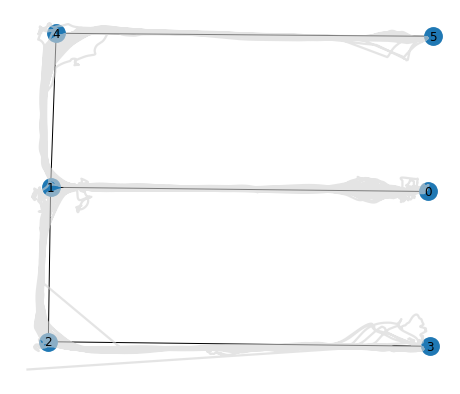

In [4]:
from track_linearization import plot_track_graph

plt.figure(figsize=(8, 7))
plt.plot(data['position_info'].nose_x, data['position_info'].nose_y, color='lightgrey', alpha=0.6)
plot_track_graph(data['track_graph'])
sns.despine(bottom=True, left=True)

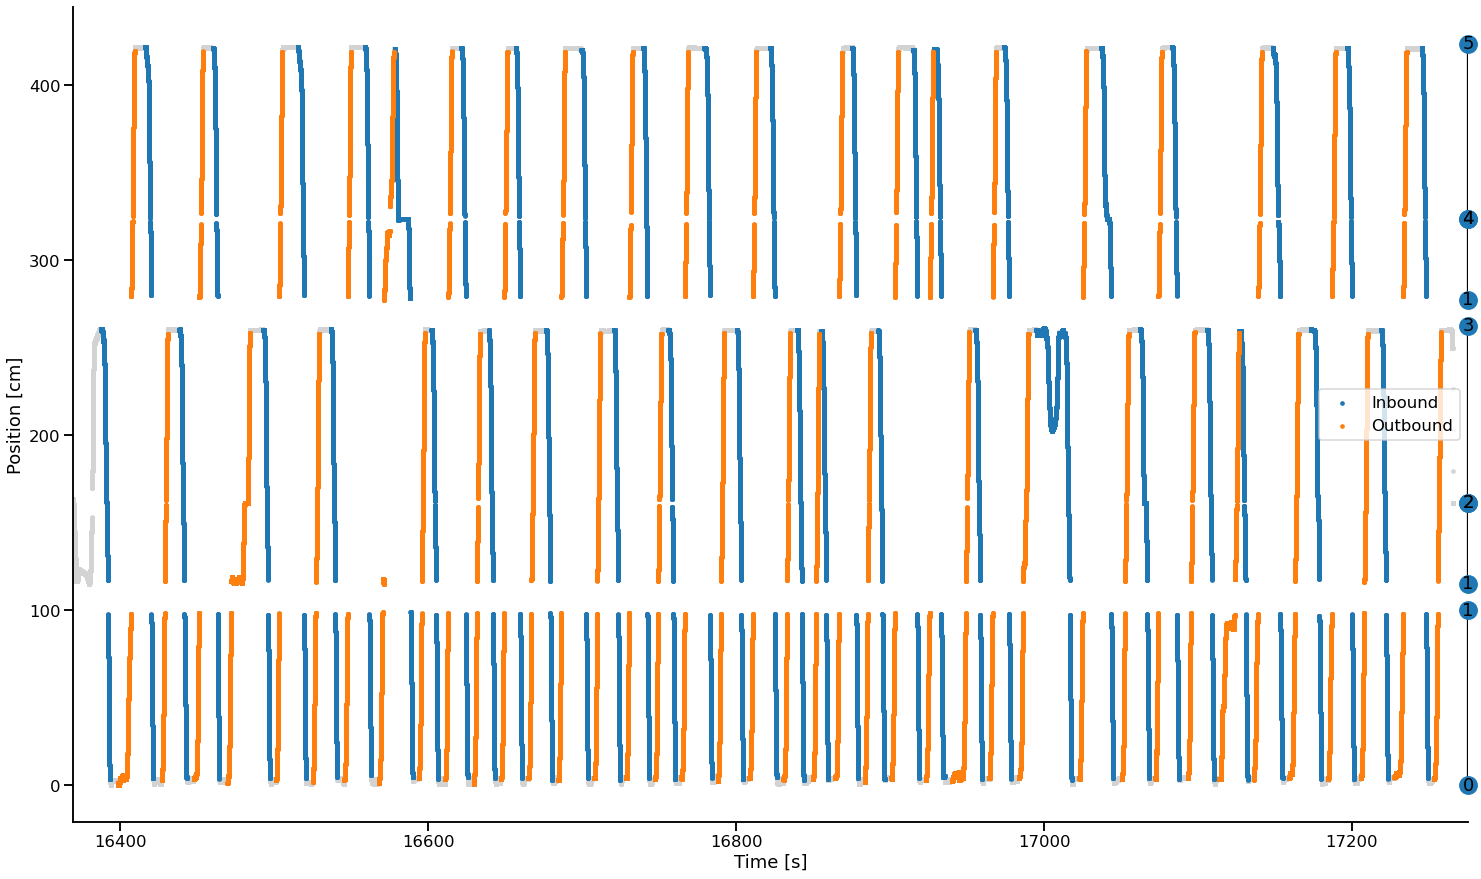

In [5]:
from track_linearization import plot_graph_as_1D

plt.figure(figsize=(25, 15))

time = data['position_info'].index / np.timedelta64(1, 's')
plt.scatter(time,
            data['position_info'].linear_position, color='lightgrey', s=10)

for name, df in data['position_info'].groupby('task'):
    plt.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=10, label=name)

plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=10.0 + time[-1])

plt.legend()
plt.ylabel('Position [cm]')
plt.xlabel('Time [s]')
plt.xlim((time[0], time[-1] + 10.0))

sns.despine()

In [67]:
continuous_transition_types = [['random_walk_direction2', 'random_walk',            'uniform', 'random_walk',            'random_walk',            'uniform'],
                               ['random_walk',            'random_walk_direction1', 'uniform', 'random_walk',            'random_walk',            'uniform'],
                               ['uniform',                'uniform',                'uniform', 'uniform',                'uniform',                'uniform'],
                               ['random_walk',            'random_walk',            'uniform', 'random_walk_direction1', 'random_walk',            'uniform'],
                               ['random_walk',            'random_walk',            'uniform', 'random_walk',            'random_walk_direction2', 'uniform'],
                               ['uniform',                'uniform',                'uniform', 'uniform',                'uniform',                'uniform'],
                               ]
encoding_group_to_state = ['Inbound', 'Inbound', 'Inbound', 'Outbound', 'Outbound', 'Outbound']

# use identity instead of random walk at transition?
# exclude diagonal of random walk?


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.0,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])}, 
}

In [68]:
from replay_trajectory_classification import ClusterlessClassifier

classifier = ClusterlessClassifier(**classifier_parameters)

In [8]:
data["position_info"].task.unique()

array([nan, 'Inbound', 'Outbound'], dtype=object)

In [9]:
data["position_info"].task.value_counts()

Outbound    111800
Inbound     107627
Name: task, dtype: int64

In [10]:
data["position_info"].shape

(448081, 36)

In [69]:
import pandas as pd

inbound_outbound_labels = np.asarray(data["position_info"].task).astype(str)

is_running = (np.abs(data["position_info"].nose_vel) > 4) & pd.notnull(data["position_info"].task)

classifier.fit(
    position=data["position_info"].linear_position,
    multiunits=data["multiunits"],
    is_training=is_running,
    track_graph=data["track_graph"],
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
    encoding_group_labels=inbound_outbound_labels,
    encoding_group_to_state=encoding_group_to_state
)

19-Dec-20 12:34:08 Fitting initial conditions...
19-Dec-20 12:34:08 Fitting state transition...
19-Dec-20 12:34:18 Fitting multiunits...


ClusterlessClassifier(continuous_transition_types=[['random_walk_direction2',
                                                    'random_walk', 'uniform',
                                                    'random_walk',
                                                    'random_walk', 'uniform'],
                                                   ['random_walk',
                                                    'random_walk_direction1',
                                                    'uniform', 'random_walk',
                                                    'random_walk', 'uniform'],
                                                   ['uniform', 'uniform',
                                                    'uniform', 'uniform',
                                                    'uniform', 'uniform'],
                                                   ['random_walk',
                                                    'random_walk', 'uniform',
                            

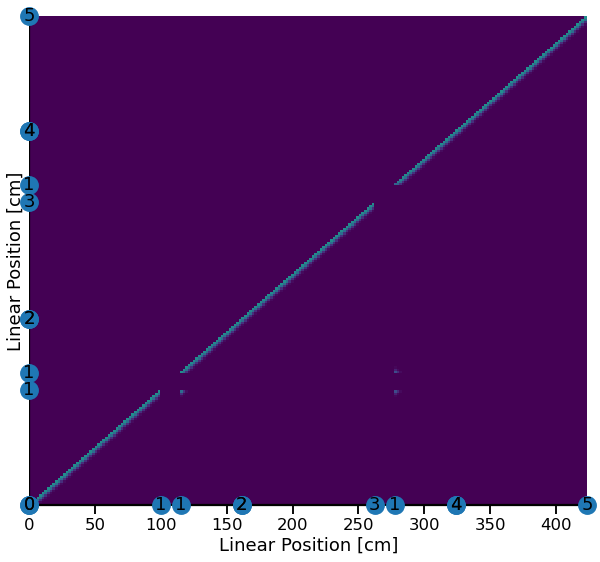

In [70]:
plt.figure(figsize=(10, 9))
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], classifier.continuous_state_transition_[0, 0].T)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)

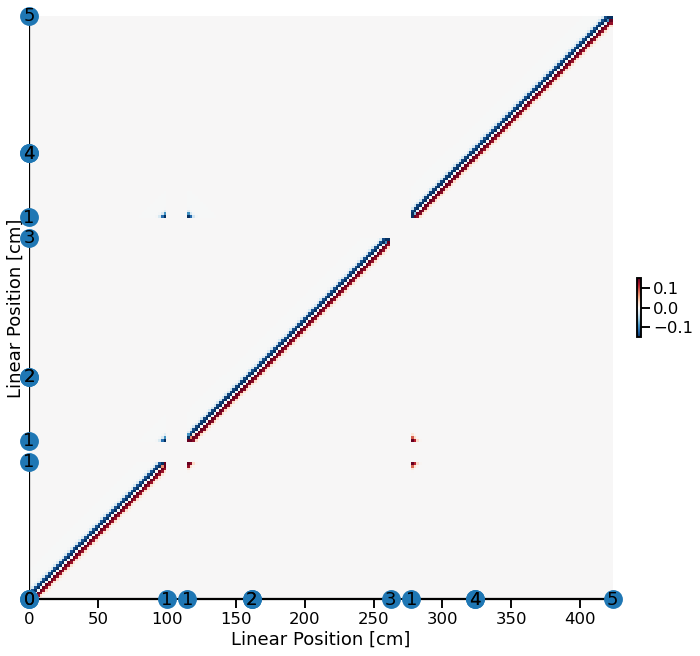

In [71]:
fig, ax = plt.subplots(figsize=(10, 9), constrained_layout=True)

inbound_v_outbound = (classifier.continuous_state_transition_[0, 0] -
                      classifier.continuous_state_transition_[3, 3]).T
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], inbound_v_outbound,
               cmap='RdBu_r', vmax=0.15, vmin=-0.15)
plt.axis('square')
plt.colorbar(shrink=0.1)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)

Text(0.5, 1.0, 'Inbound-Forward')

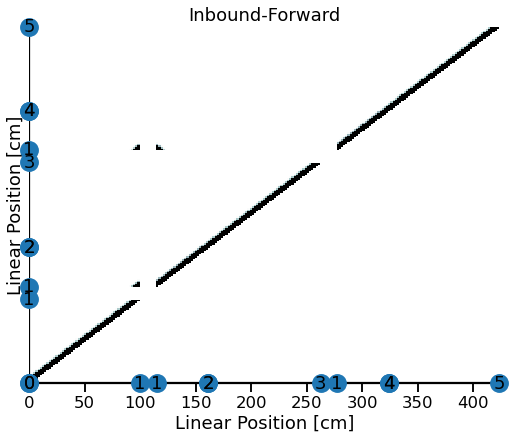

In [118]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], classifier.continuous_state_transition_[0, 0],
               cmap='bone_r', vmax=0.01, vmin=0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)
plt.title('Inbound-Forward')

Text(0.5, 1.0, 'Inbound-Reverse')

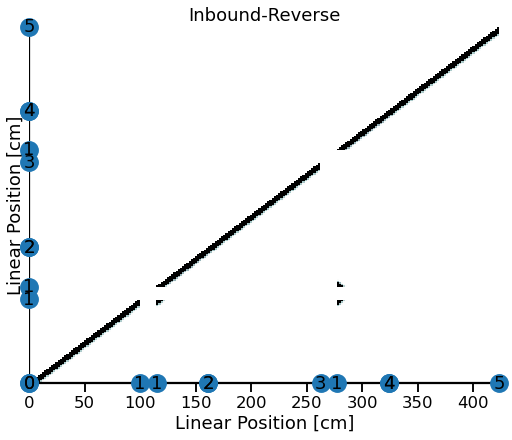

In [119]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], classifier.continuous_state_transition_[1, 1],
               cmap='bone_r', vmax=0.01, vmin=0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)
plt.title('Inbound-Reverse')

Text(0.5, 1.0, 'Outbound-Forward')

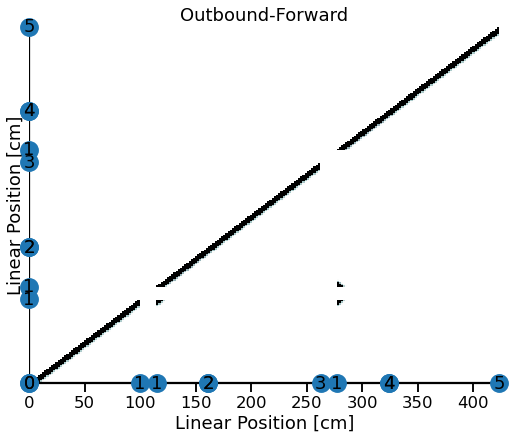

In [120]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], classifier.continuous_state_transition_[3, 3],
               cmap='bone_r', vmax=0.01, vmin=0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)
plt.title('Outbound-Forward')

Text(0.5, 1.0, 'Outbound-Reverse')

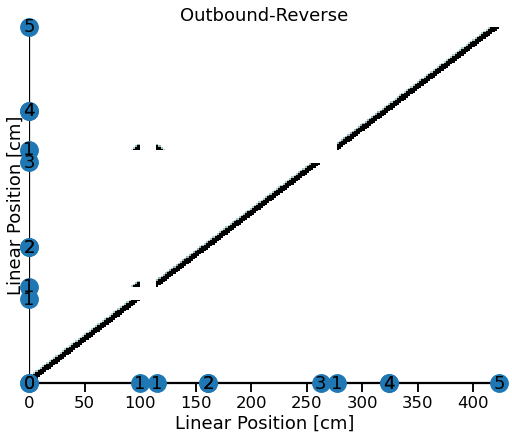

In [121]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], classifier.continuous_state_transition_[4, 4],
               cmap='bone_r', vmax=0.01, vmin=0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)
plt.title('Outbound-Reverse')

Text(0.5, 1.0, 'Inbound')

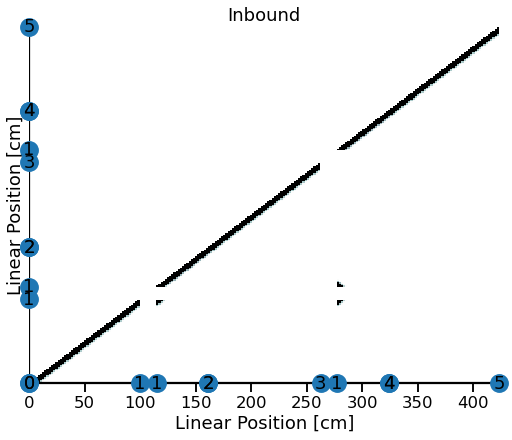

In [116]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], classifier.continuous_state_transition_[3, 3],
               cmap='bone_r', vmax=0.01, vmin=0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)
plt.title('Inbound')

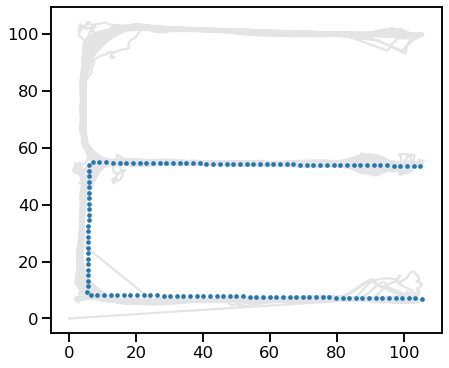

In [72]:
import networkx as nx
classifier.track_graph_with_bin_centers_edges_
nx.shortest_path(data['track_graph'], source=0, target=3)
nx.shortest_path(data['track_graph'], source=0, target=5)
nx.shortest_path(data['track_graph'], source=5, target=0)
nx.shortest_path(data['track_graph'], source=3, target=0)

path = nx.shortest_path(classifier.track_graph_with_bin_centers_edges_, source=0, target=3)

path_nodes = classifier.nodes_df_.set_index('node_id').loc[path]
path_nodes = path_nodes.loc[~path_nodes.is_bin_edge]

plt.figure(figsize=(7, 6))
plt.plot(data['position_info'].nose_x, data['position_info'].nose_y, color='lightgrey', alpha=0.6)
plt.scatter(path_nodes.x_position, path_nodes.y_position, zorder=10, s=10)

Text(0.5, 1.0, 'Outbound')

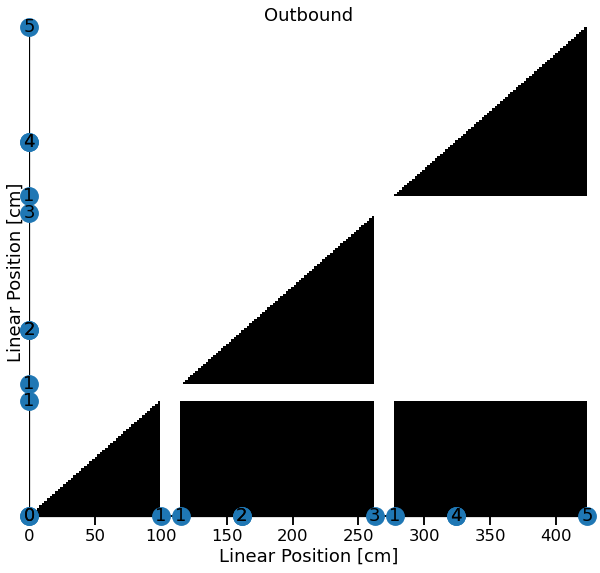

In [104]:
place_bin_center_ind_to_node = np.asarray(classifier.place_bin_centers_nodes_df_.node_id)

n_bins = place_bin_center_ind_to_node.shape[0]
transition = np.zeros((n_bins, n_bins))

# Outbound Right
path = nx.shortest_path(classifier.track_graph_with_bin_centers_edges_, source=0, target=3)

path_nodes = classifier.nodes_df_.set_index('node_id').loc[path]
path_nodes = path_nodes.loc[~path_nodes.is_bin_edge]

for bin_ind, node1 in enumerate(path_nodes.index):
    from_ind = np.isin(place_bin_center_ind_to_node, node1)
    to_ind = np.isin(place_bin_center_ind_to_node, path_nodes.index[bin_ind + 1:])
    transition[from_ind, to_ind] = 1
    
# Outbound Left
path = nx.shortest_path(classifier.track_graph_with_bin_centers_edges_, source=0, target=5)

path_nodes = classifier.nodes_df_.set_index('node_id').loc[path]
path_nodes = path_nodes.loc[~path_nodes.is_bin_edge]

for bin_ind, node1 in enumerate(path_nodes.index):
    from_ind = np.isin(place_bin_center_ind_to_node, node1)
    to_ind = np.isin(place_bin_center_ind_to_node, path_nodes.index[bin_ind + 1:])
    transition[from_ind, to_ind] = 1
    transition[from_ind, from_ind] = 1
    
fig, ax = plt.subplots(figsize=(10, 9))
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], transition, cmap='bone_r')
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)
plt.title('Outbound')

Text(0.5, 1.0, 'Inbound')

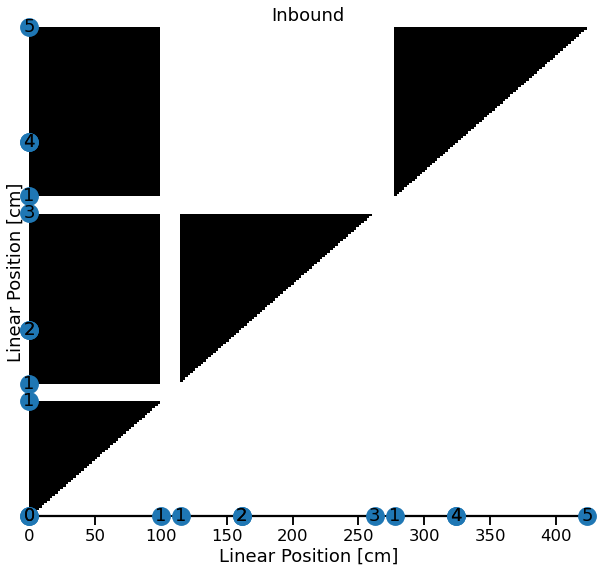

In [105]:
place_bin_center_ind_to_node = np.asarray(classifier.place_bin_centers_nodes_df_.node_id)

n_bins = place_bin_center_ind_to_node.shape[0]
transition = np.zeros((n_bins, n_bins))

# Outbound Right
path = nx.shortest_path(classifier.track_graph_with_bin_centers_edges_, source=3, target=0)

path_nodes = classifier.nodes_df_.set_index('node_id').loc[path]
path_nodes = path_nodes.loc[~path_nodes.is_bin_edge]

for bin_ind, node1 in enumerate(path_nodes.index):
    from_ind = np.isin(place_bin_center_ind_to_node, node1)
    to_ind = np.isin(place_bin_center_ind_to_node, path_nodes.index[bin_ind + 1:])
    transition[from_ind, to_ind] = 1
    
# Outbound Left
path = nx.shortest_path(classifier.track_graph_with_bin_centers_edges_, source=5, target=0)

path_nodes = classifier.nodes_df_.set_index('node_id').loc[path]
path_nodes = path_nodes.loc[~path_nodes.is_bin_edge]

for bin_ind, node1 in enumerate(path_nodes.index):
    from_ind = np.isin(place_bin_center_ind_to_node, node1)
    to_ind = np.isin(place_bin_center_ind_to_node, path_nodes.index[bin_ind + 1:])
    transition[from_ind, to_ind] = 1
    transition[from_ind, from_ind] = 1

fig, ax = plt.subplots(figsize=(10, 9))
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], transition, cmap='bone_r')
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)
plt.title('Inbound')

In [35]:
from replay_trajectory_classification.state_transition import CONTINUOUS_TRANSITIONS
from replay_trajectory_classification.bins import atleast_2d

st = {}
for task, position in data['position_info'].groupby('task').linear_position:
    position = atleast_2d(np.asarray(position))
    is_training = np.ones((position.shape[0],), dtype=np.bool)
    st[task] = CONTINUOUS_TRANSITIONS['empirical_movement'](
        classifier.place_bin_centers_,
        classifier.is_track_interior_,
        position,
        classifier.edges_,
        None,
        30,
        classifier.position_range,
        classifier.movement_var,
        np.asarray(classifier.place_bin_centers_nodes_df_.node_id),
        classifier.distance_between_nodes_)

Text(0.5, 1.0, 'Inbound')

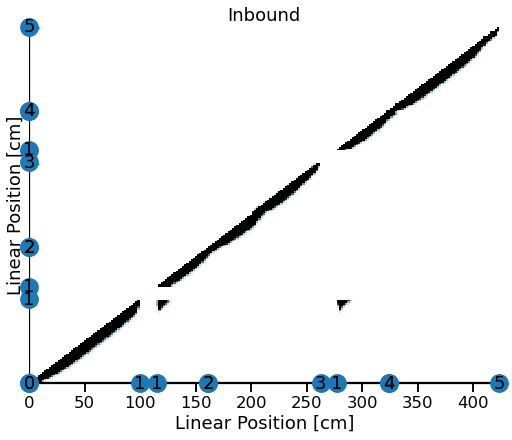

In [111]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], st['Inbound'],
               cmap='bone_r', vmax=0.01, vmin=0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)
plt.title('Inbound')

Text(0.5, 1.0, 'Outbound')

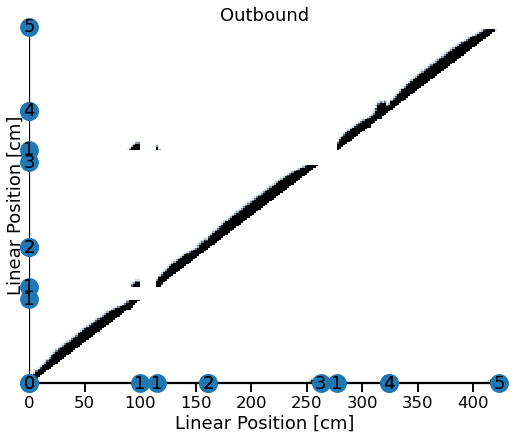

In [113]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], st['Outbound'],
               cmap='bone_r', vmax=0.01, vmin=0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)
plt.title('Outbound')

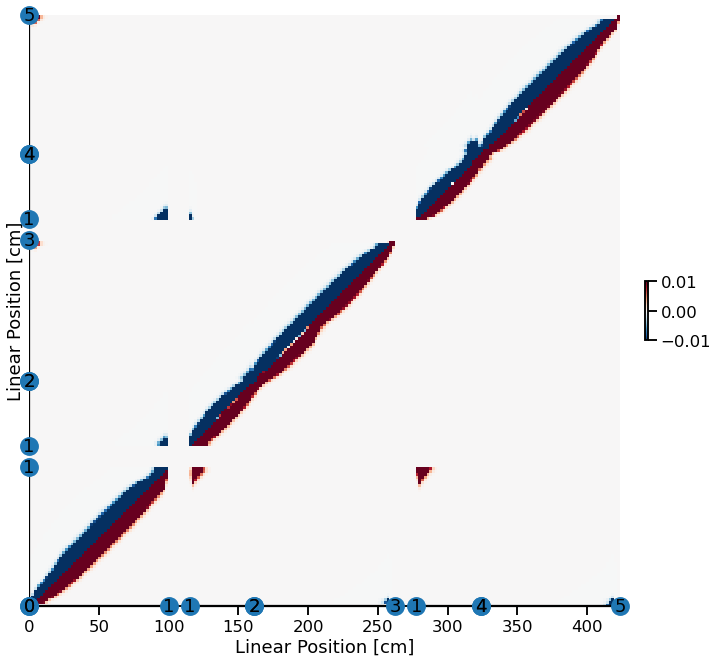

In [106]:
fig, ax = plt.subplots(figsize=(10, 9), constrained_layout=True)
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], (st['Inbound'] - st['Outbound']),
               cmap='RdBu_r', vmax=0.01, vmin=-0.01)
plt.axis('square')
plt.colorbar(shrink=0.1)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)

In [14]:
data['ripple_times']

start_time                  end_time  duration
replay_number                                                              
1             0 days 04:33:06.387033333 0 days 04:33:06.594366666  0.207333
2             0 days 04:33:14.317033333 0 days 04:33:14.370366666  0.053333
3             0 days 04:33:16.437033333 0 days 04:33:16.547699999  0.110667
4             0 days 04:33:30.251699999 0 days 04:33:30.301699999  0.050000
5             0 days 04:33:30.847699999 0 days 04:33:30.959699999  0.112000
...                                 ...                       ...       ...
202           0 days 04:47:24.933033333 0 days 04:47:25.049699999  0.116667
203           0 days 04:47:32.435699999 0 days 04:47:32.514366666  0.078667
204           0 days 04:47:33.106366666 0 days 04:47:33.172366666  0.066000
205           0 days 04:47:40.517033333 0 days 04:47:40.563699999  0.046667
206           0 days 04:47:40.607699999 0 days 04:47:40.932366666  0.324667

[206 rows x 3 columns]

In [122]:
from src.visualization import plot_classifier_inbound_outbound_time_slice


def plot_ripple_decode(data, classifier, ripple_number):
    start_time = data['ripple_times'].loc[ripple_number].start_time
    end_time = data['ripple_times'].loc[ripple_number].end_time
    state_names = ['Inbound-Forward', 'Inbound-Reverse', 'Inbound-Fragmented',
                   'Outbound-Forward', 'Outbound-Reverse', 'Outbound-Fragmented']

    results = classifier.predict(
        multiunits=data['multiunits'].sel(time=slice(start_time, end_time)),
        time=data['multiunits'].sel(time=slice(start_time, end_time)).time / np.timedelta64(1, 's'),
        state_names=state_names
        )
    time_slice = slice(start_time / np.timedelta64(1, 's'),
                       end_time / np.timedelta64(1, 's'))

    plot_classifier_inbound_outbound_time_slice(
        time_slice,
        classifier,
        results,
        data,
        posterior_type="acausal_posterior",
        figsize=(30, 15),
    )

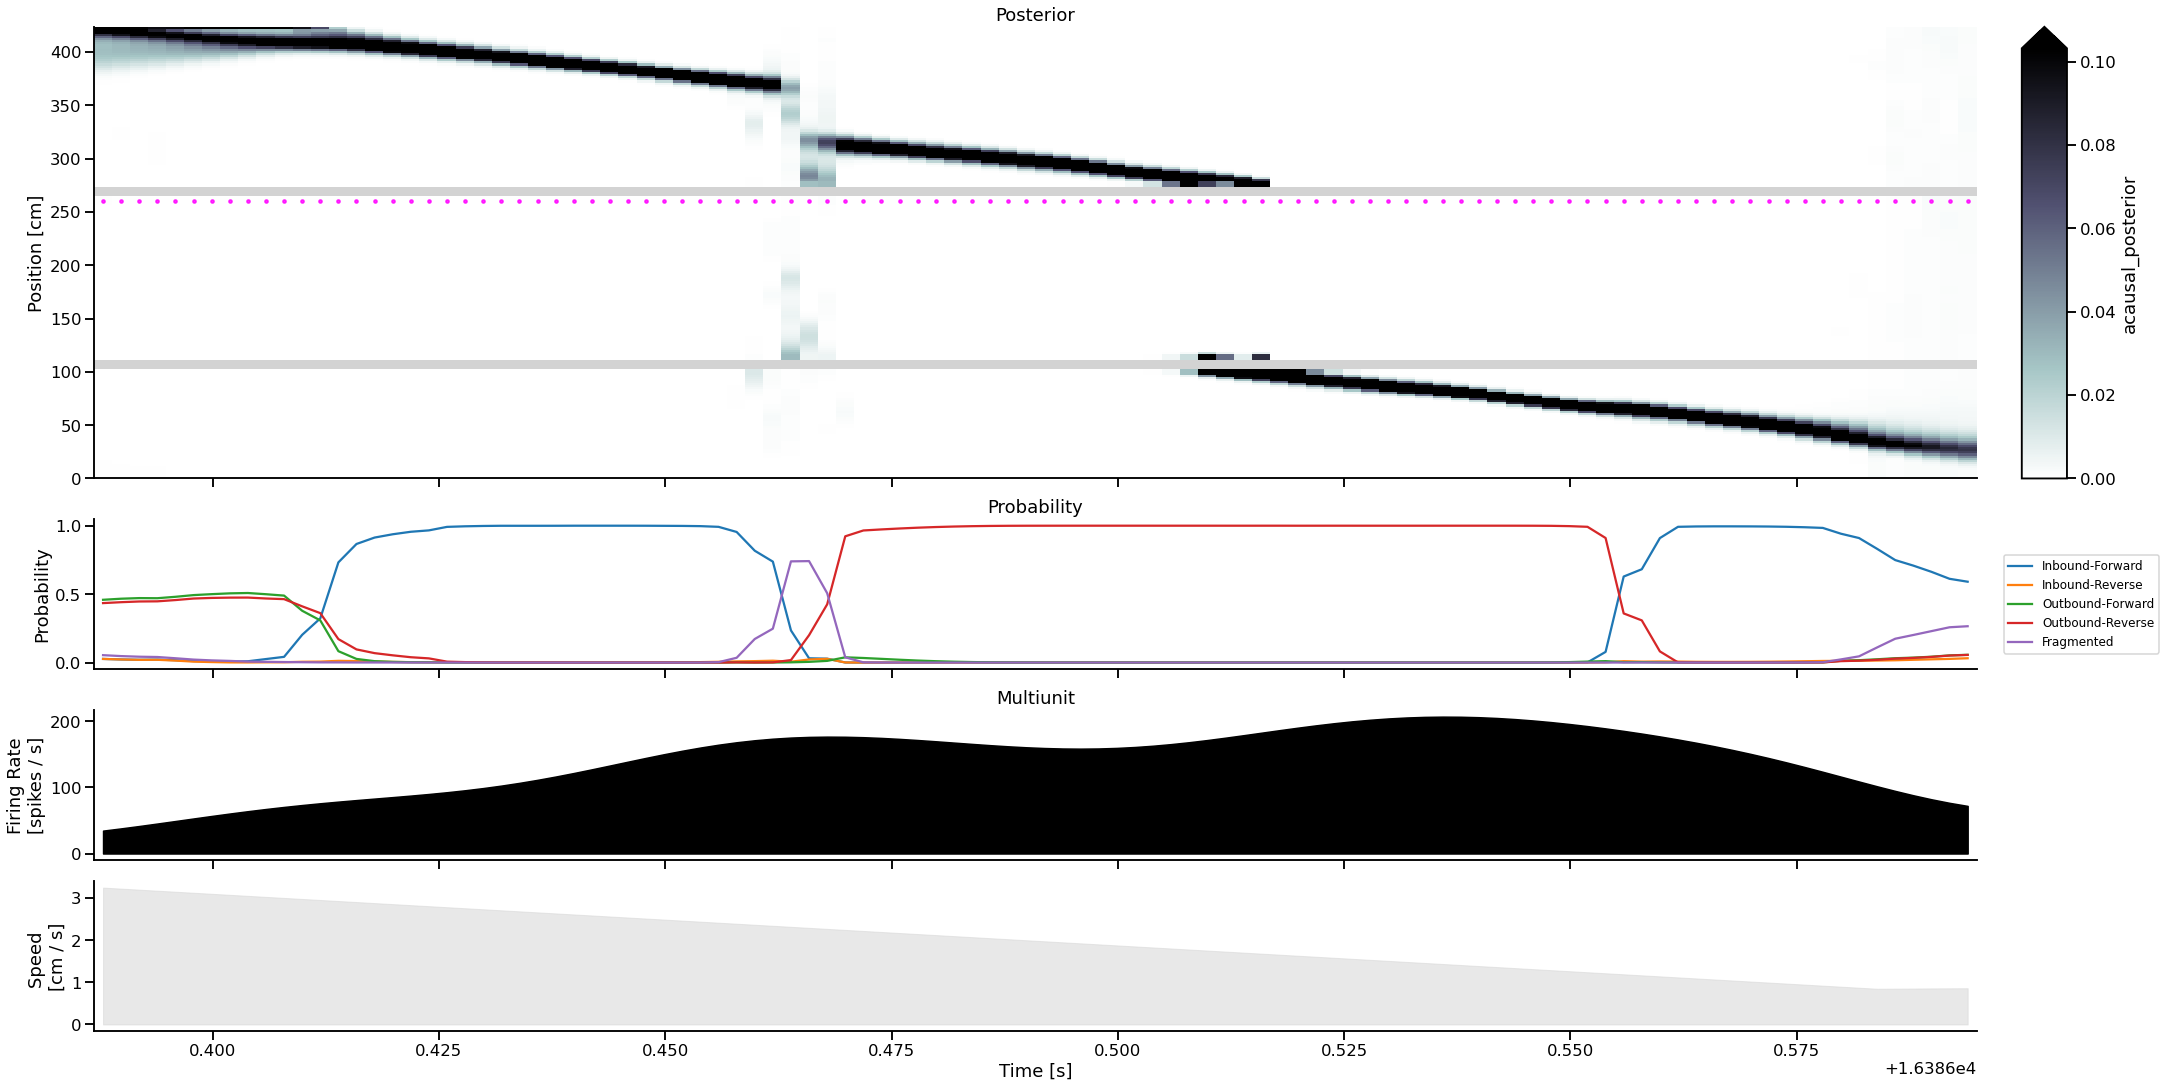

In [123]:
ripple_number = 1

plot_ripple_decode(data, classifier, ripple_number)

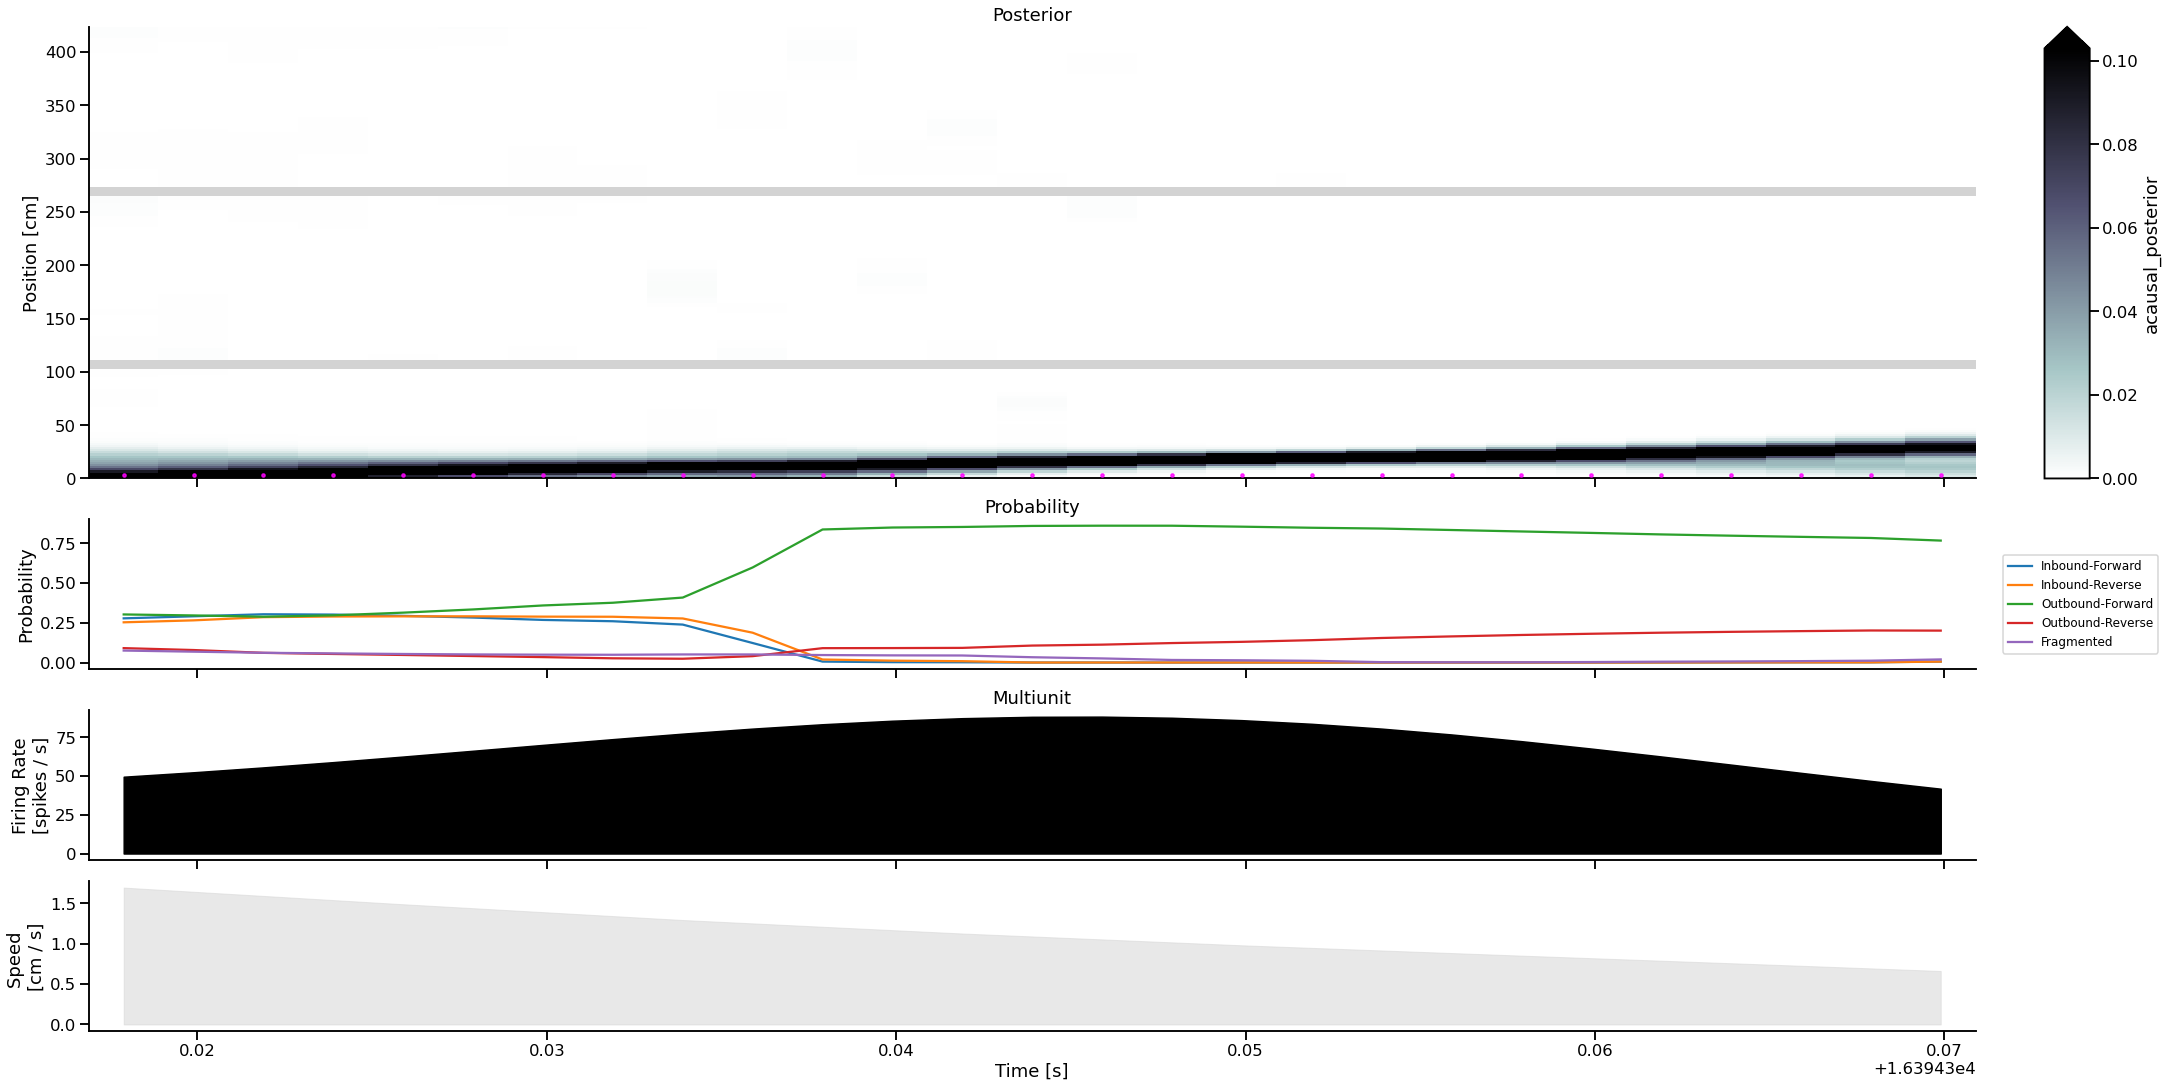

In [124]:
ripple_number = 2

plot_ripple_decode(data, classifier, ripple_number)

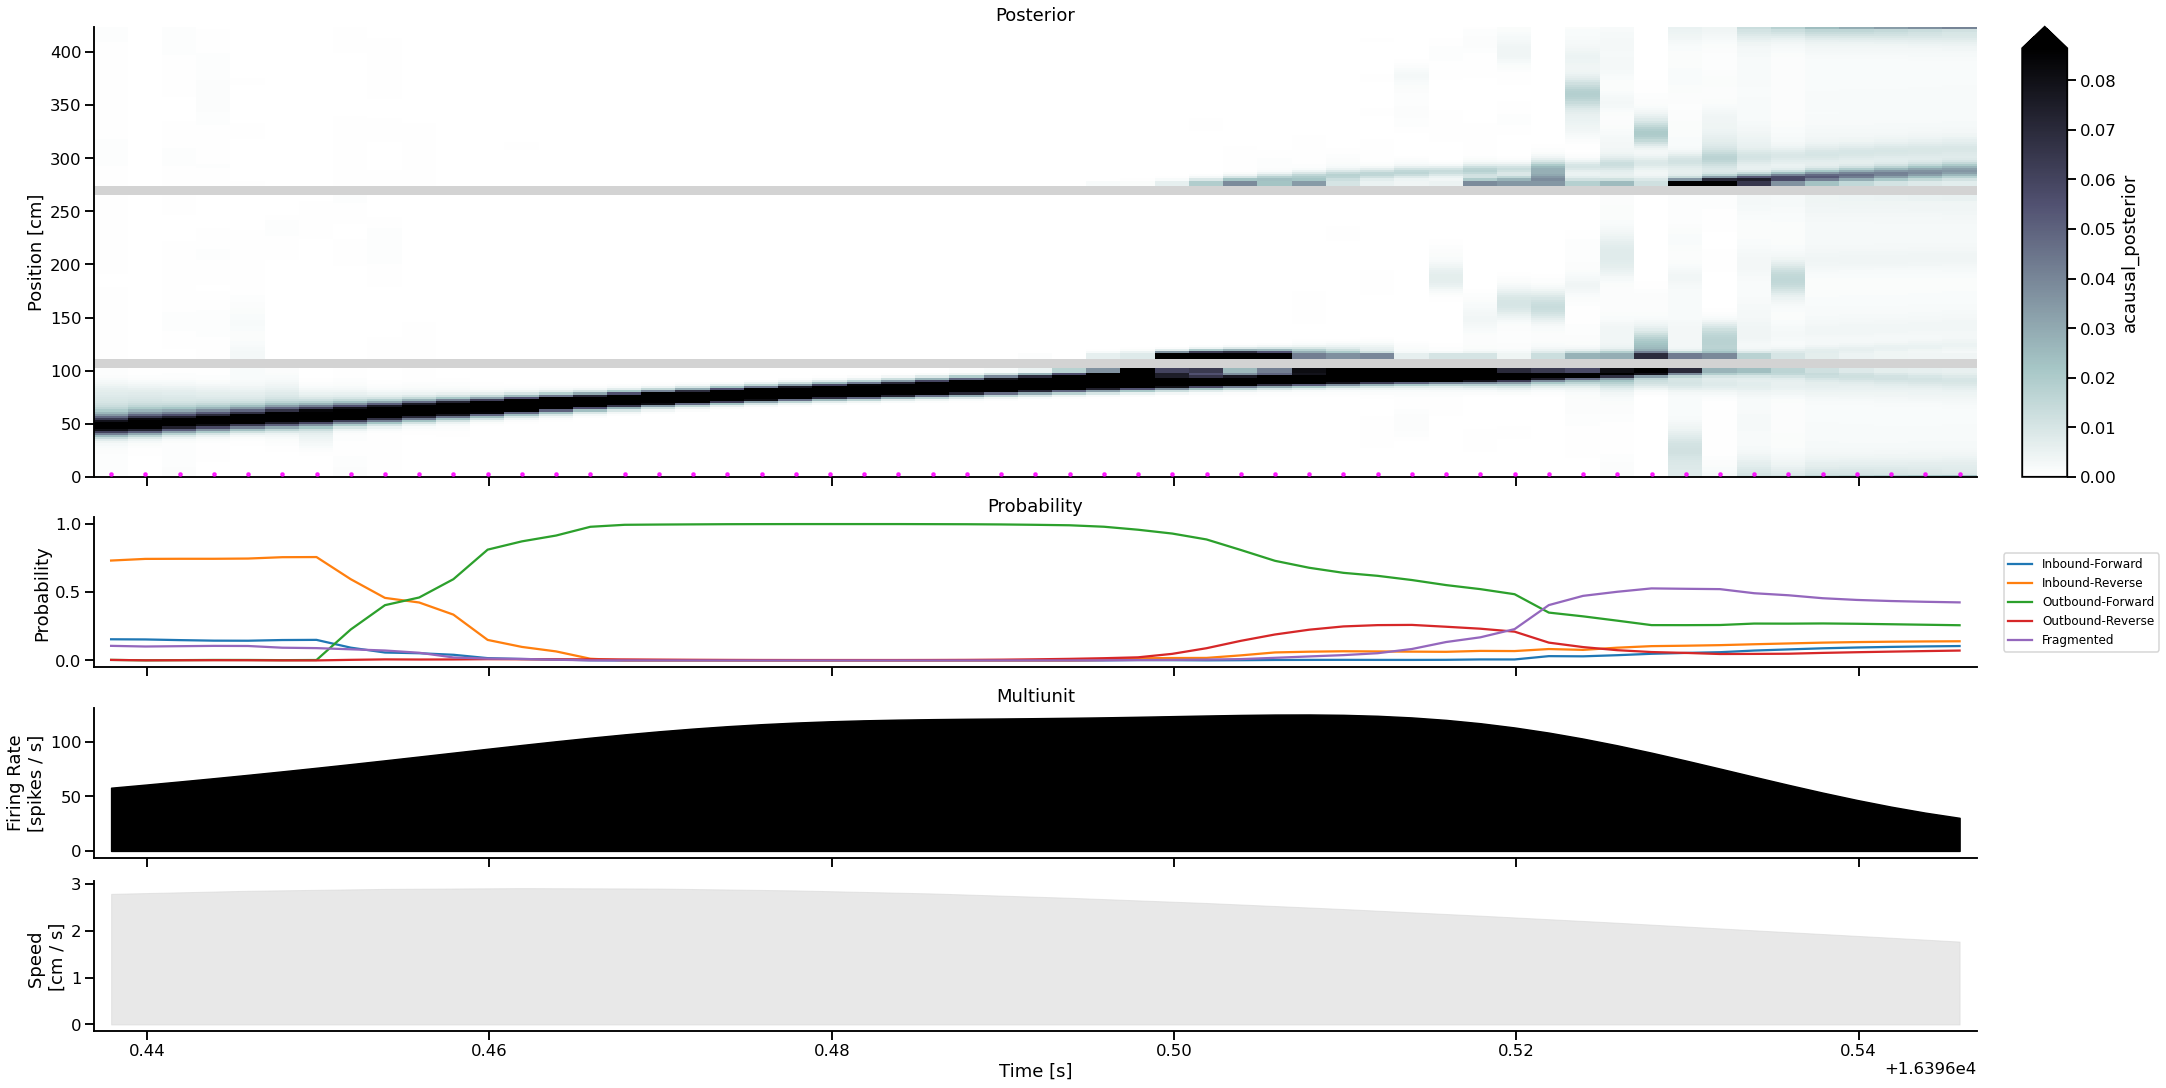

In [125]:
ripple_number = 3

plot_ripple_decode(data, classifier, ripple_number)

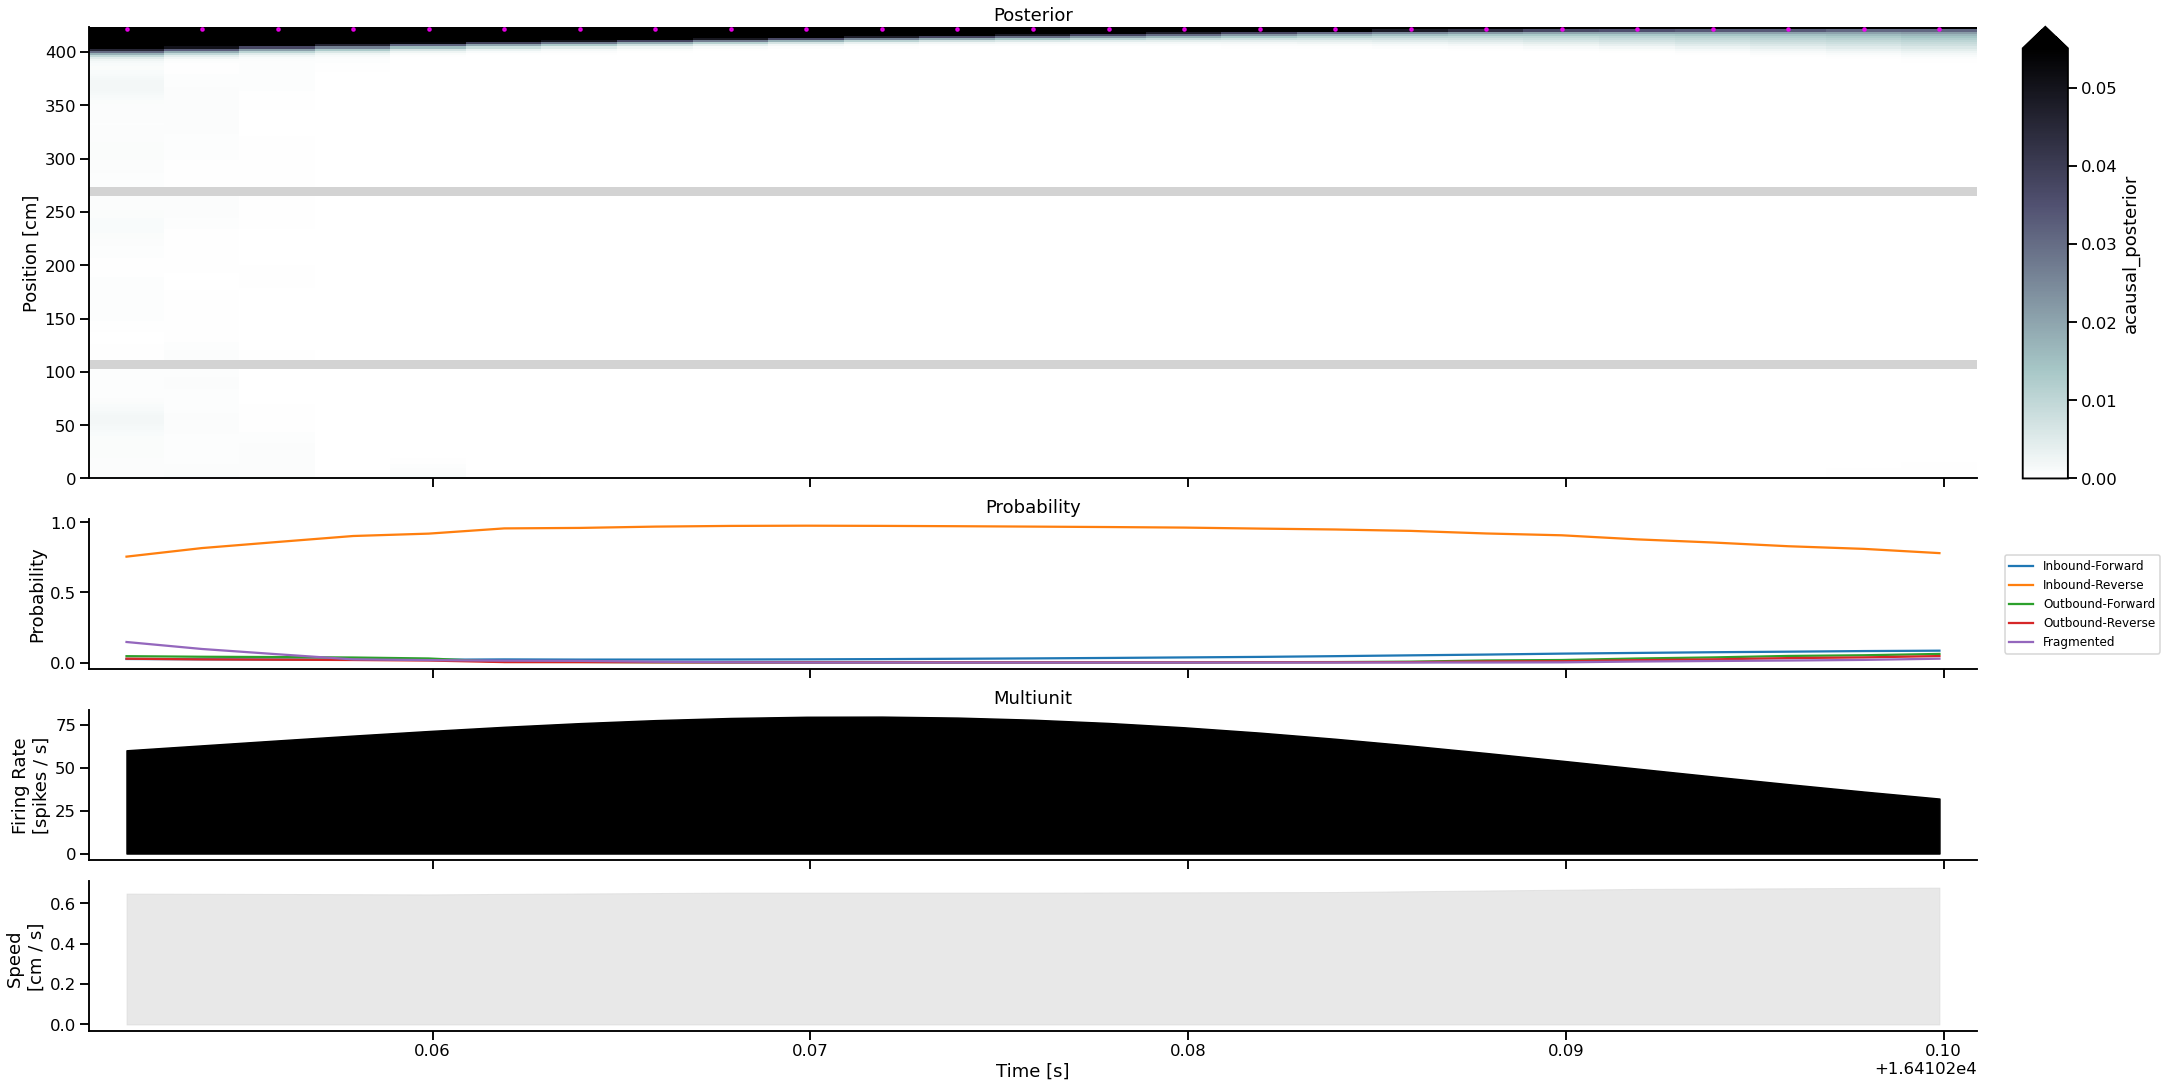

In [126]:
ripple_number = 4

plot_ripple_decode(data, classifier, ripple_number)

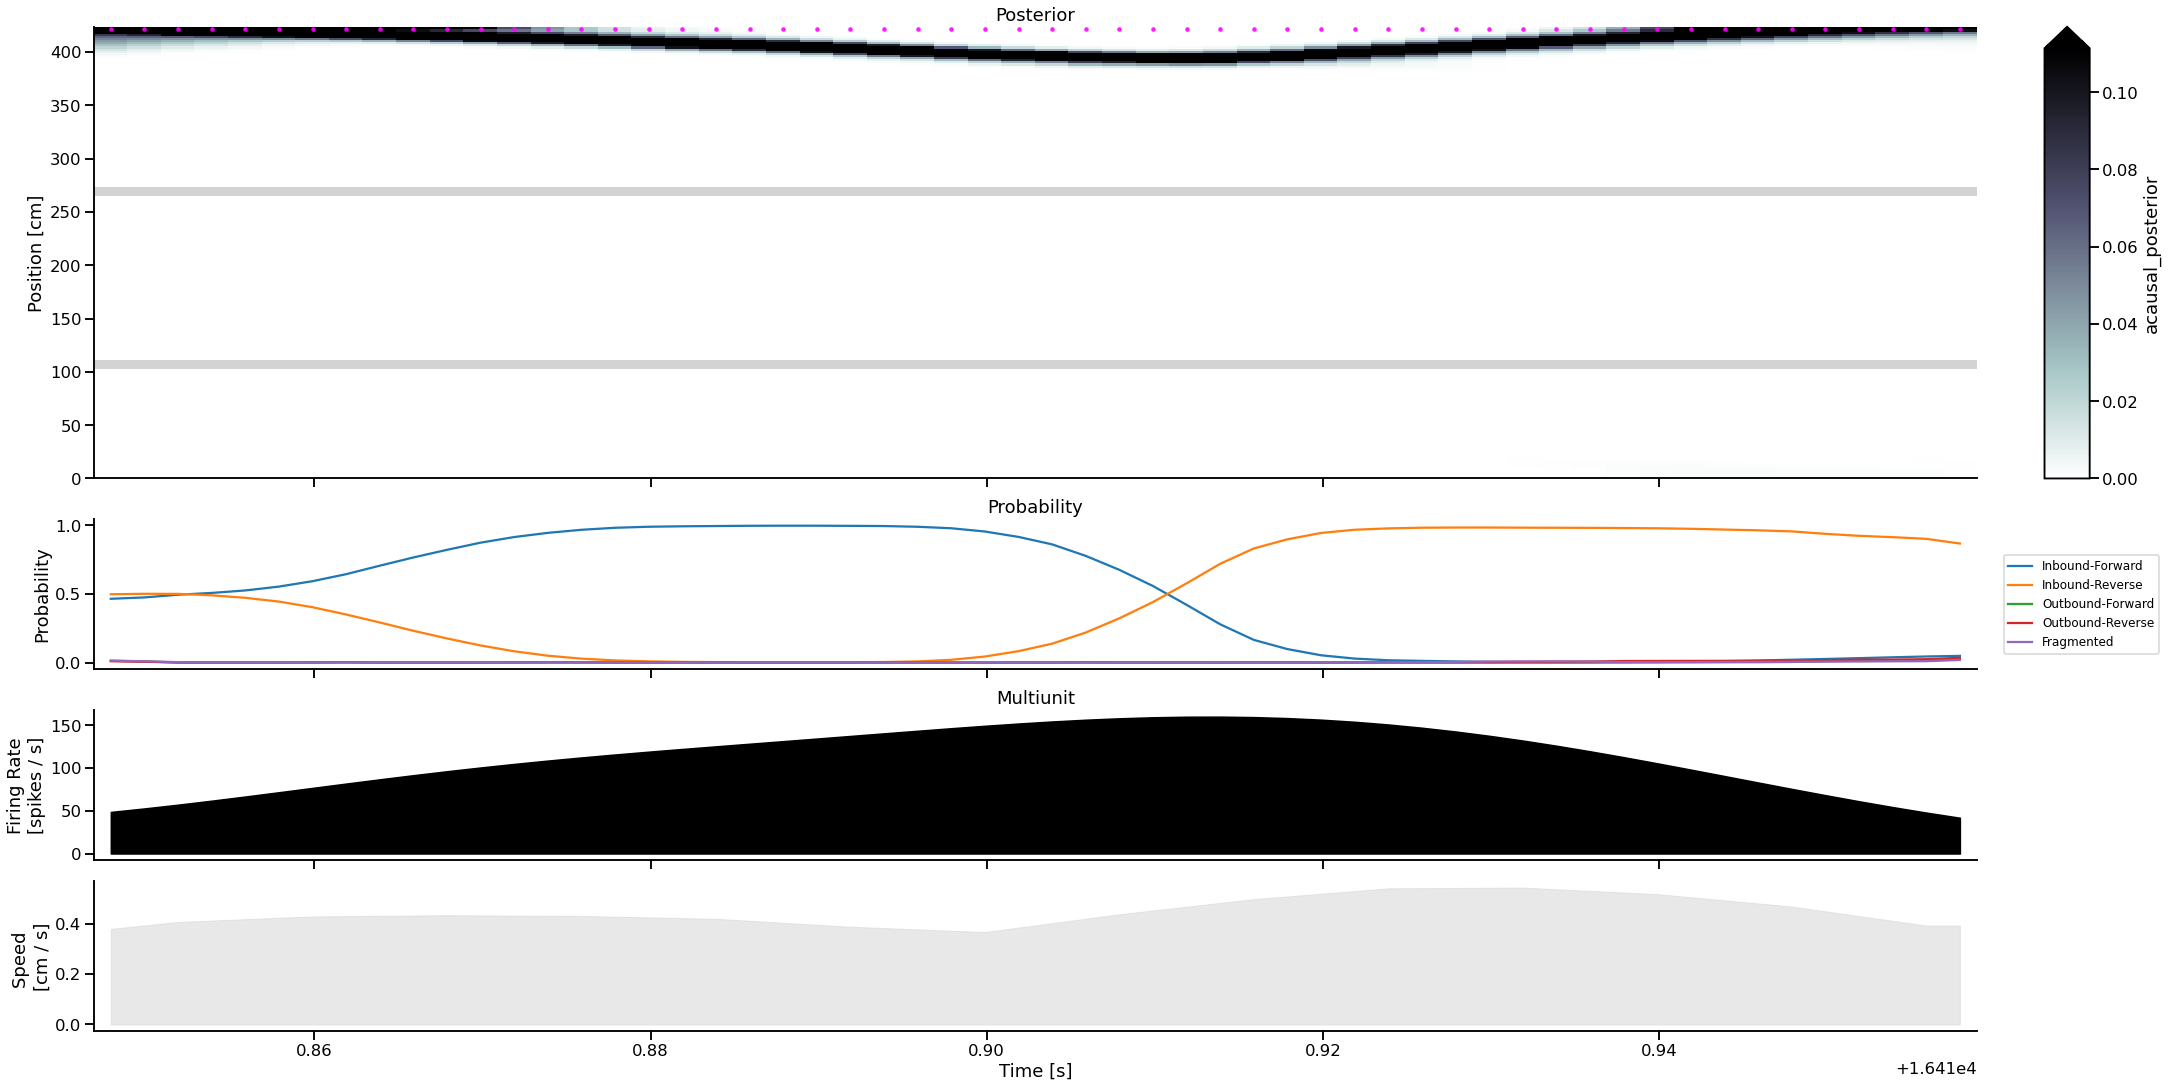

In [127]:
ripple_number = 5

plot_ripple_decode(data, classifier, ripple_number)

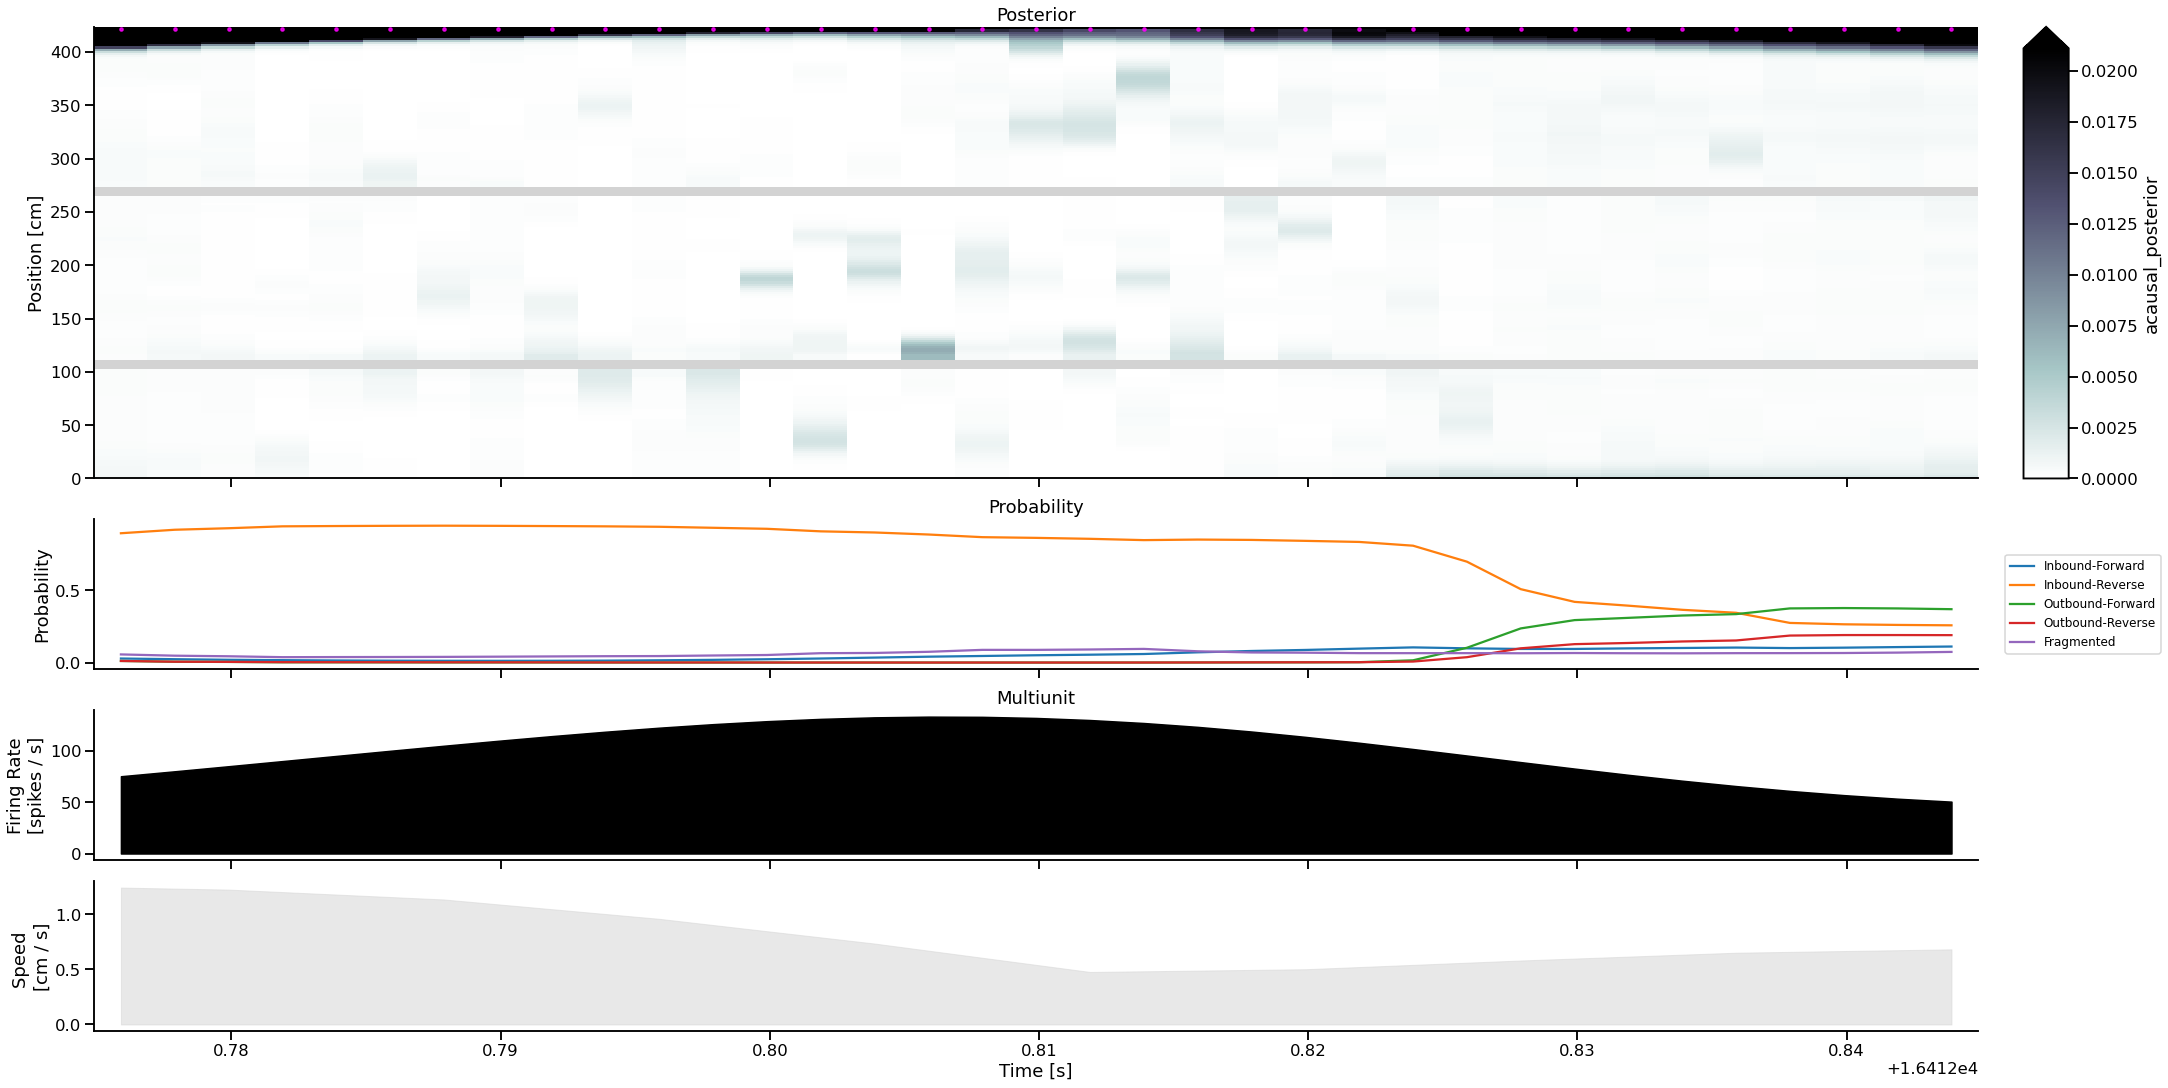

In [128]:
ripple_number = 6

plot_ripple_decode(data, classifier, ripple_number)

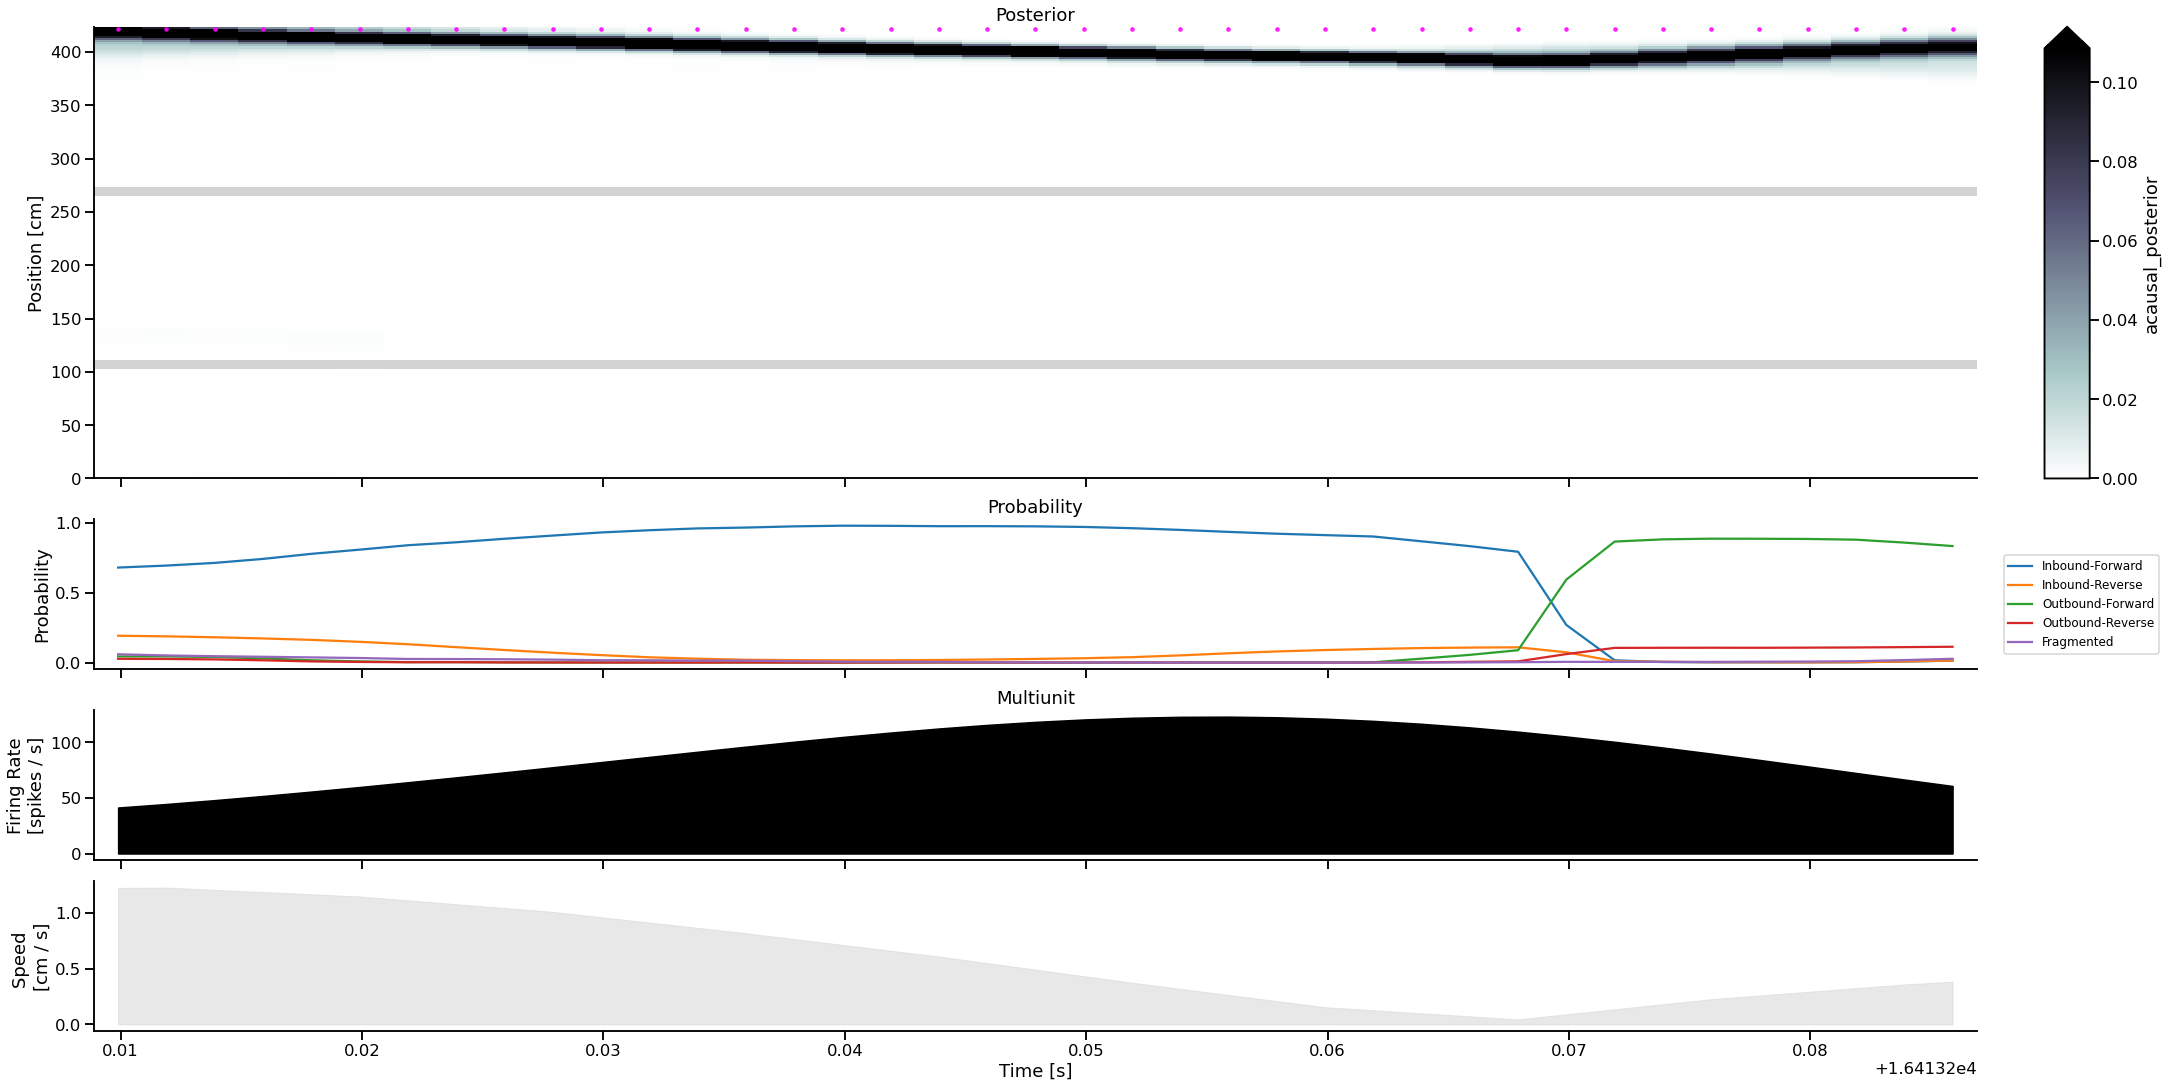

In [129]:
ripple_number = 7

plot_ripple_decode(data, classifier, ripple_number)

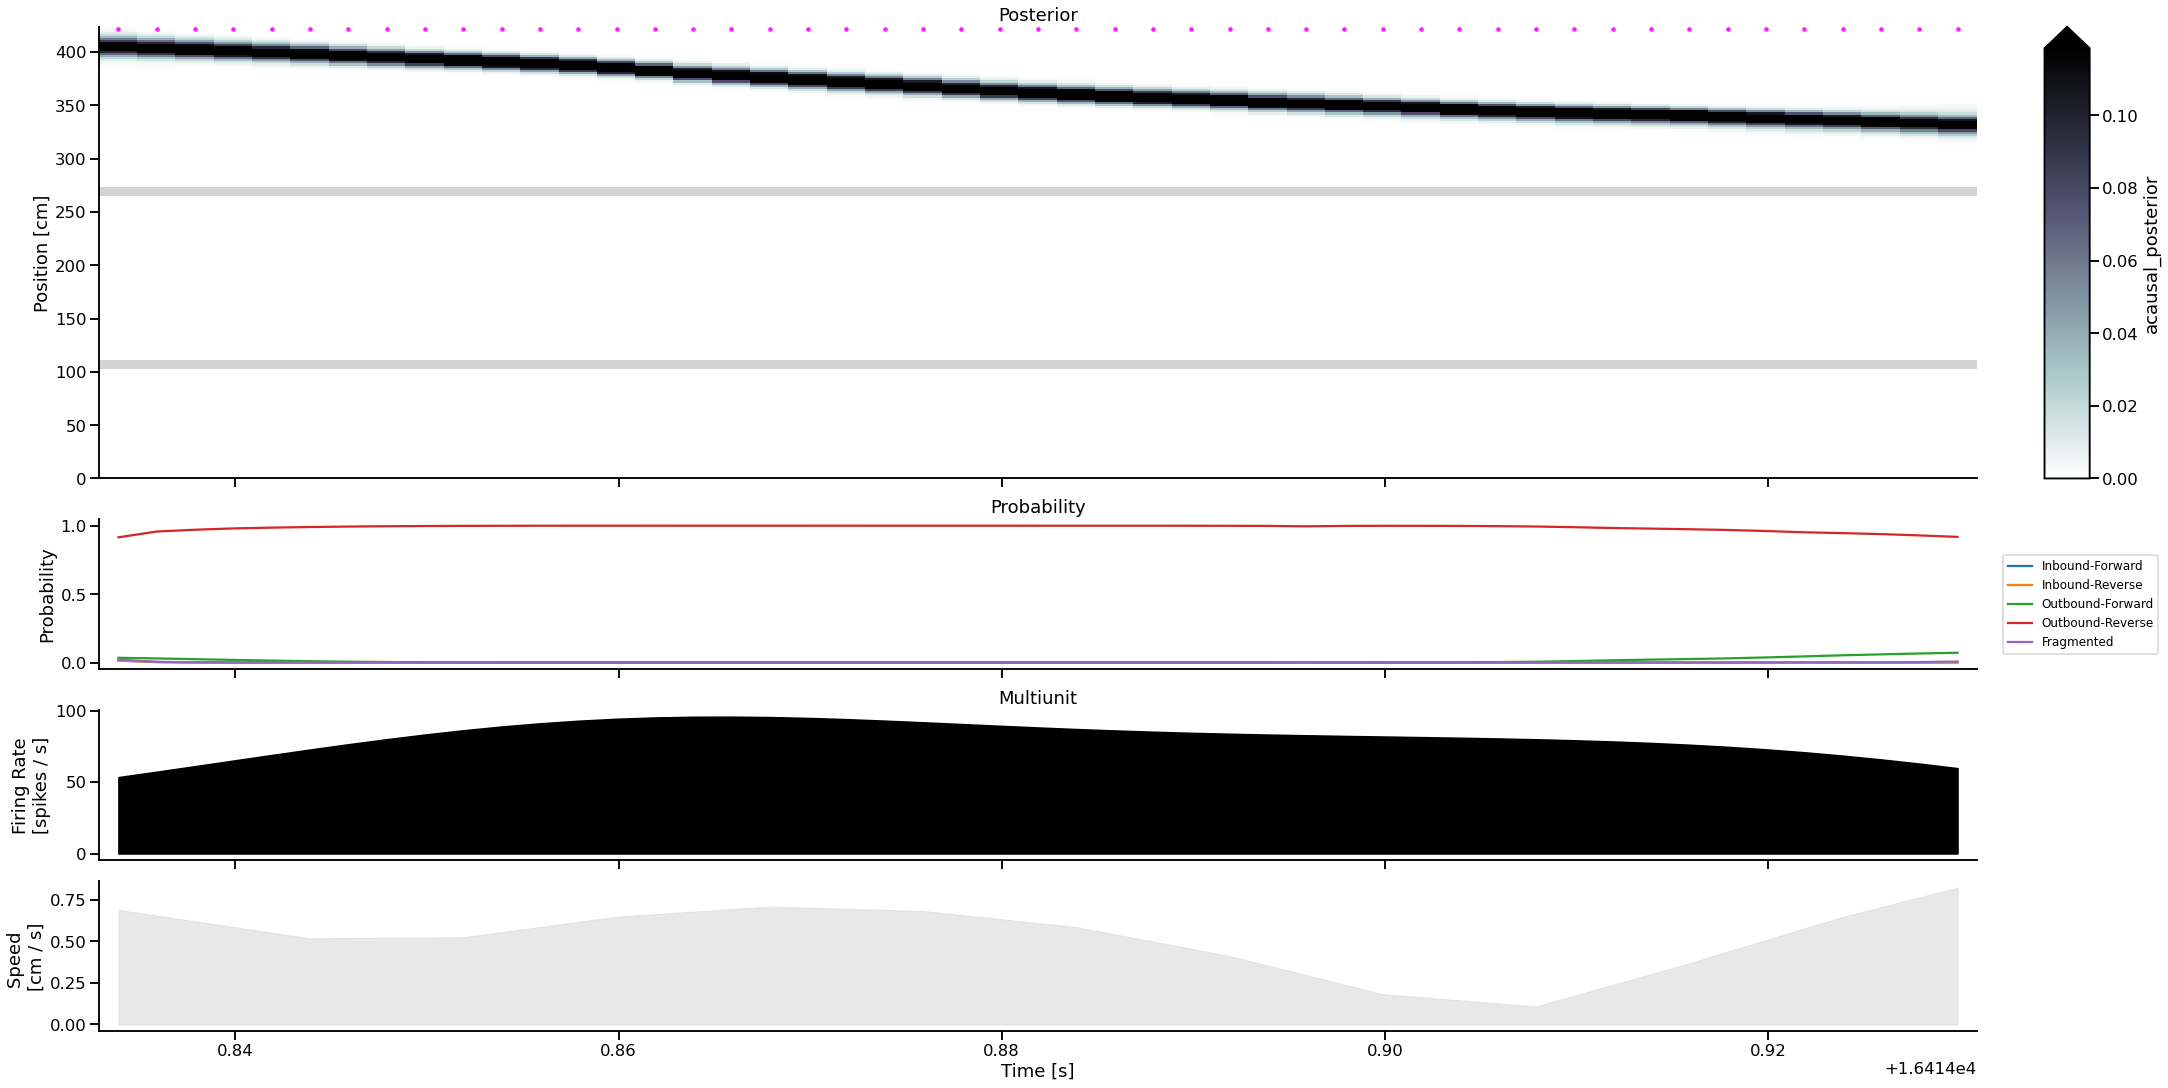

In [130]:
ripple_number = 8

plot_ripple_decode(data, classifier, ripple_number)

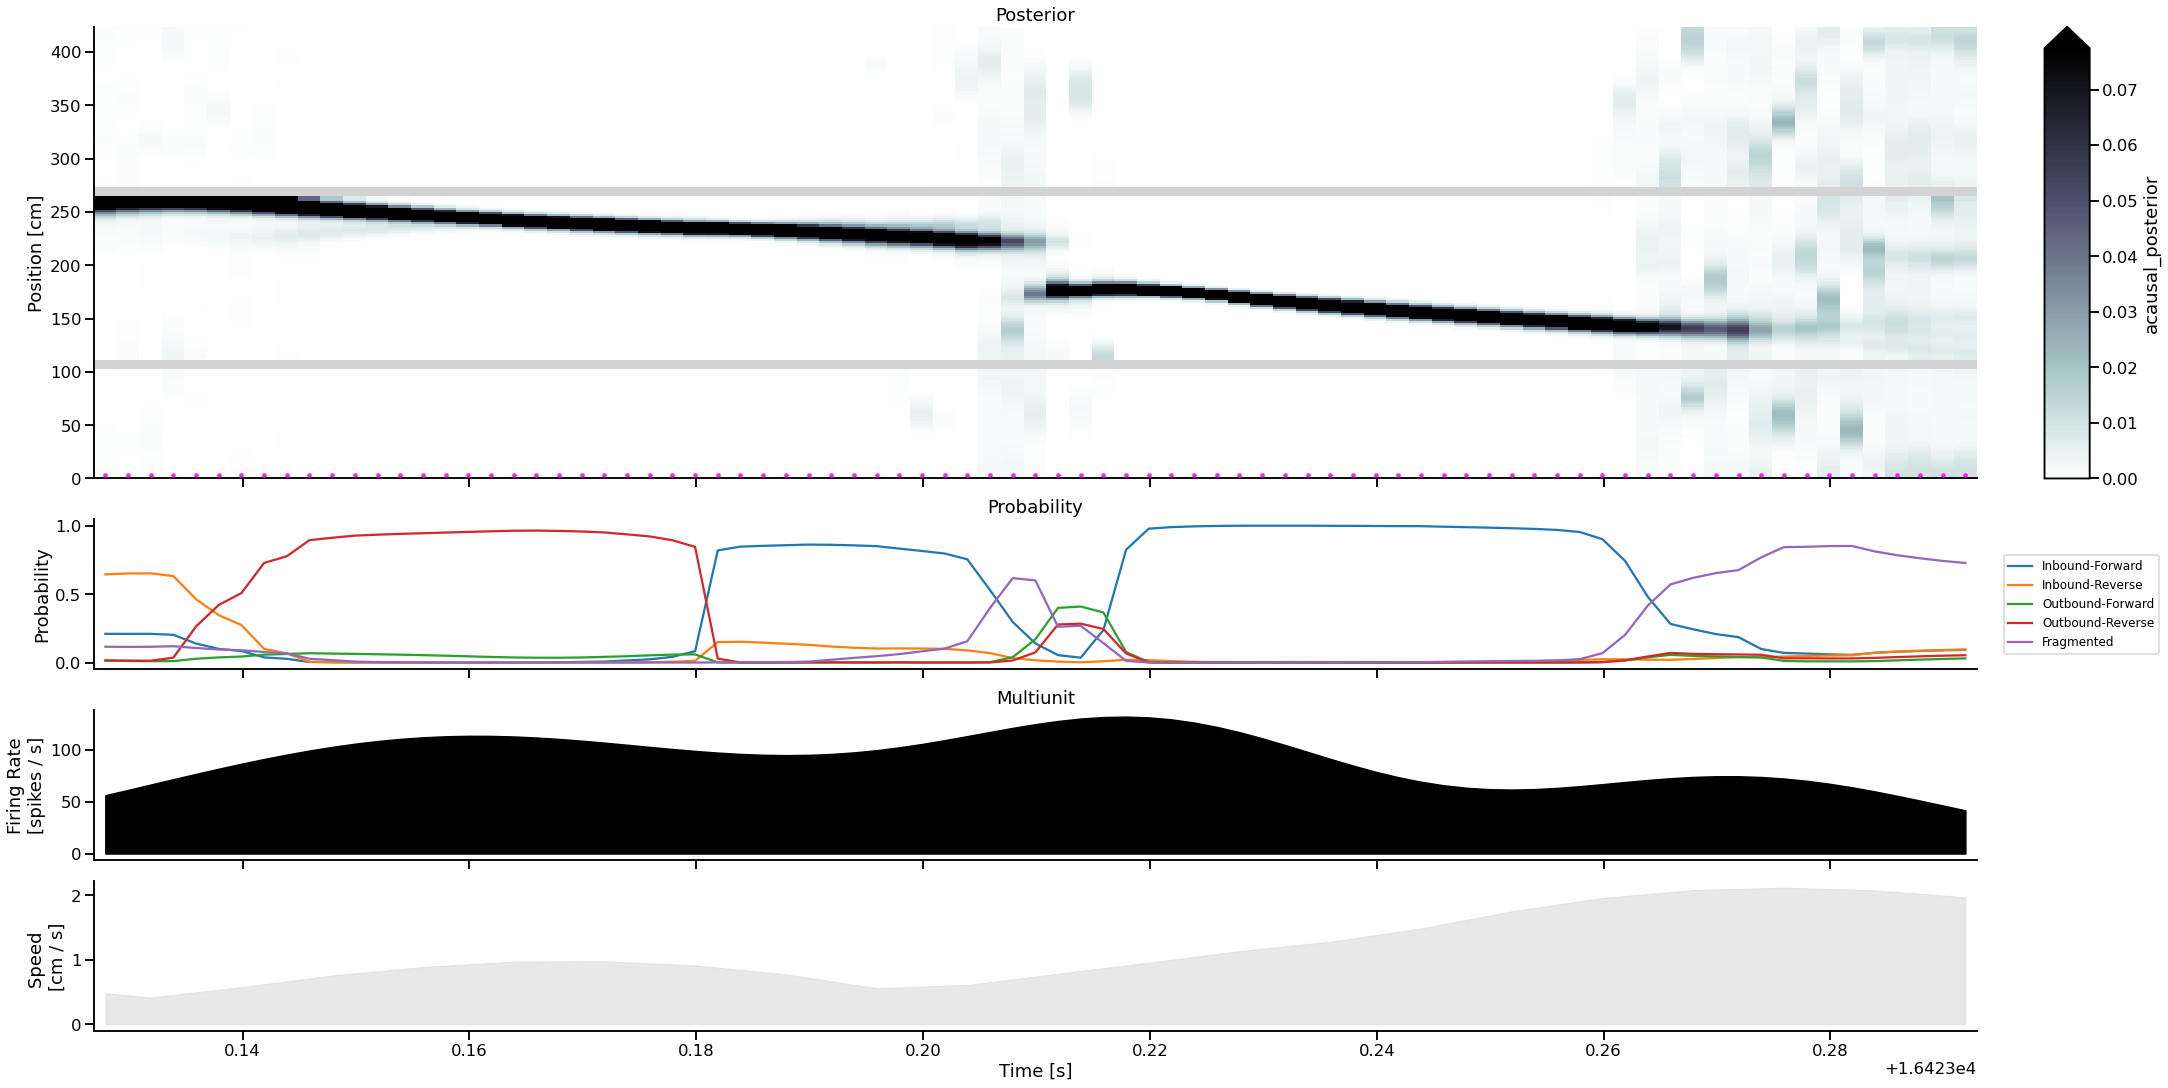

In [131]:
ripple_number = 9

plot_ripple_decode(data, classifier, ripple_number)

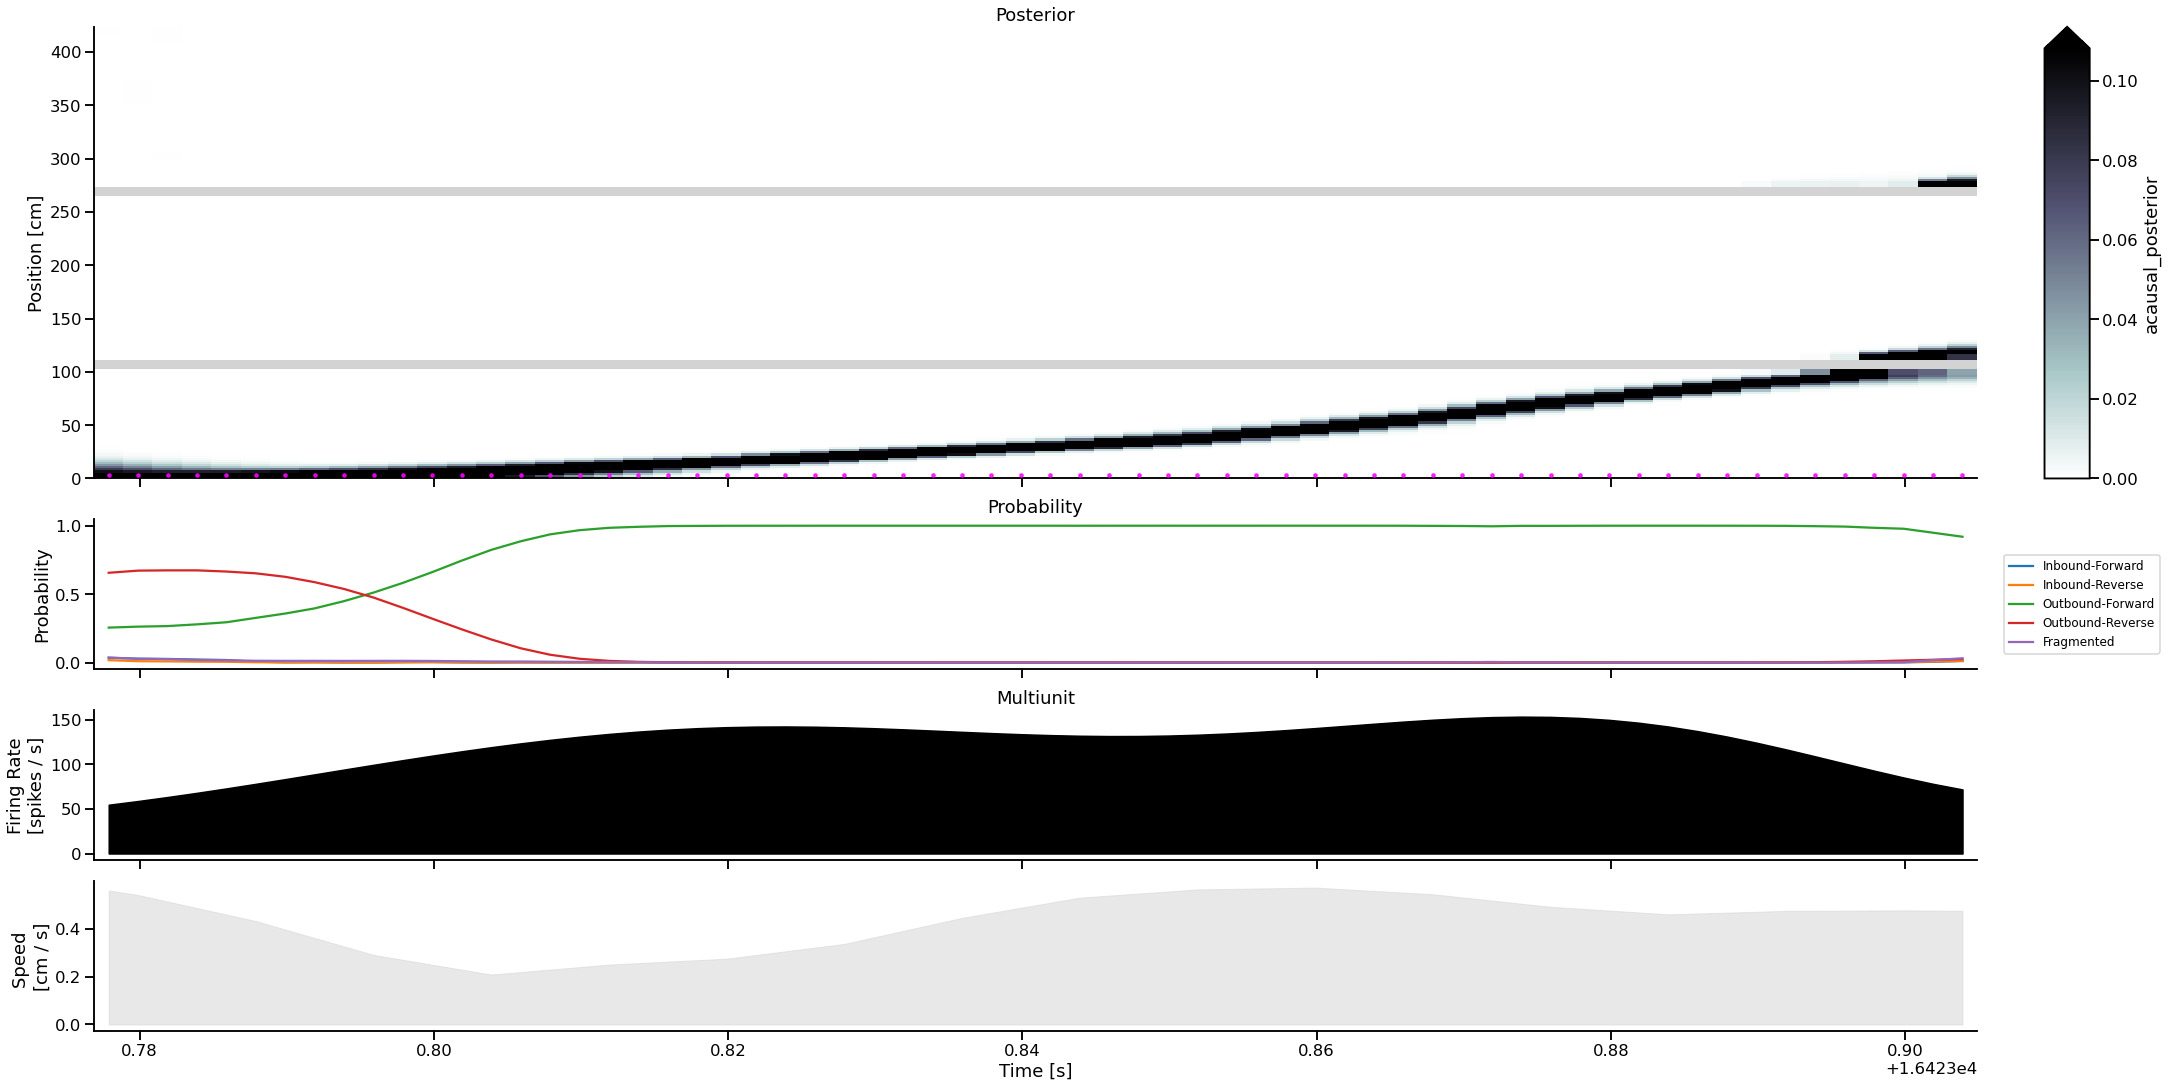

In [132]:
ripple_number = 10

plot_ripple_decode(data, classifier, ripple_number)

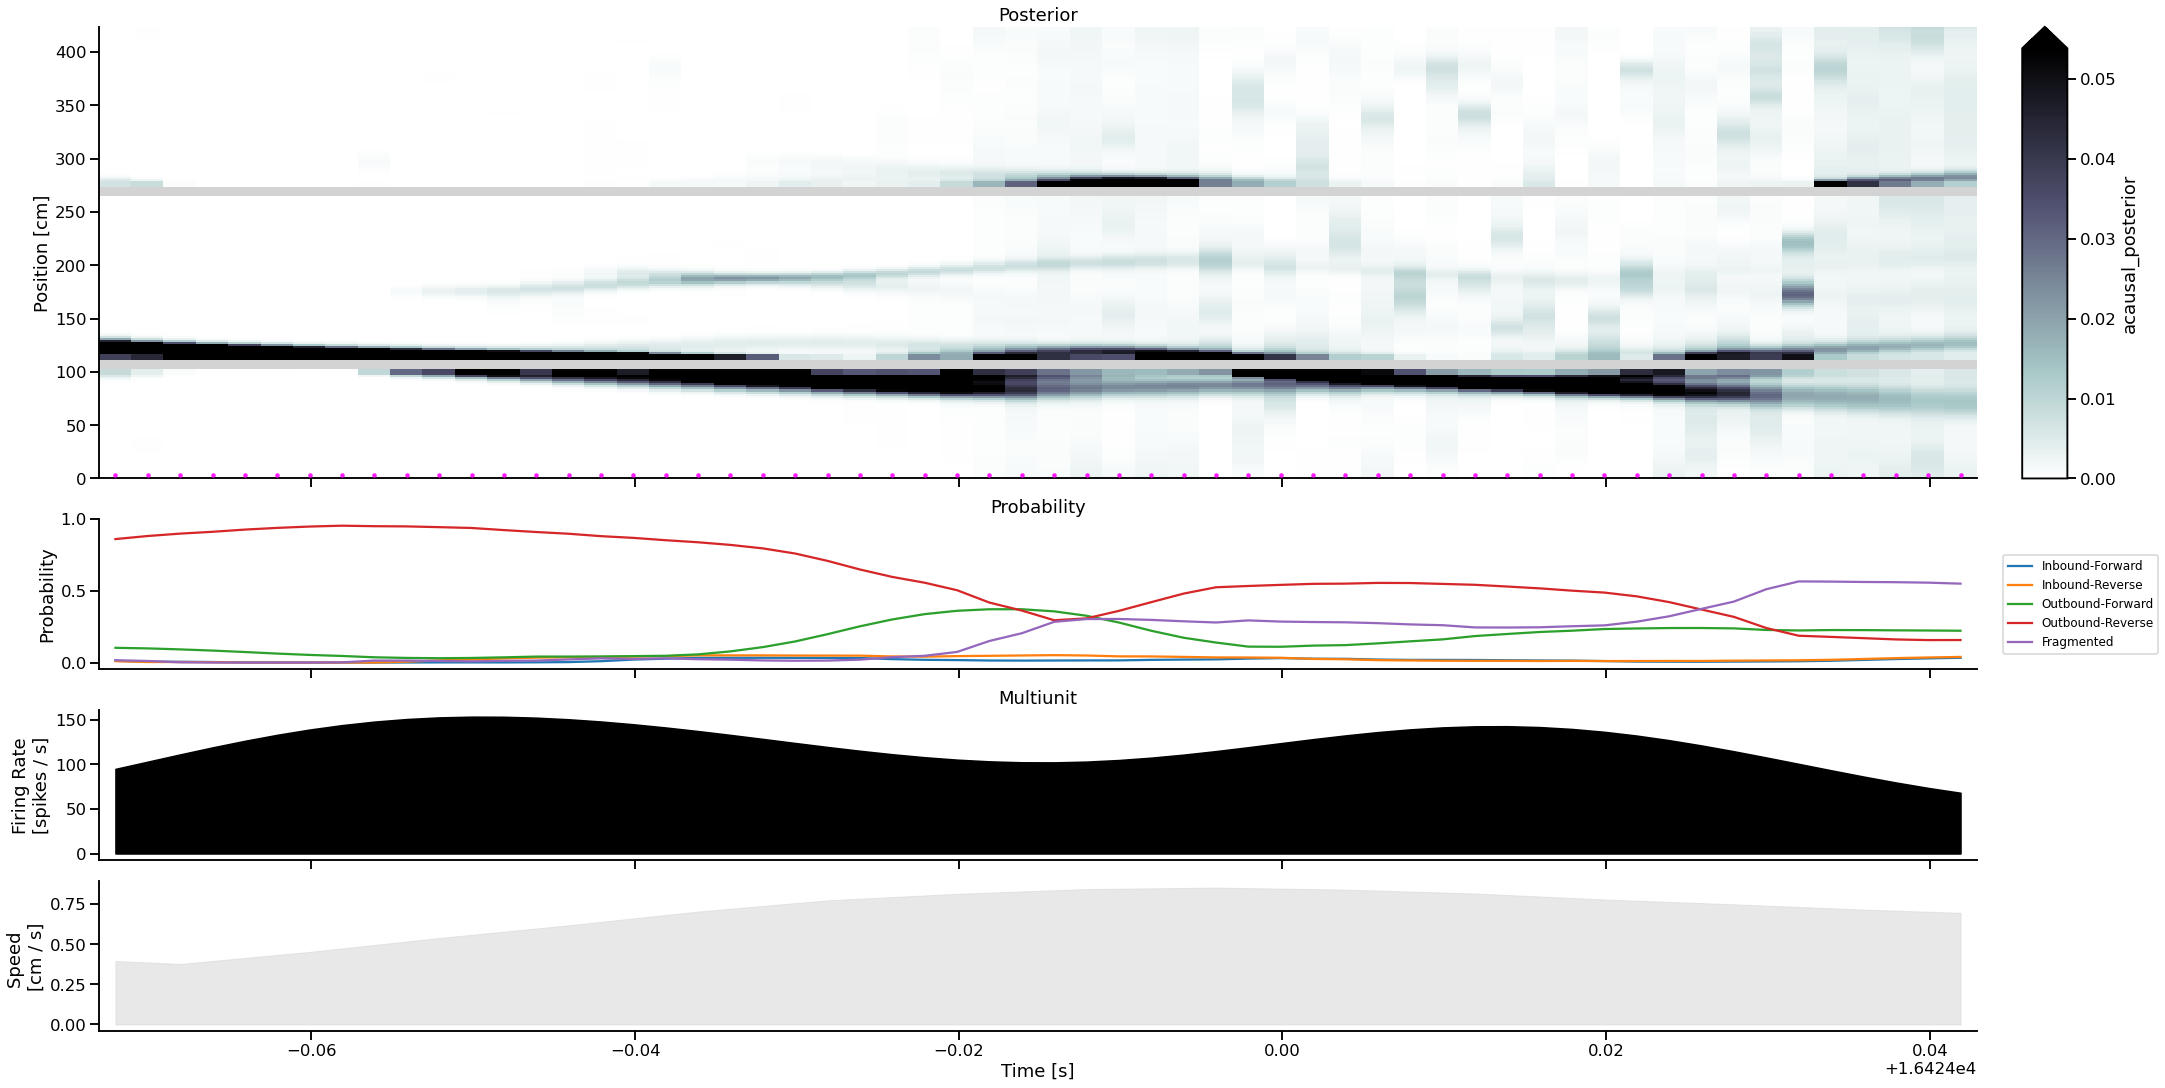

In [133]:
ripple_number = 11

plot_ripple_decode(data, classifier, ripple_number)

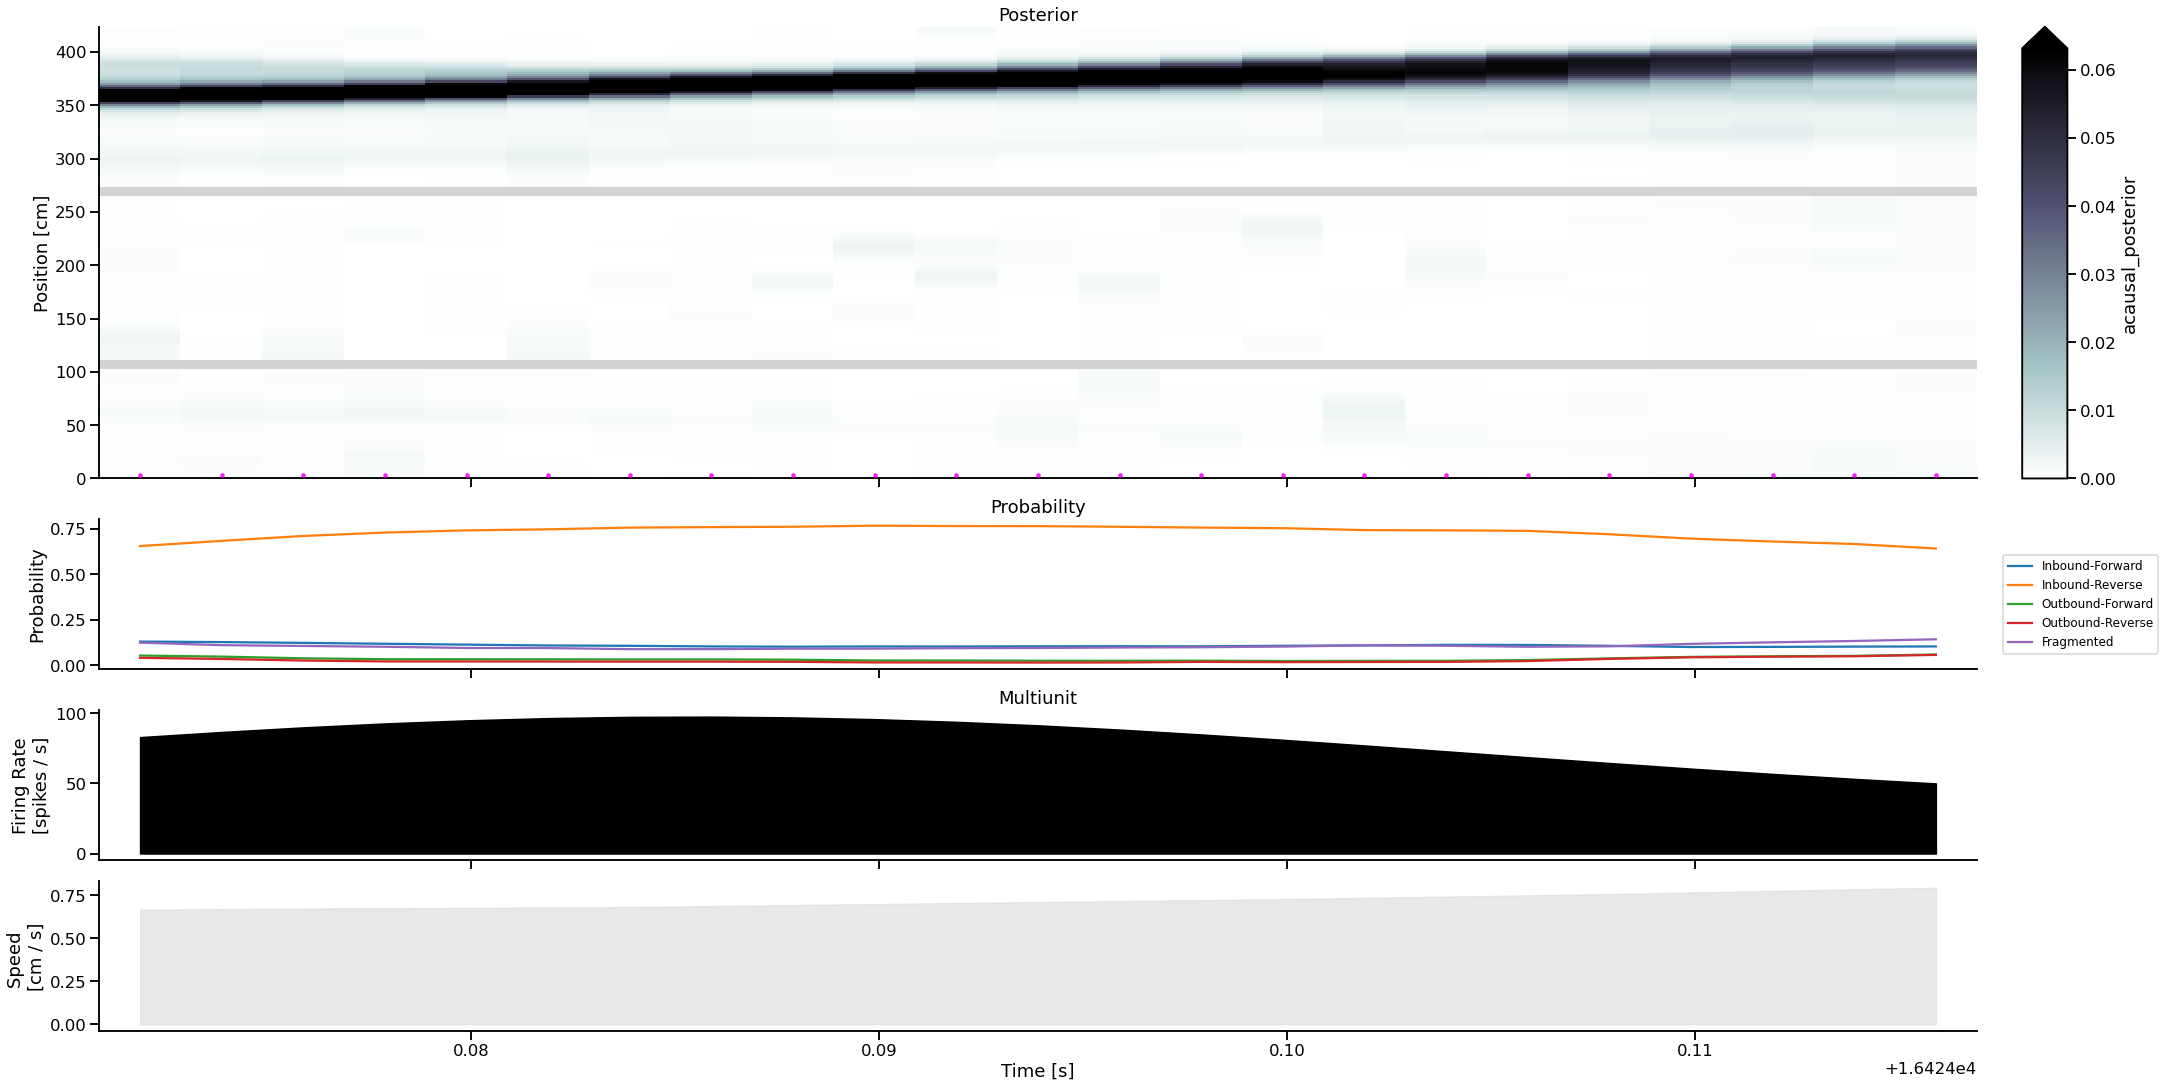

In [134]:
ripple_number = 12

plot_ripple_decode(data, classifier, ripple_number)

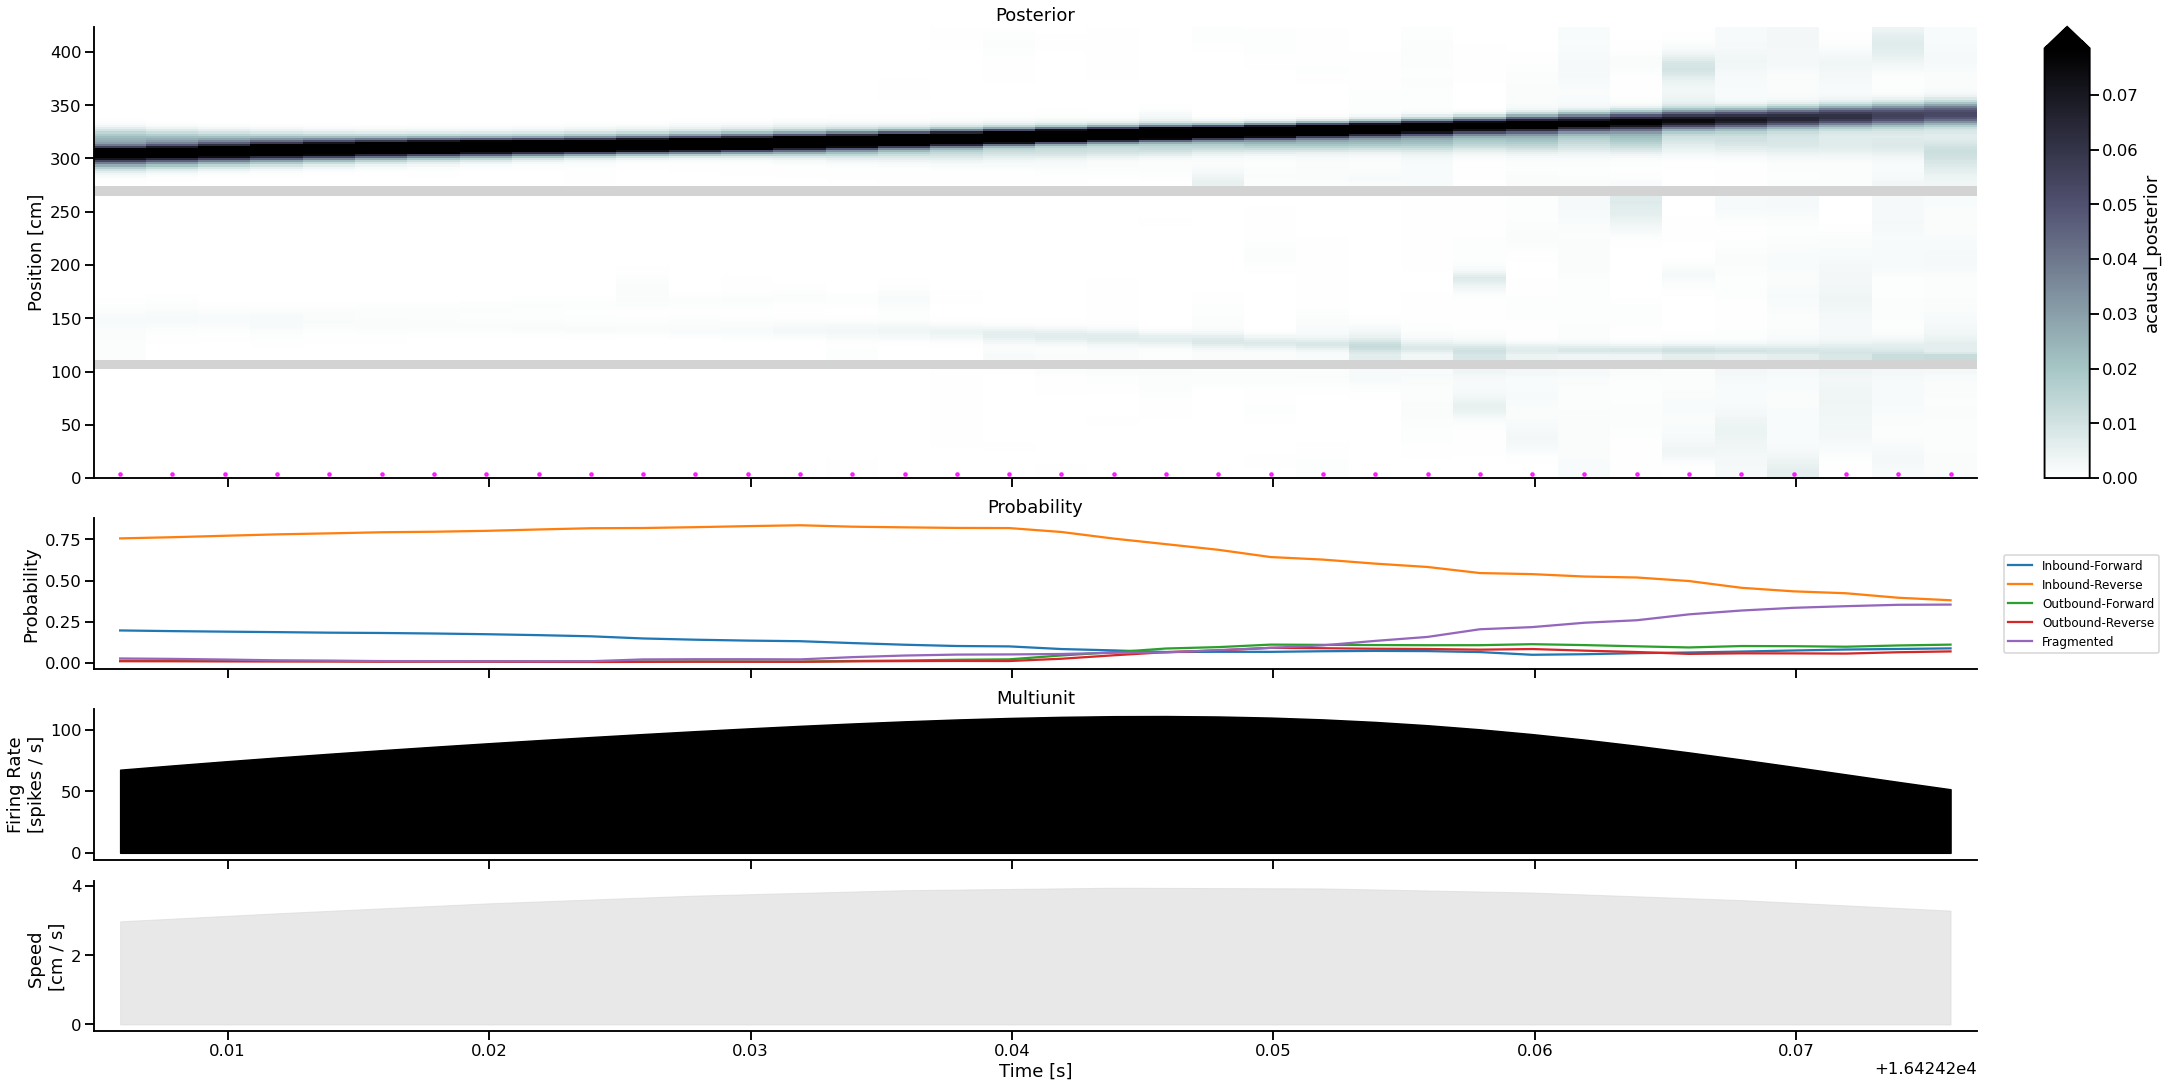

In [135]:
ripple_number = 13

plot_ripple_decode(data, classifier, ripple_number)

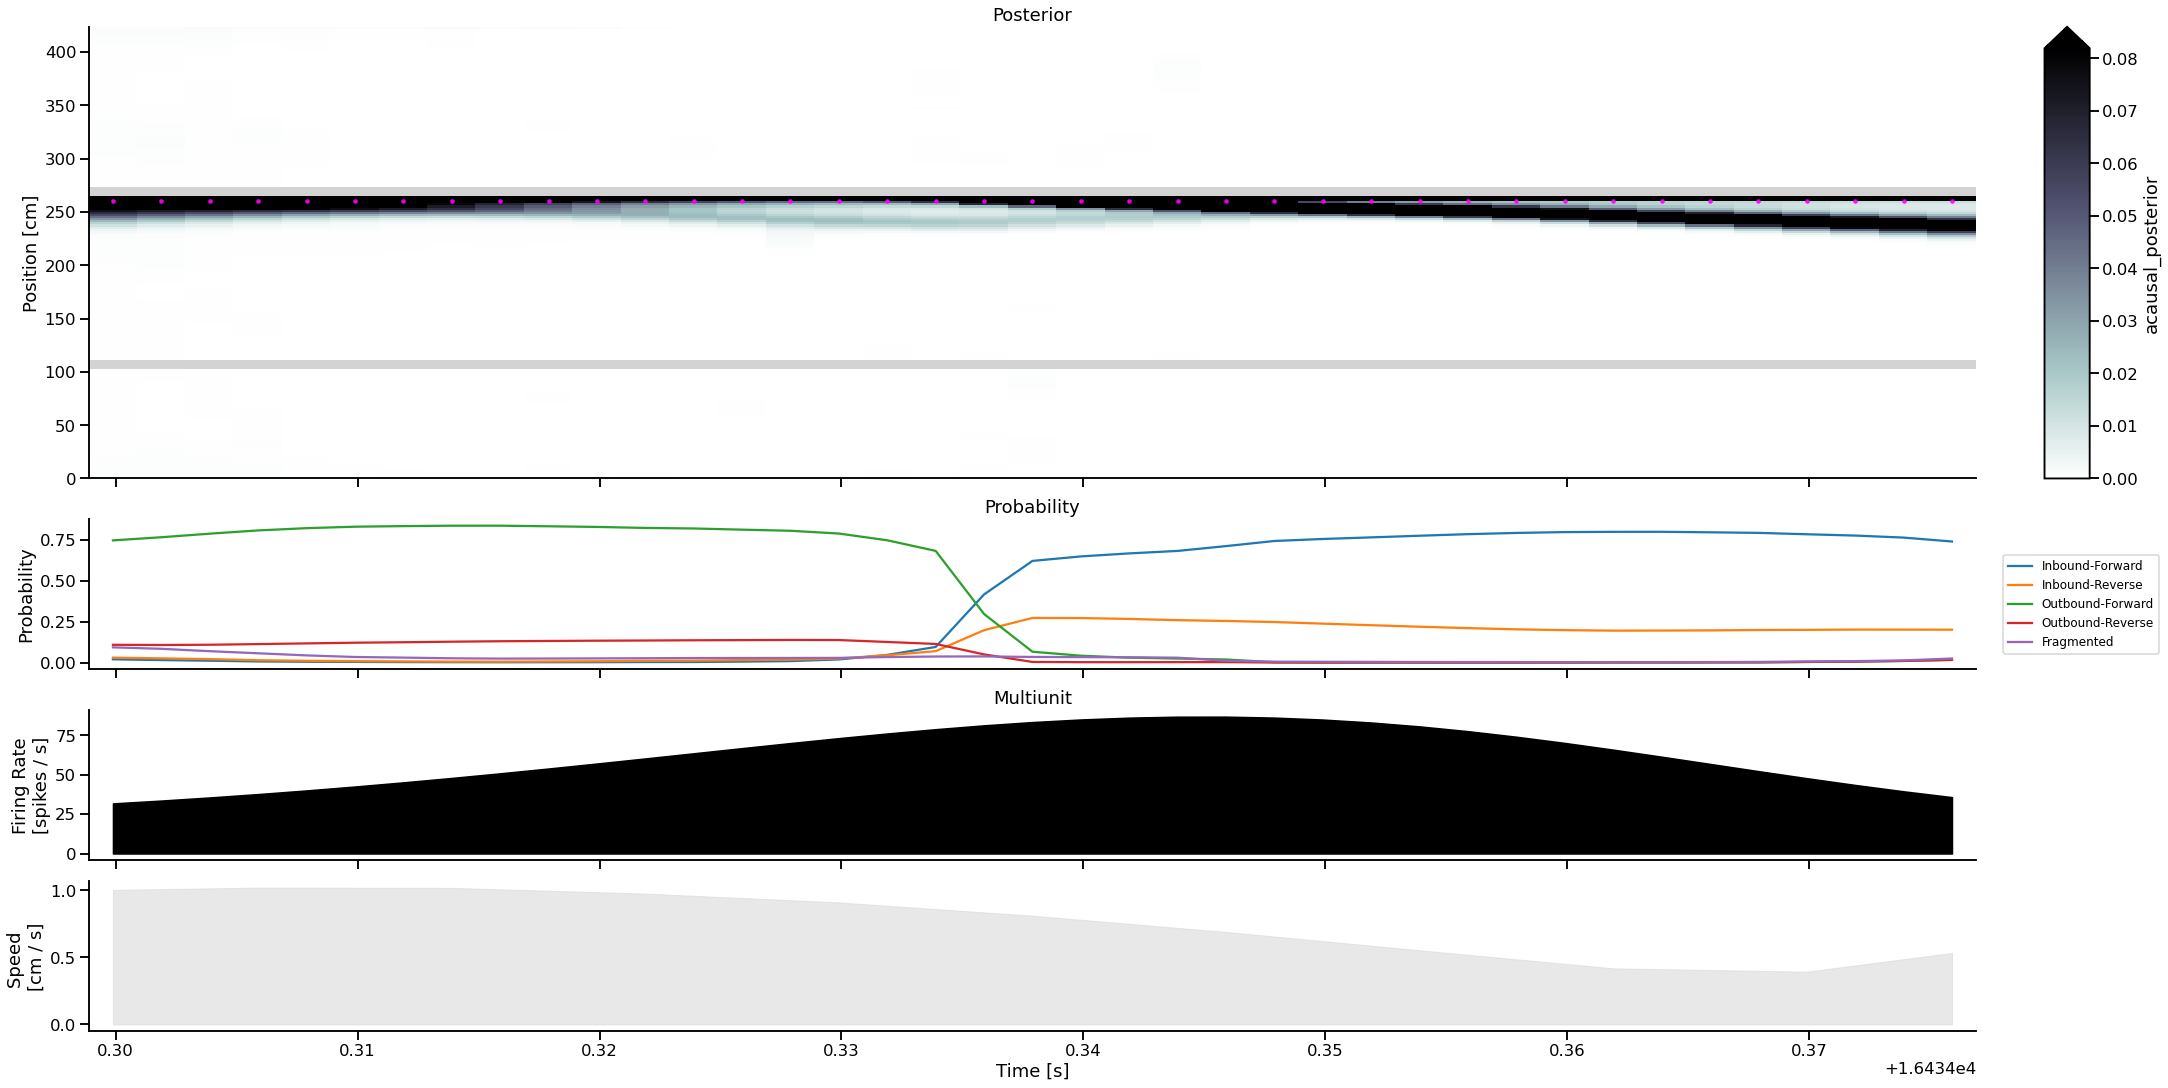

In [136]:
ripple_number = 14

plot_ripple_decode(data, classifier, ripple_number)

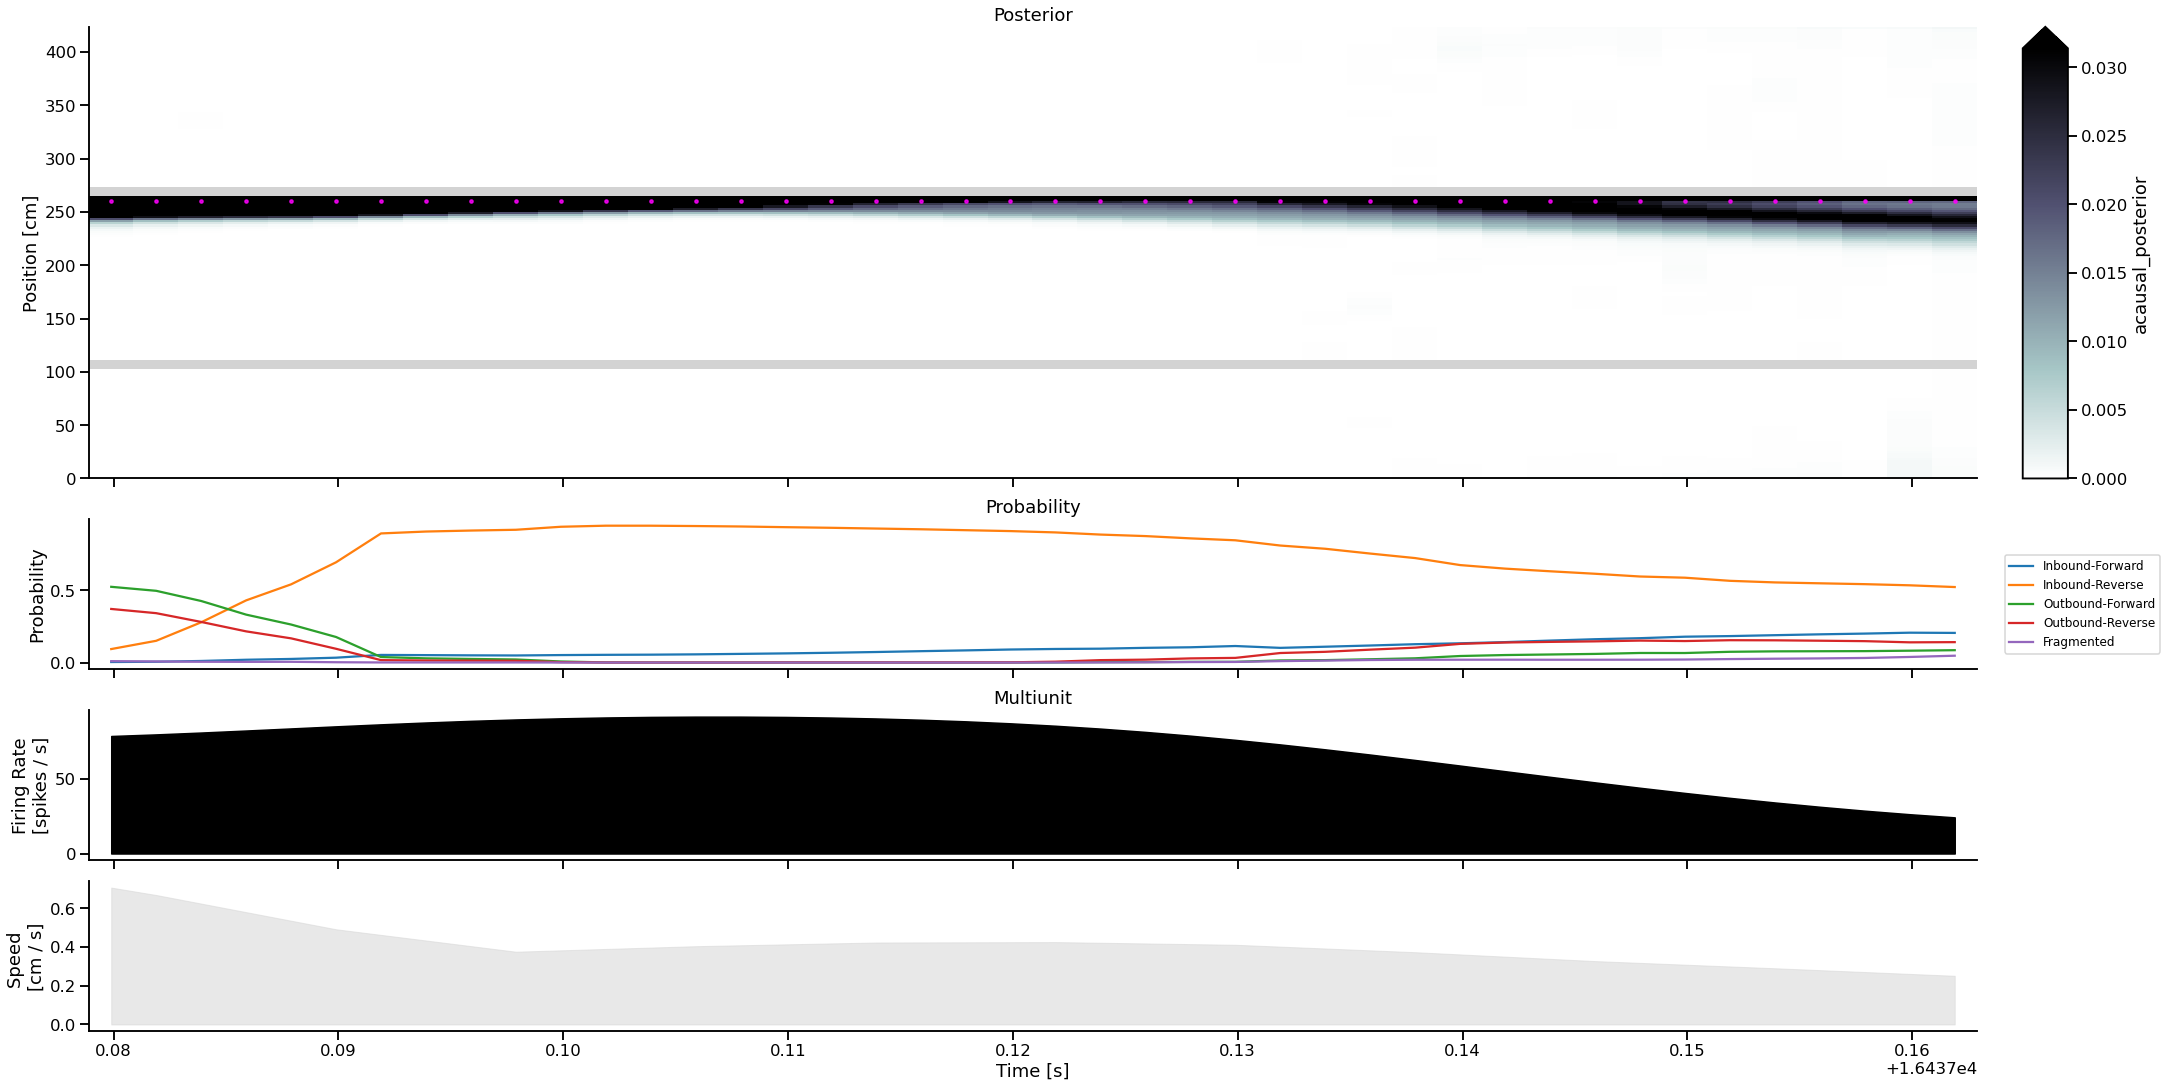

In [137]:
ripple_number = 15

plot_ripple_decode(data, classifier, ripple_number)

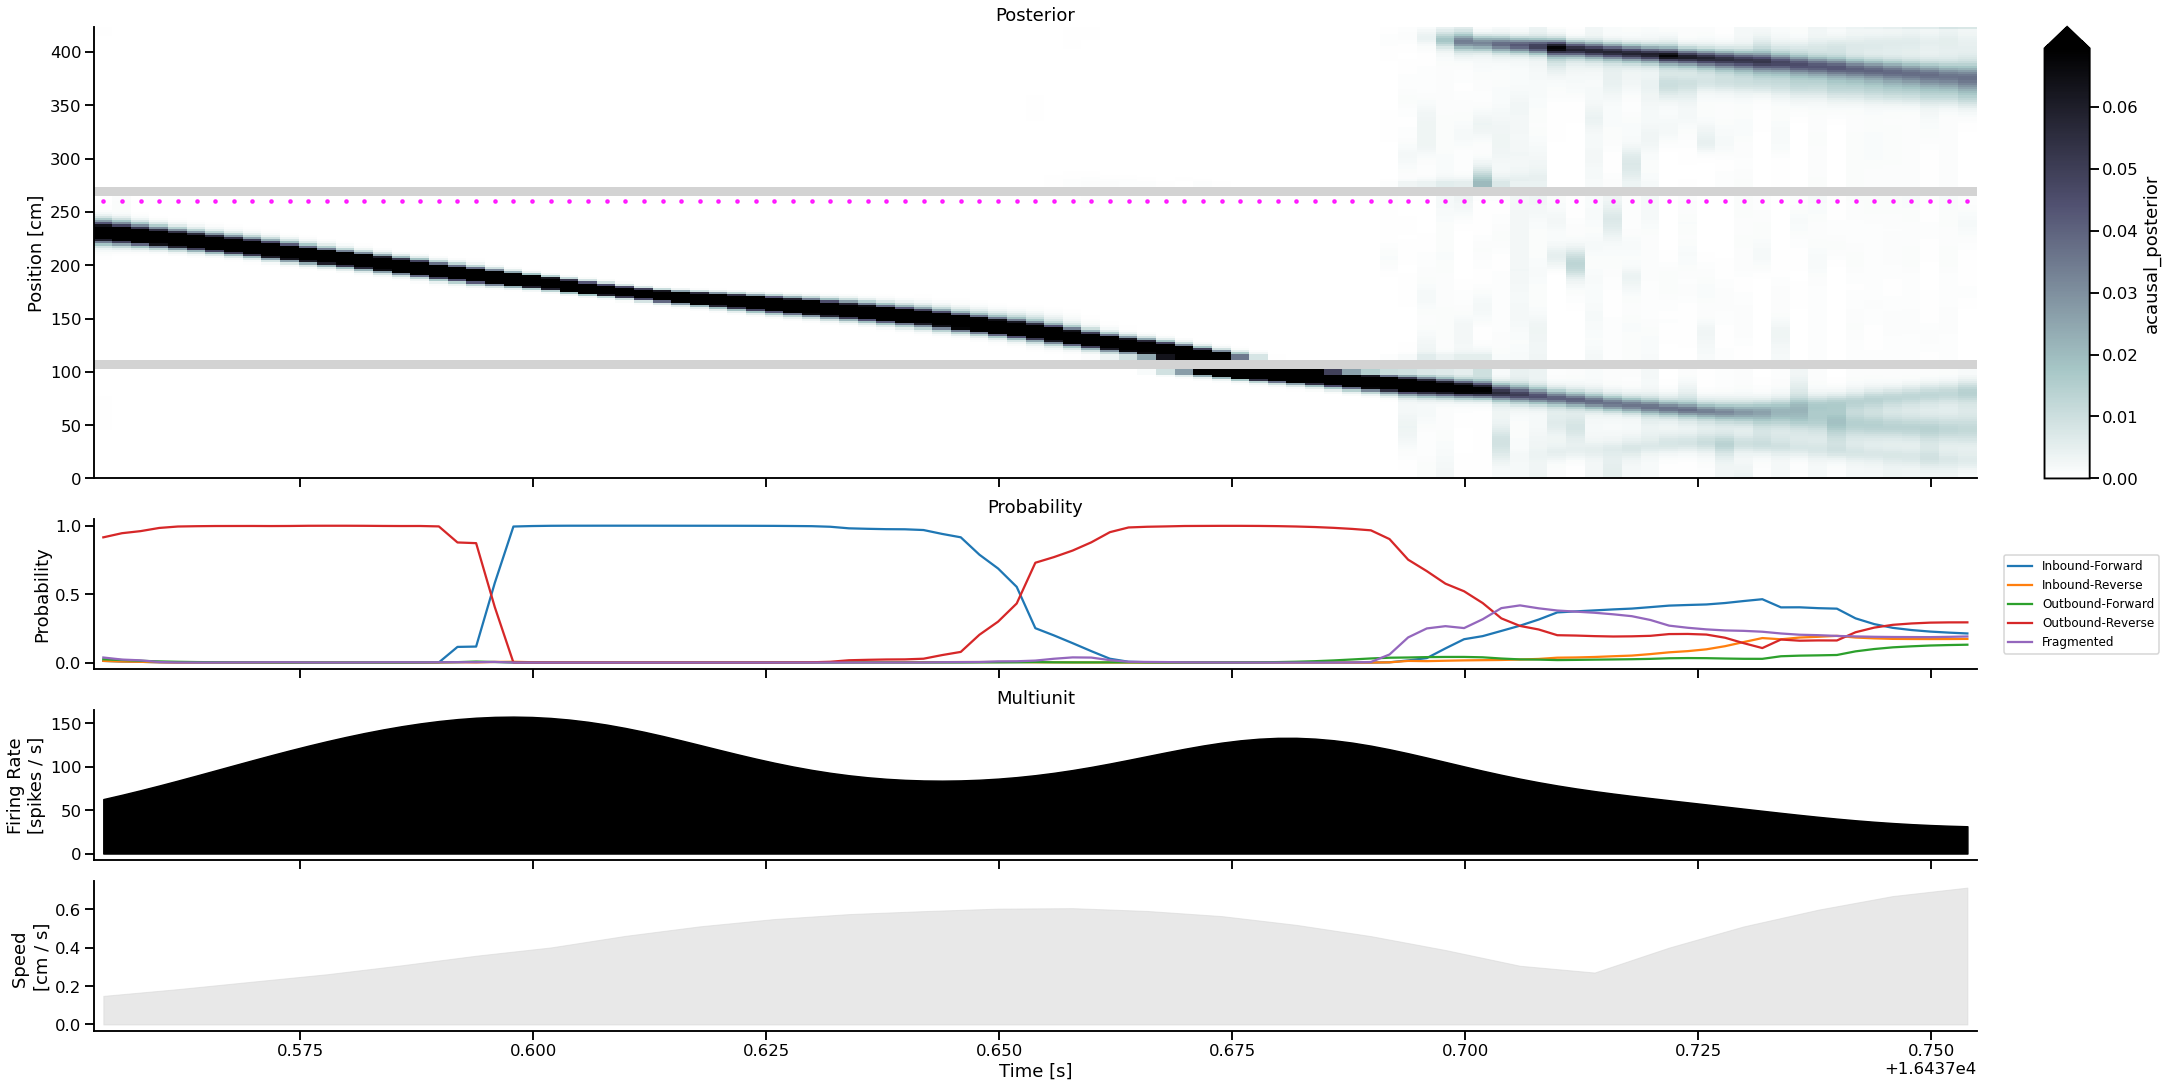

In [138]:
ripple_number = 16

plot_ripple_decode(data, classifier, ripple_number)

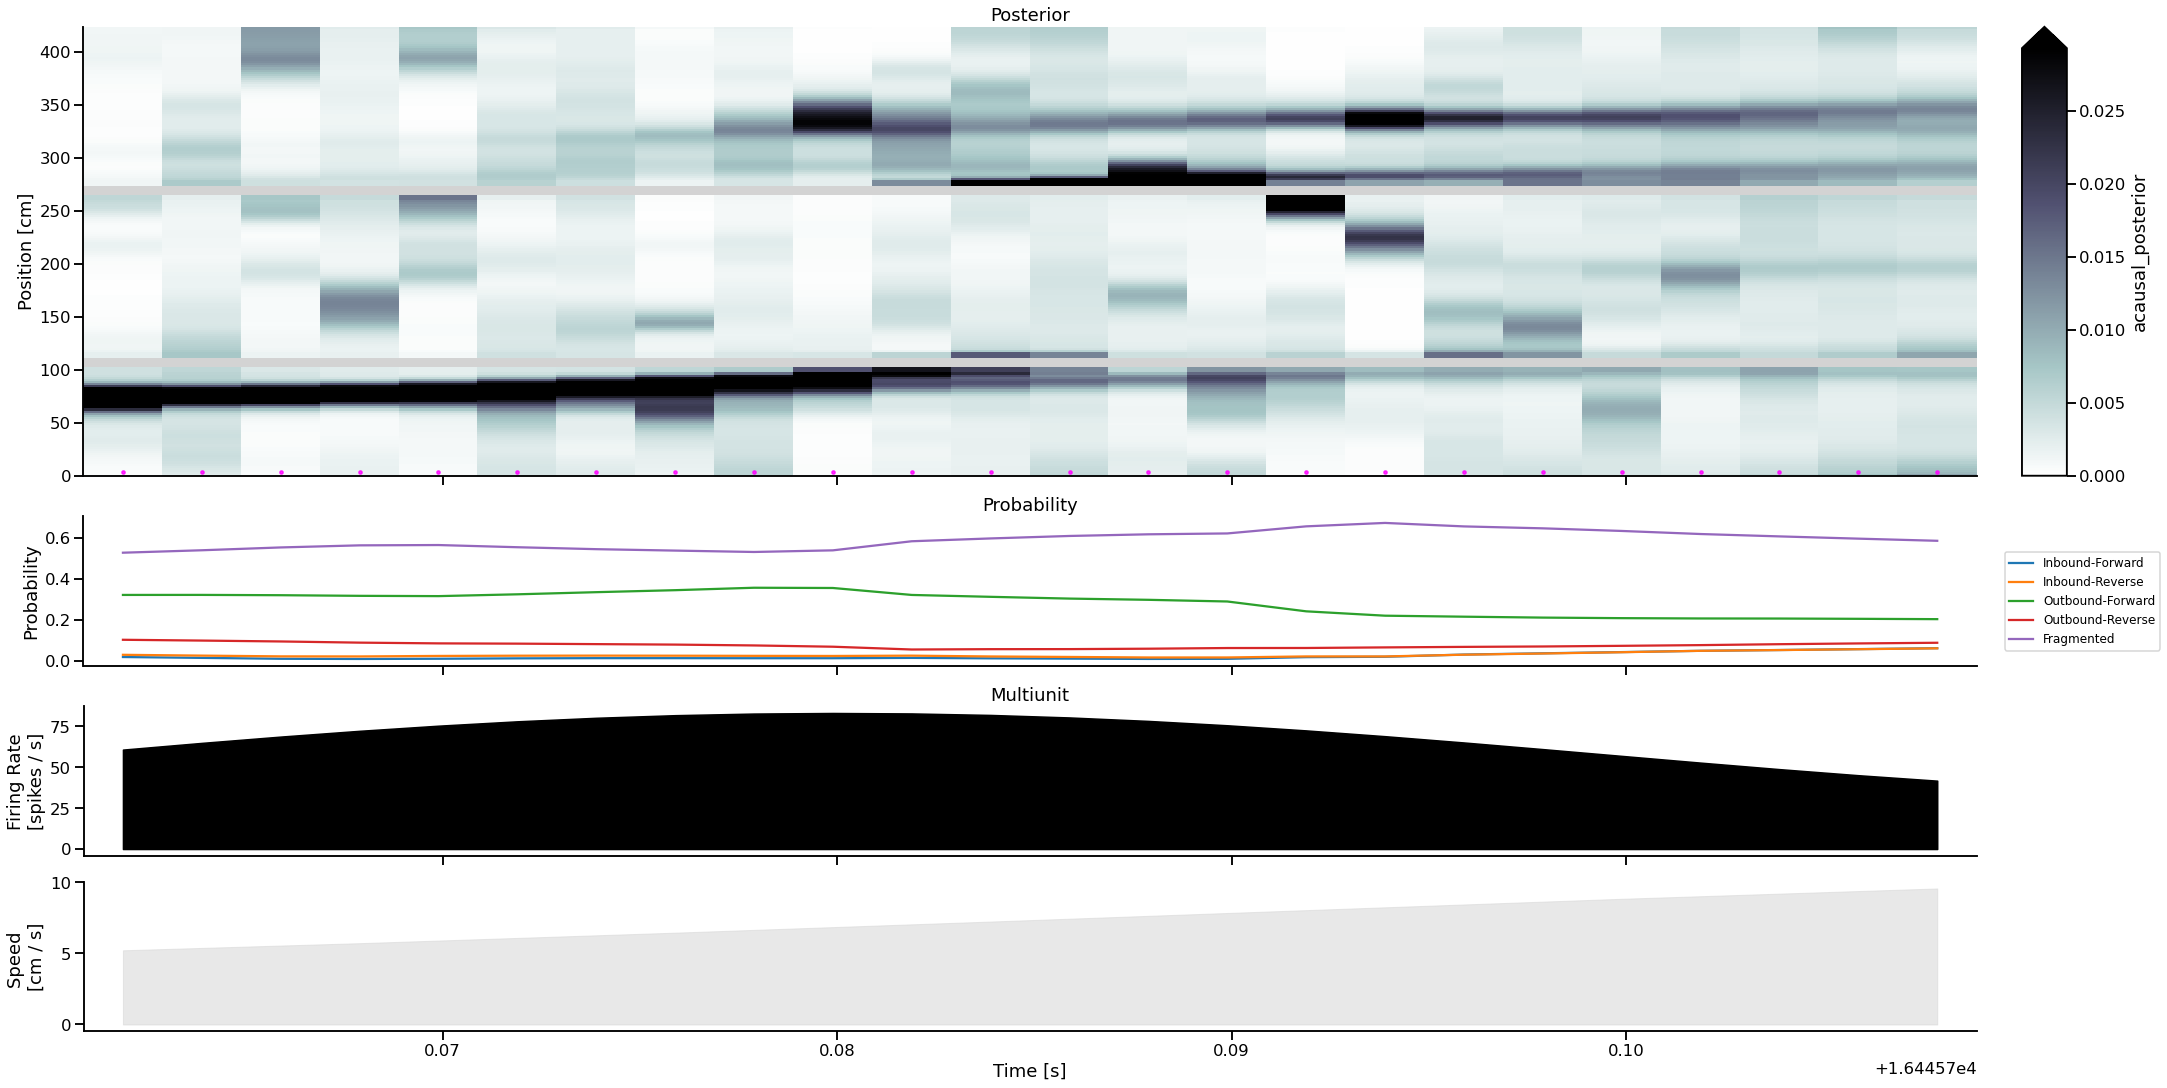

In [139]:
ripple_number = 17

plot_ripple_decode(data, classifier, ripple_number)

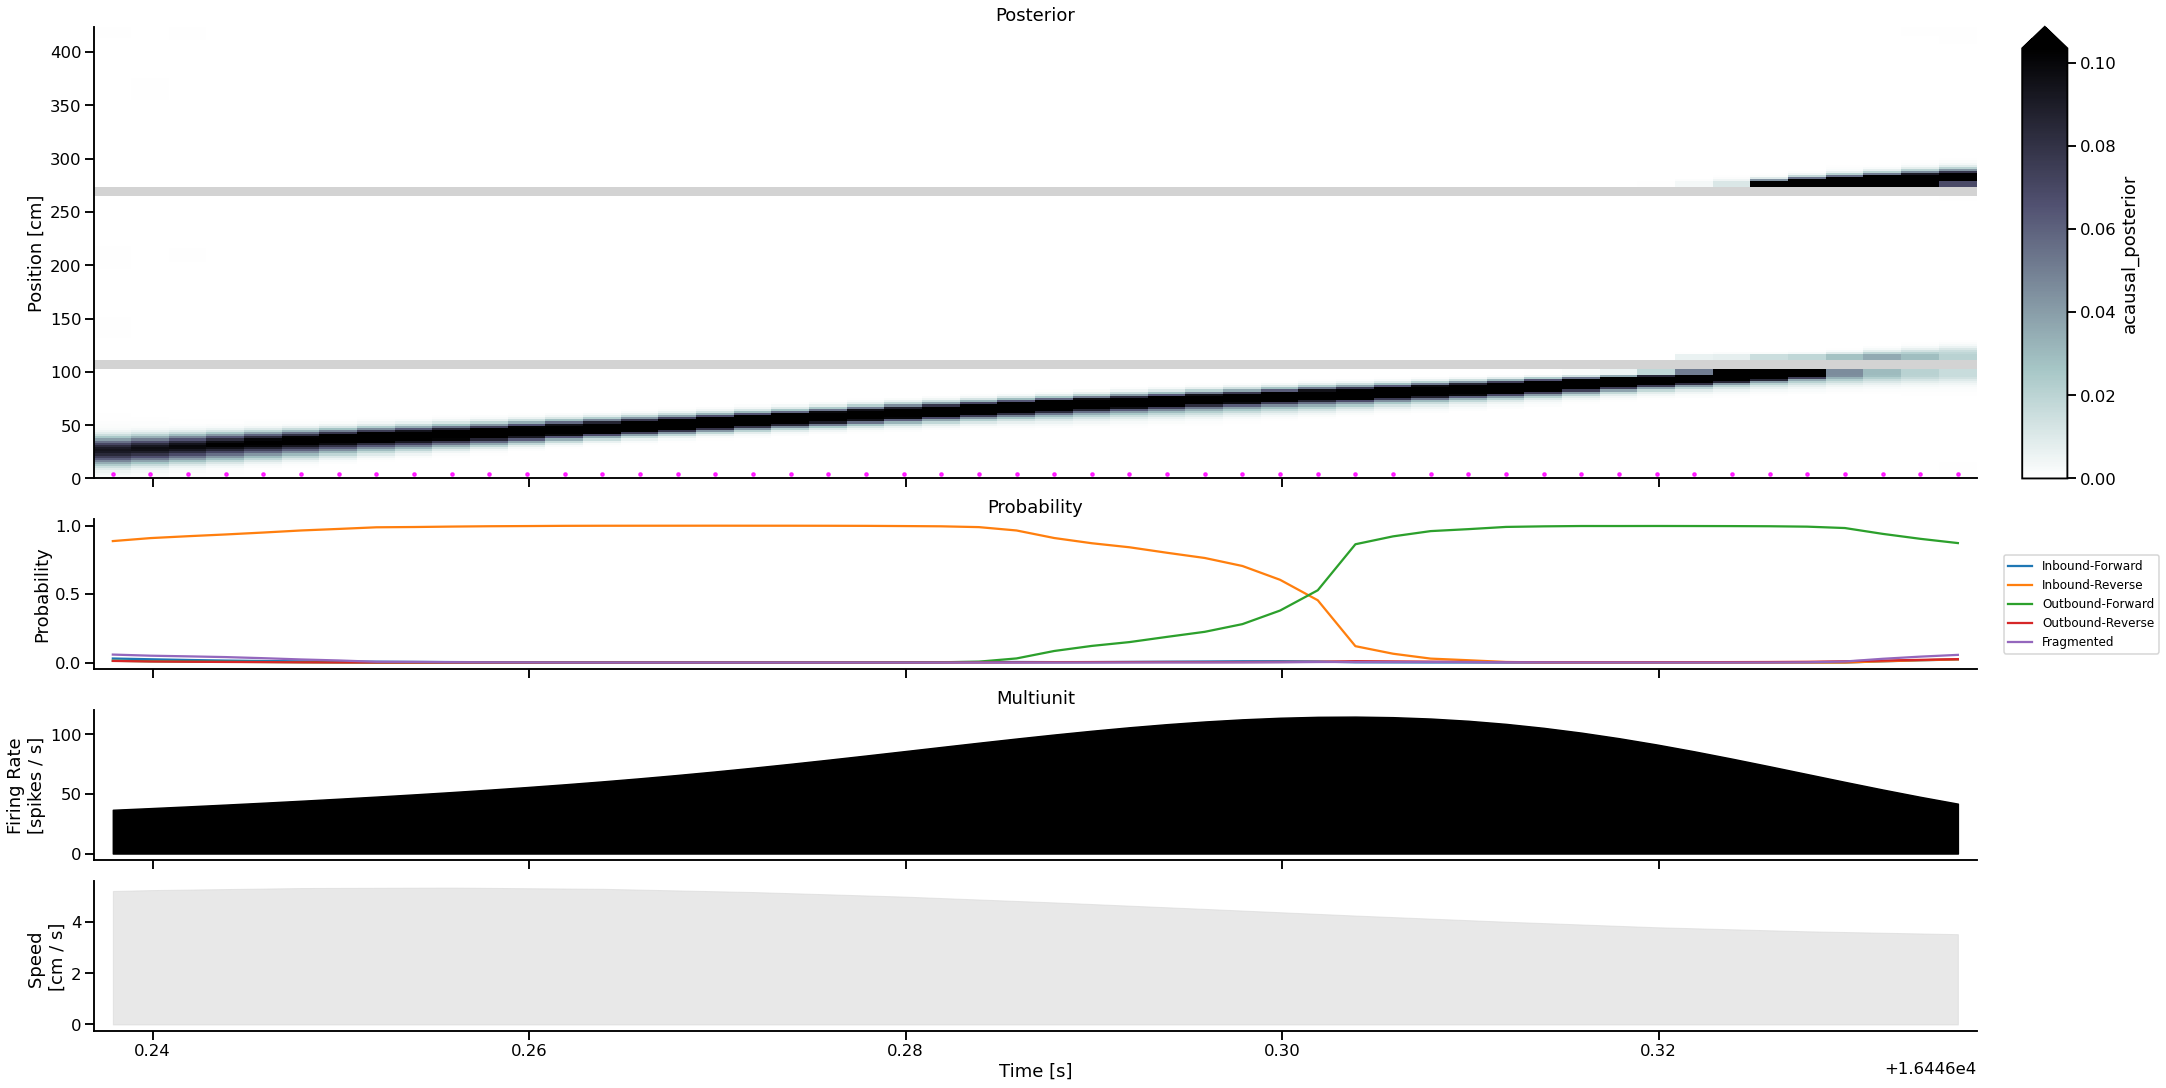

In [140]:
ripple_number = 18

plot_ripple_decode(data, classifier, ripple_number)

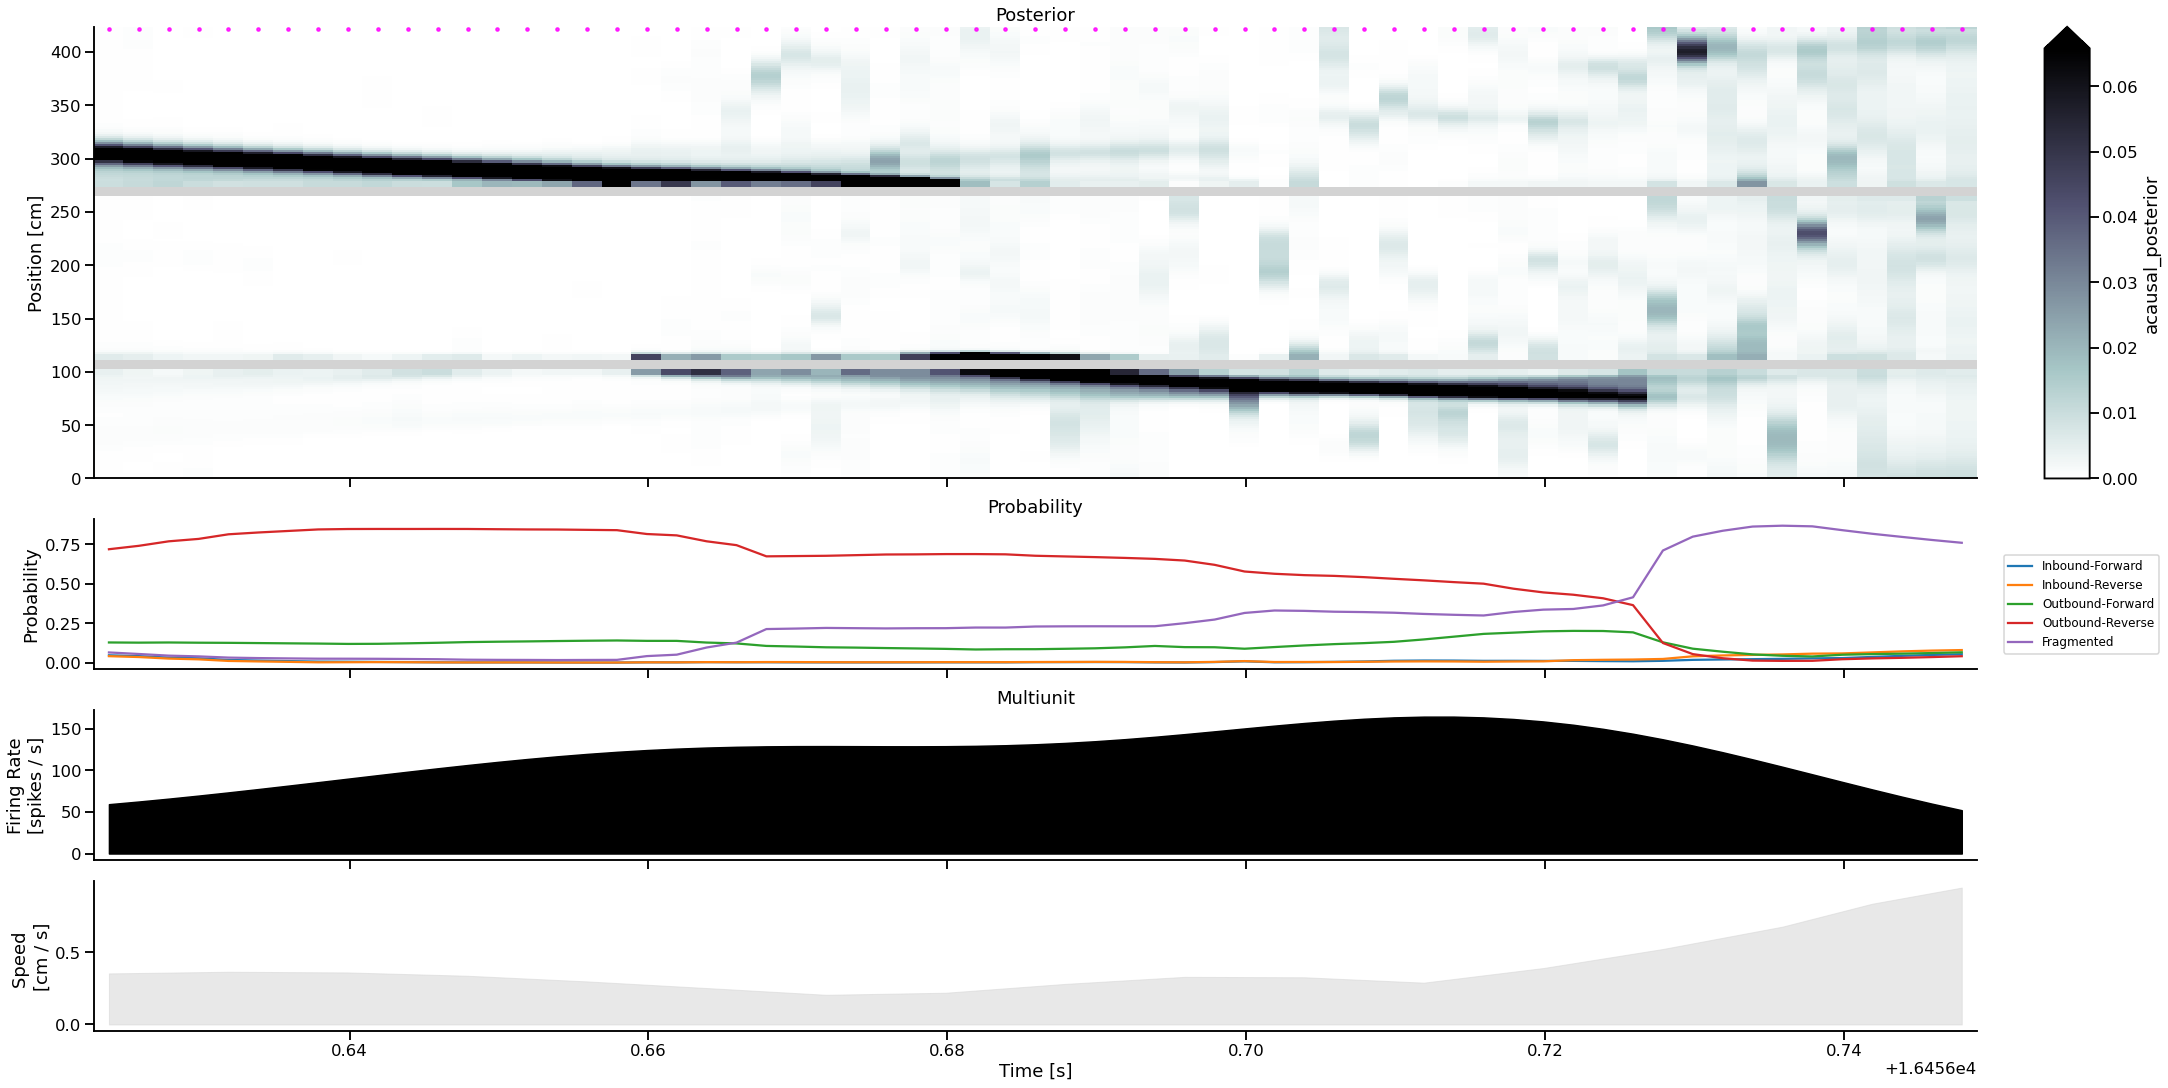

In [141]:
ripple_number = 19

plot_ripple_decode(data, classifier, ripple_number)

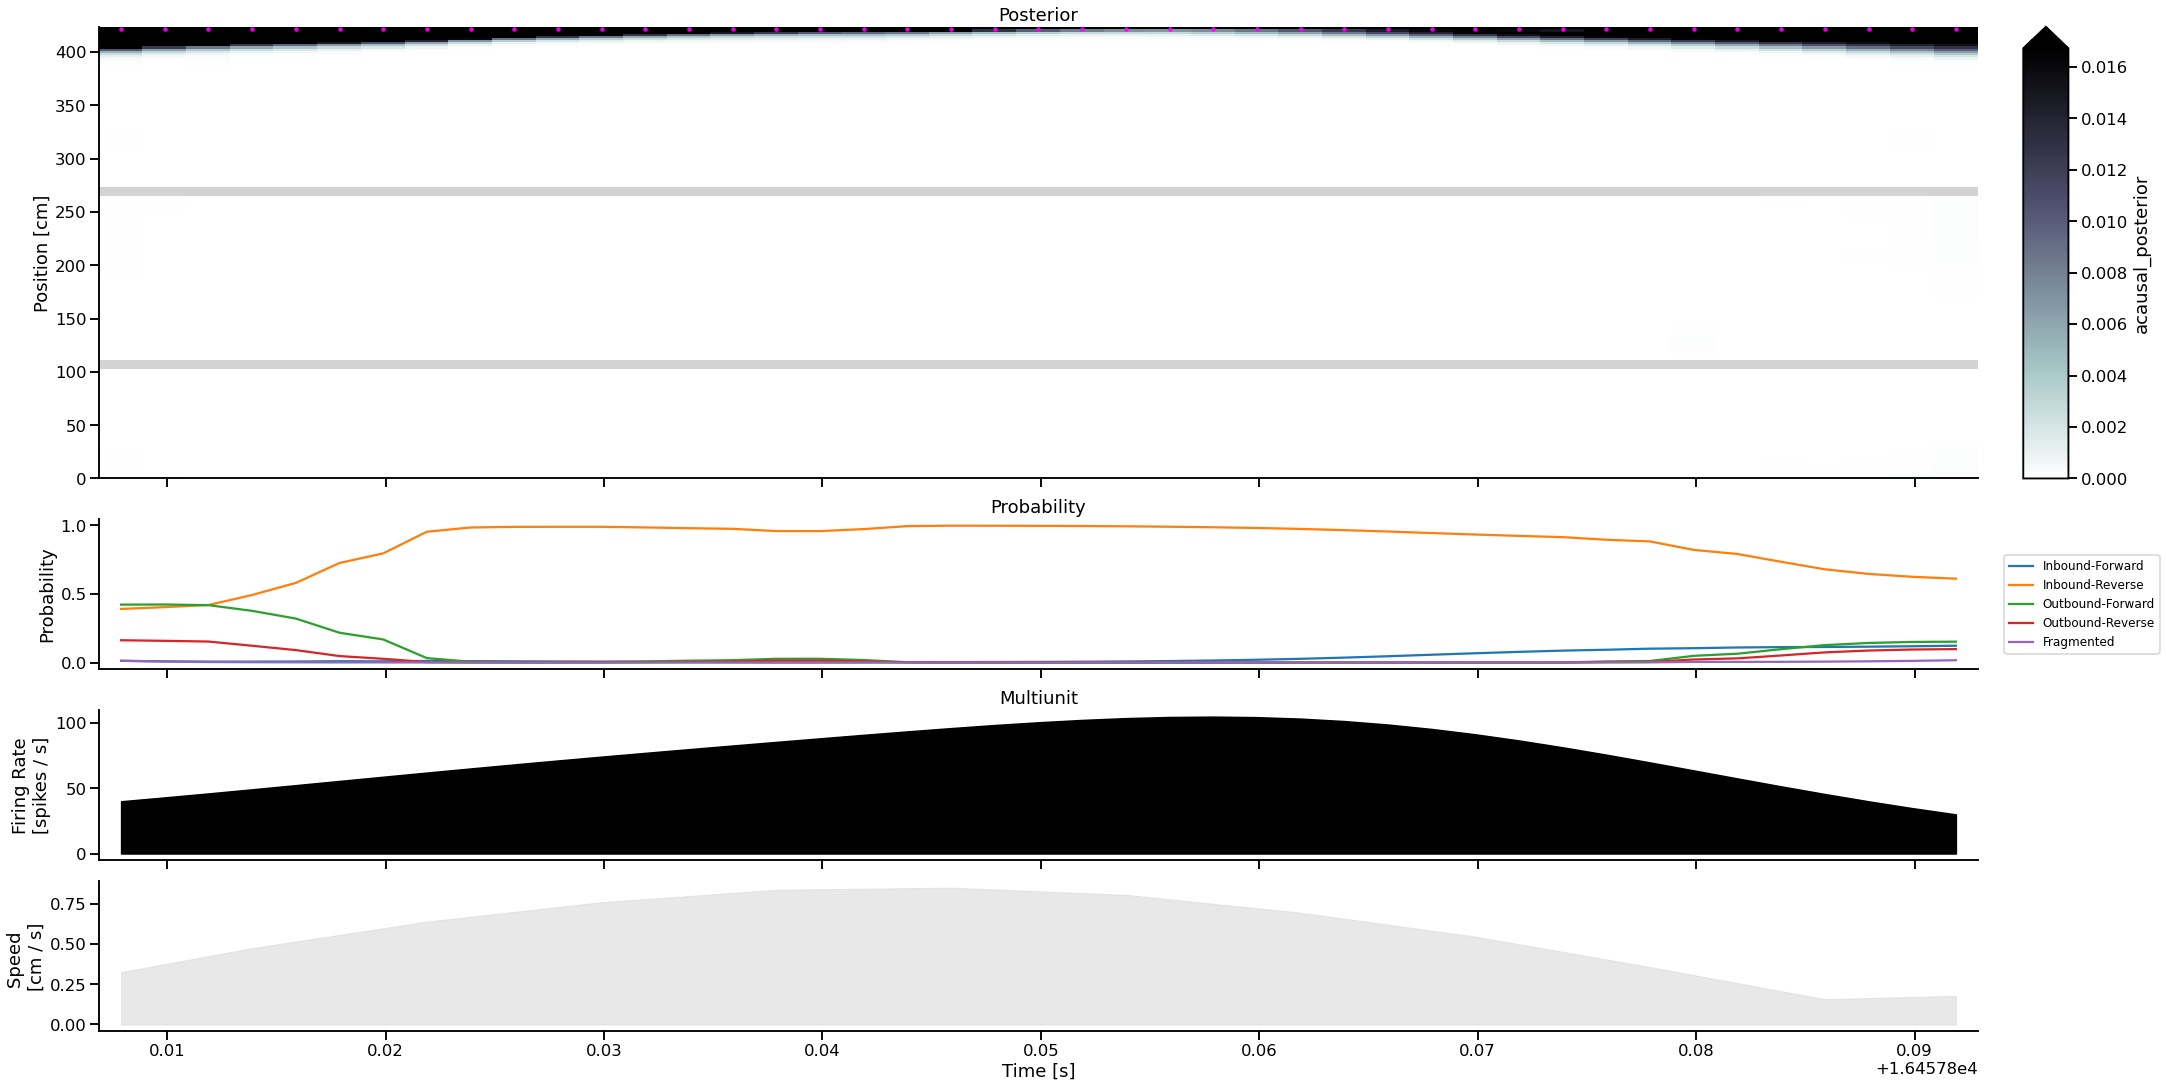

In [142]:
ripple_number = 20

plot_ripple_decode(data, classifier, ripple_number)

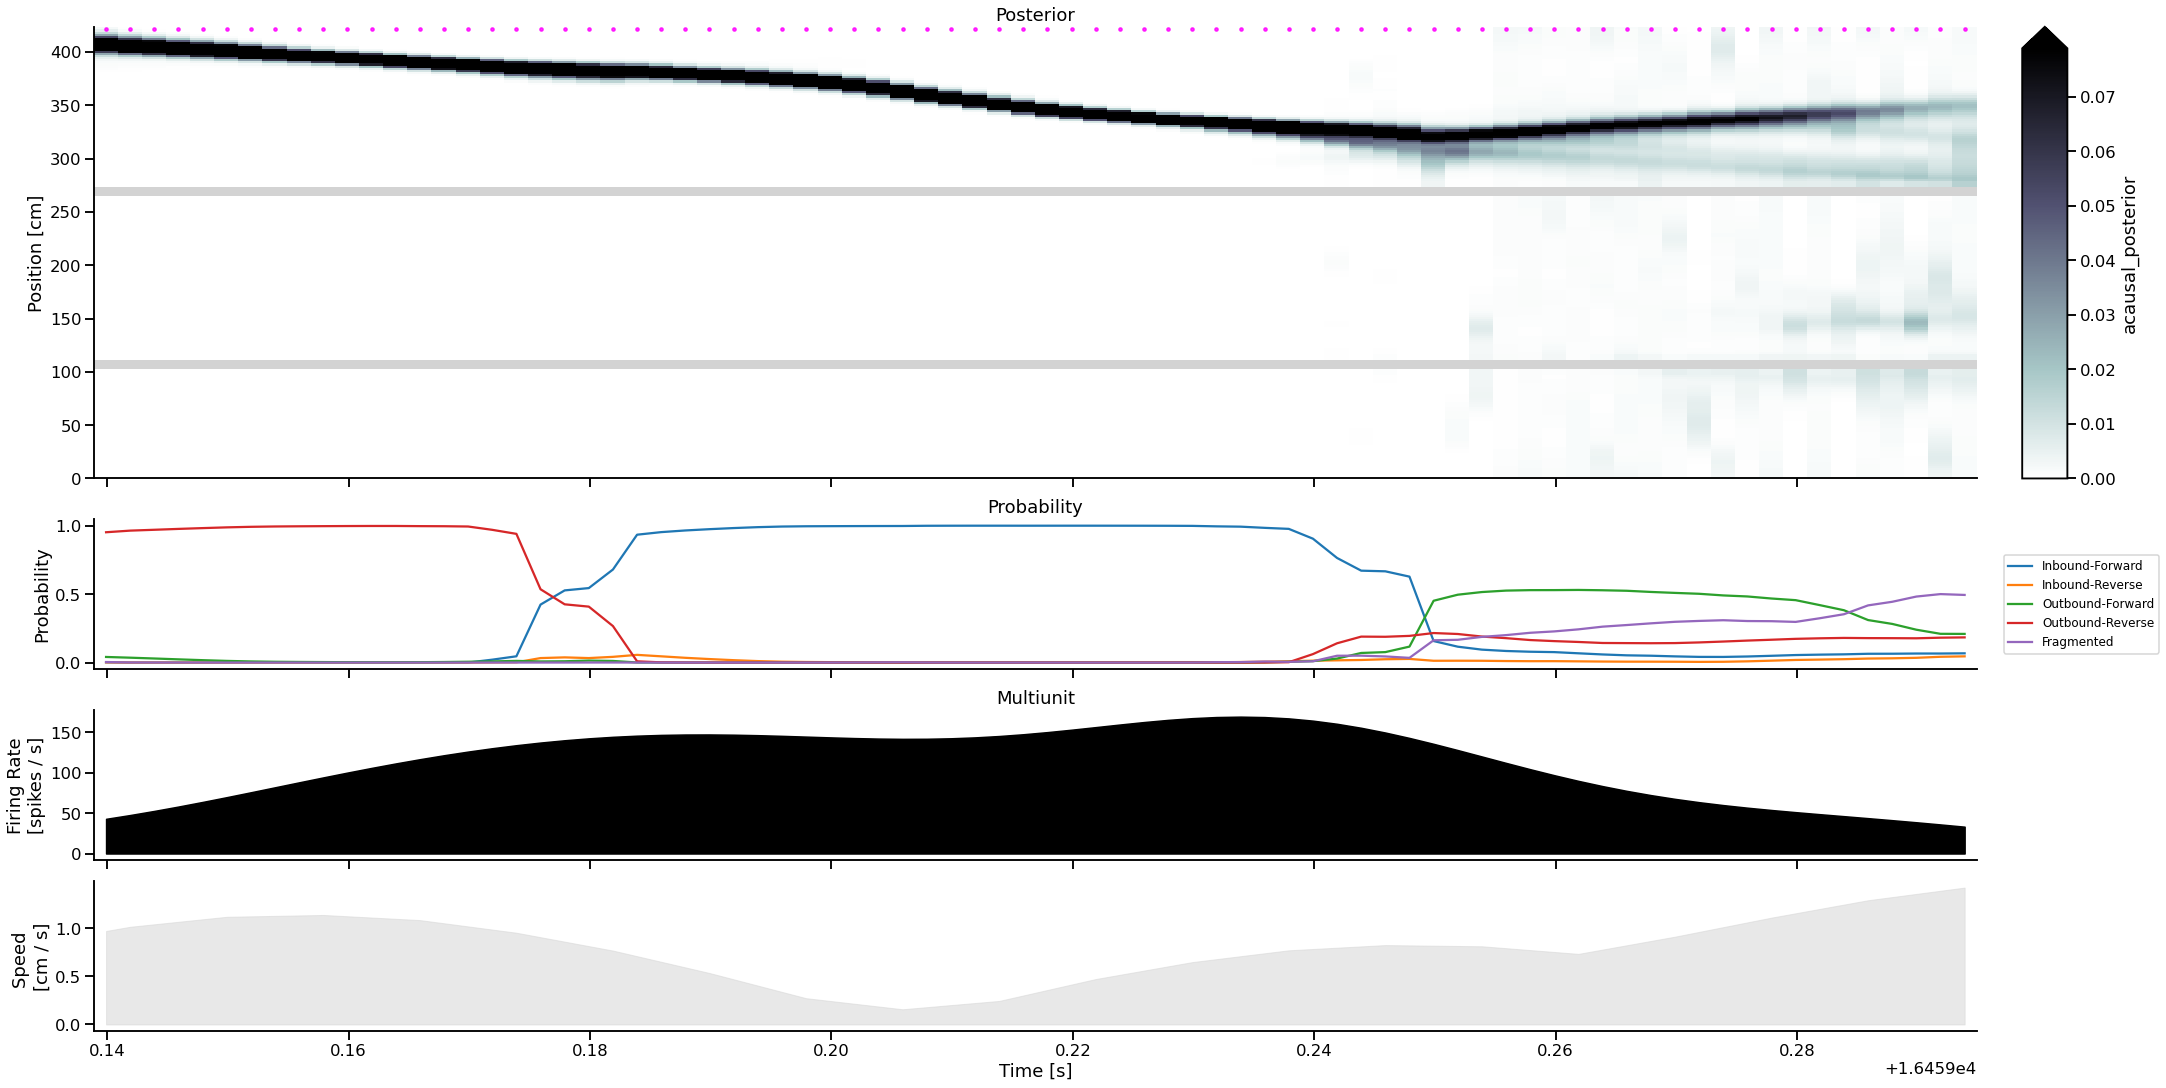

In [143]:
ripple_number = 21

plot_ripple_decode(data, classifier, ripple_number)

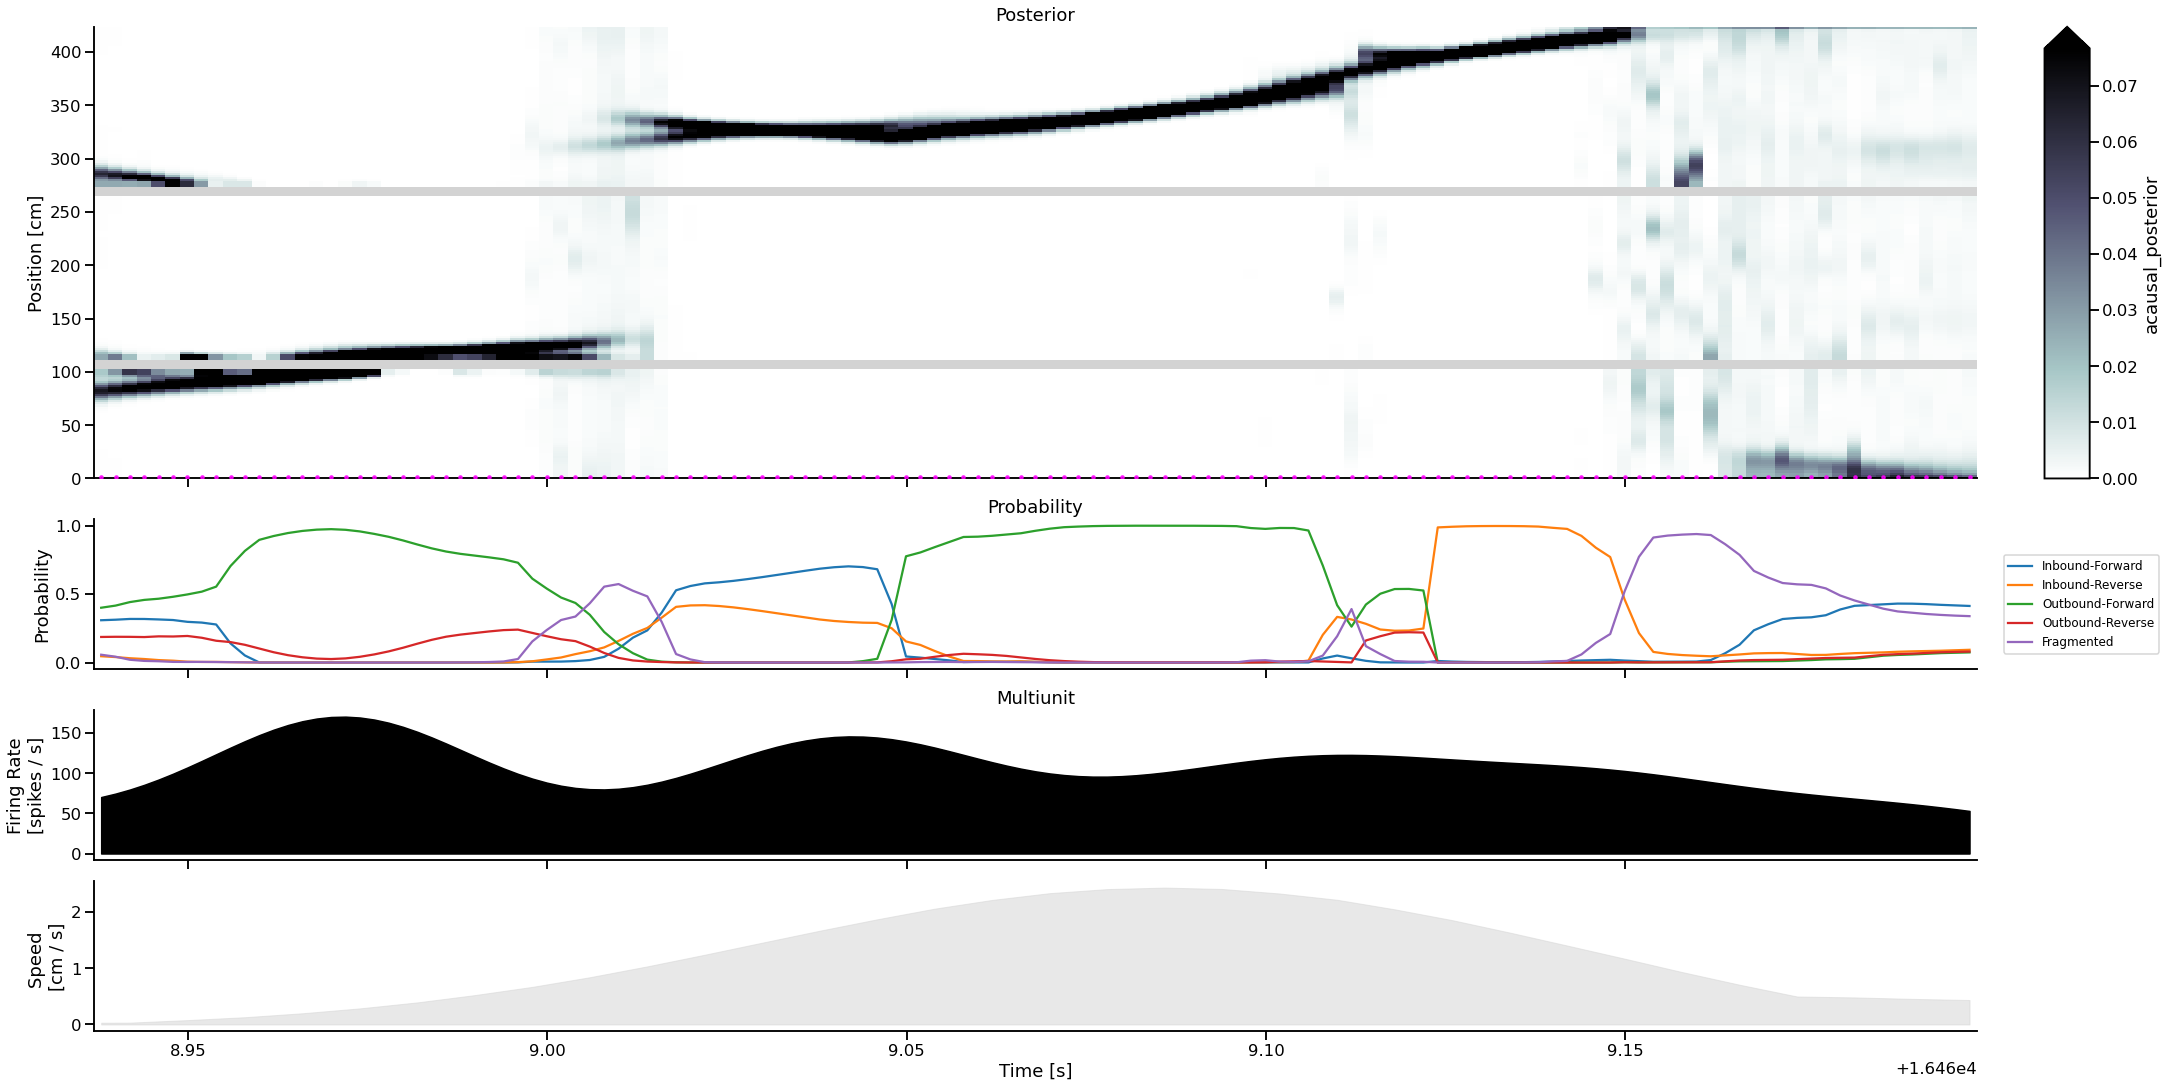

In [144]:
ripple_number = 22

plot_ripple_decode(data, classifier, ripple_number)

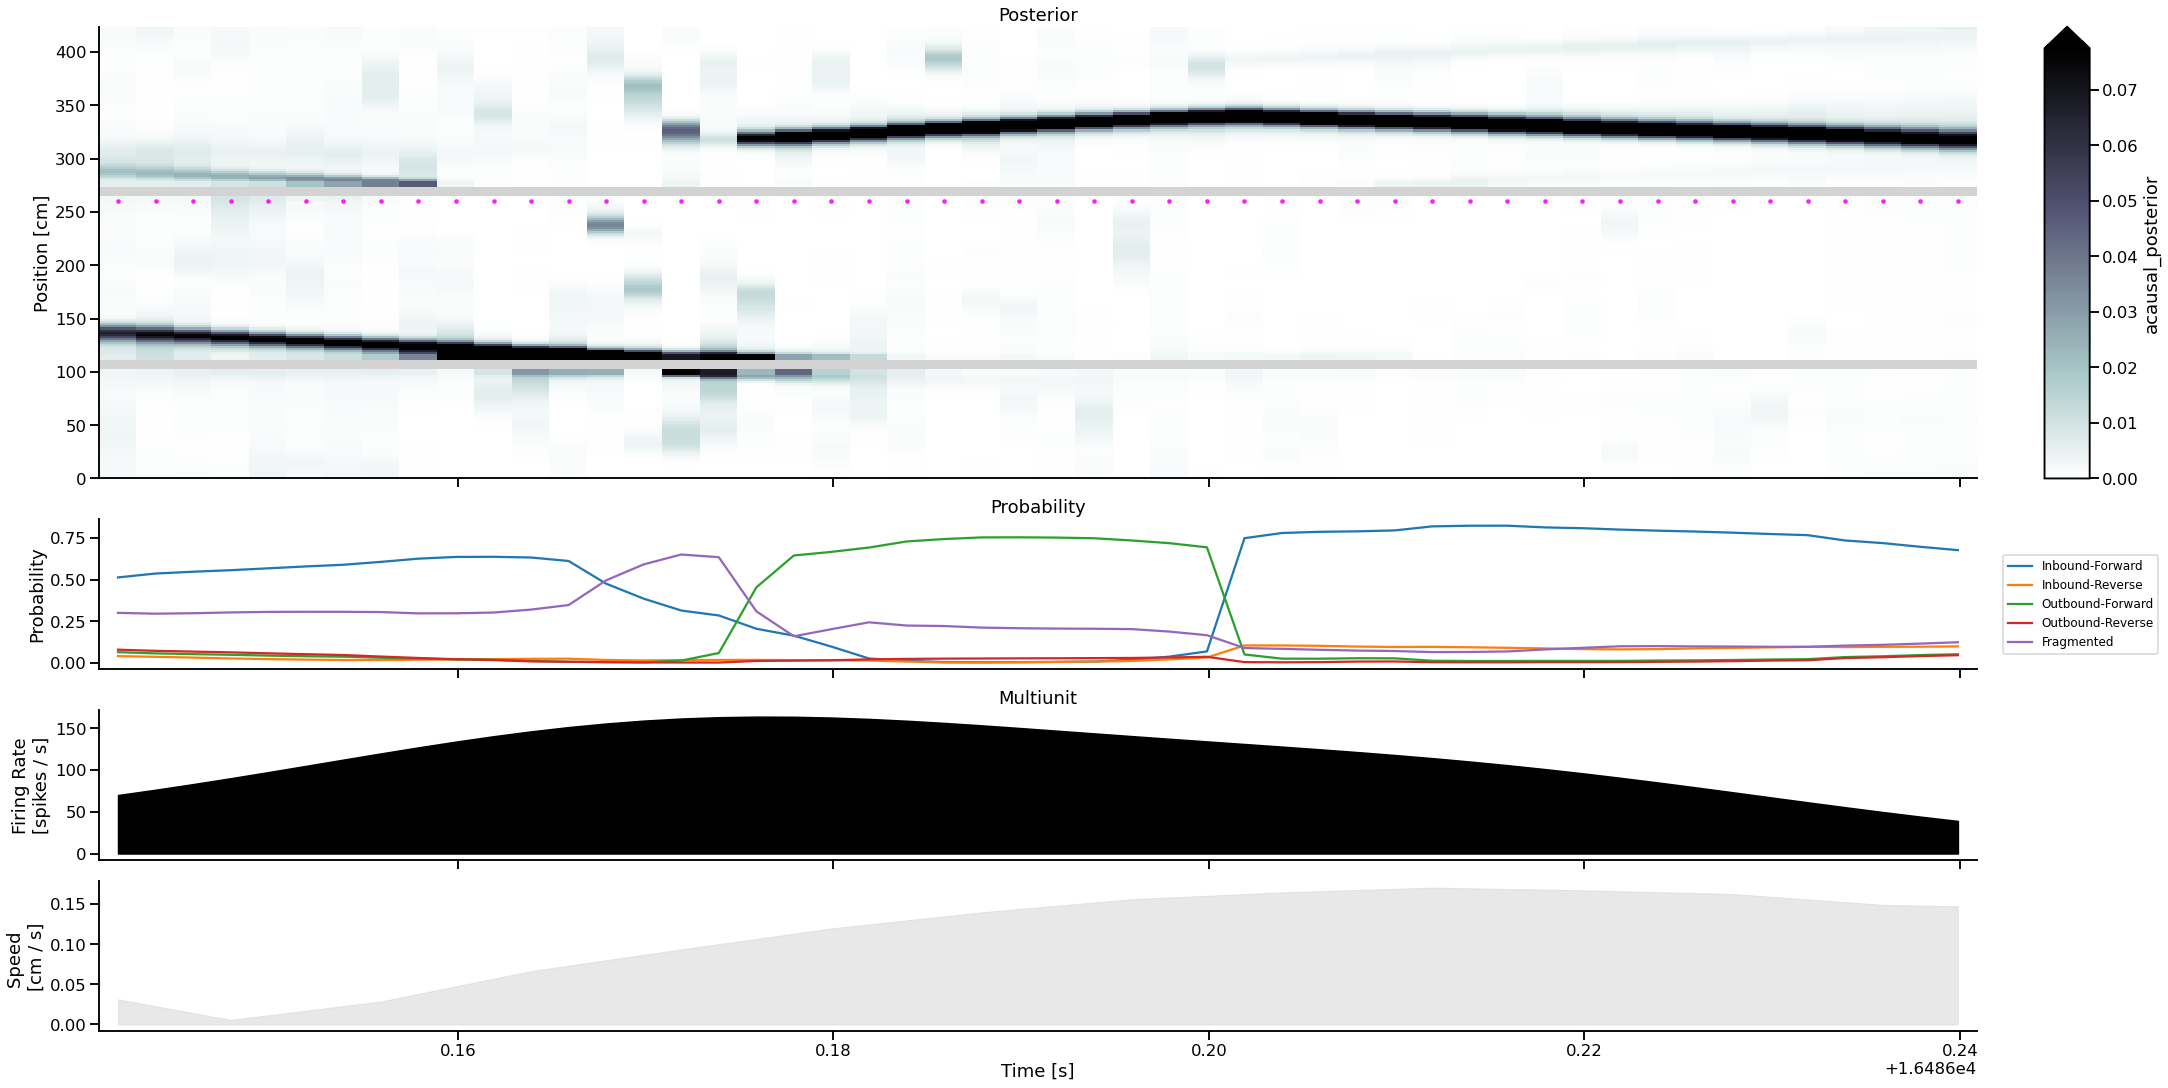

In [145]:
ripple_number = 23

plot_ripple_decode(data, classifier, ripple_number)

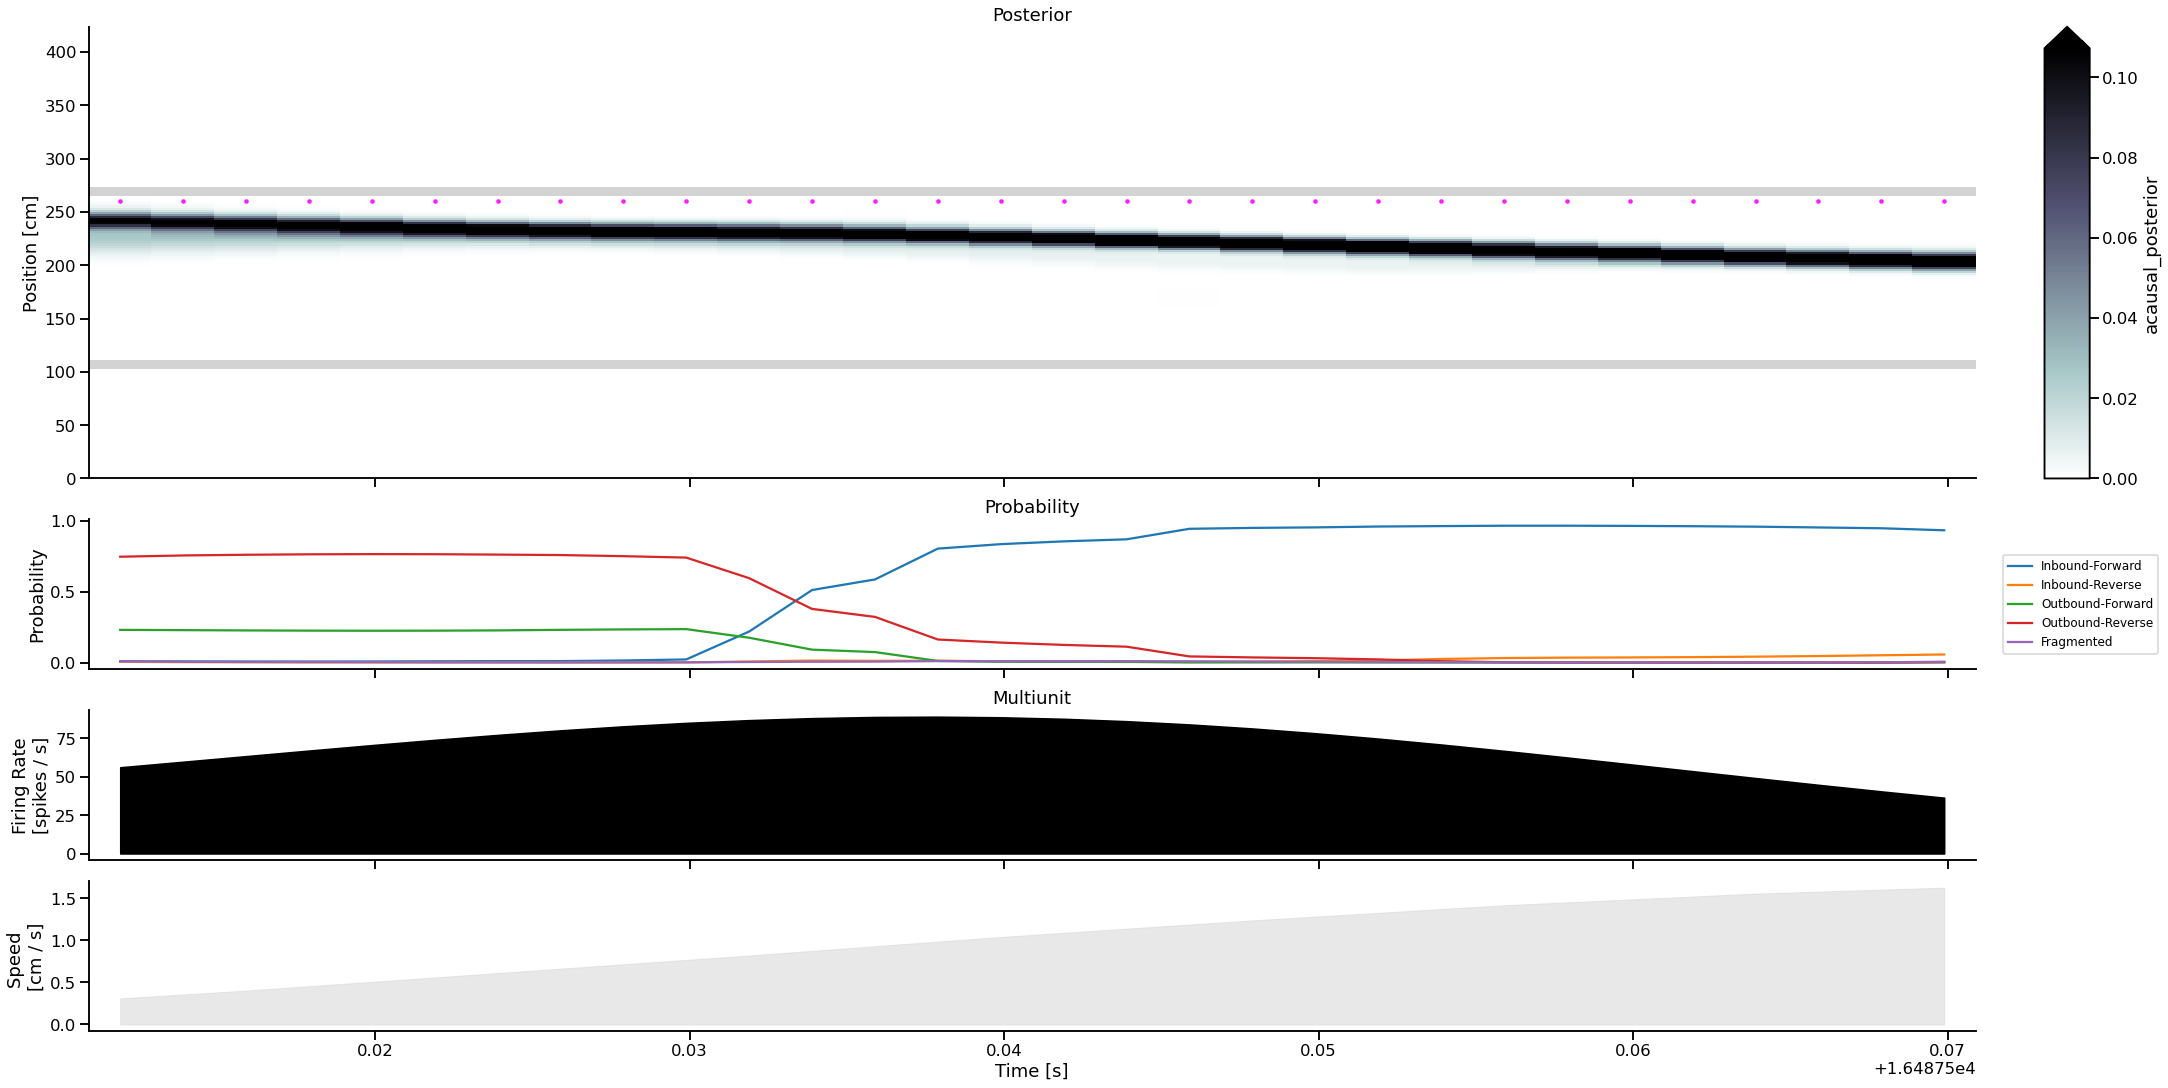

In [146]:
ripple_number = 24

plot_ripple_decode(data, classifier, ripple_number)

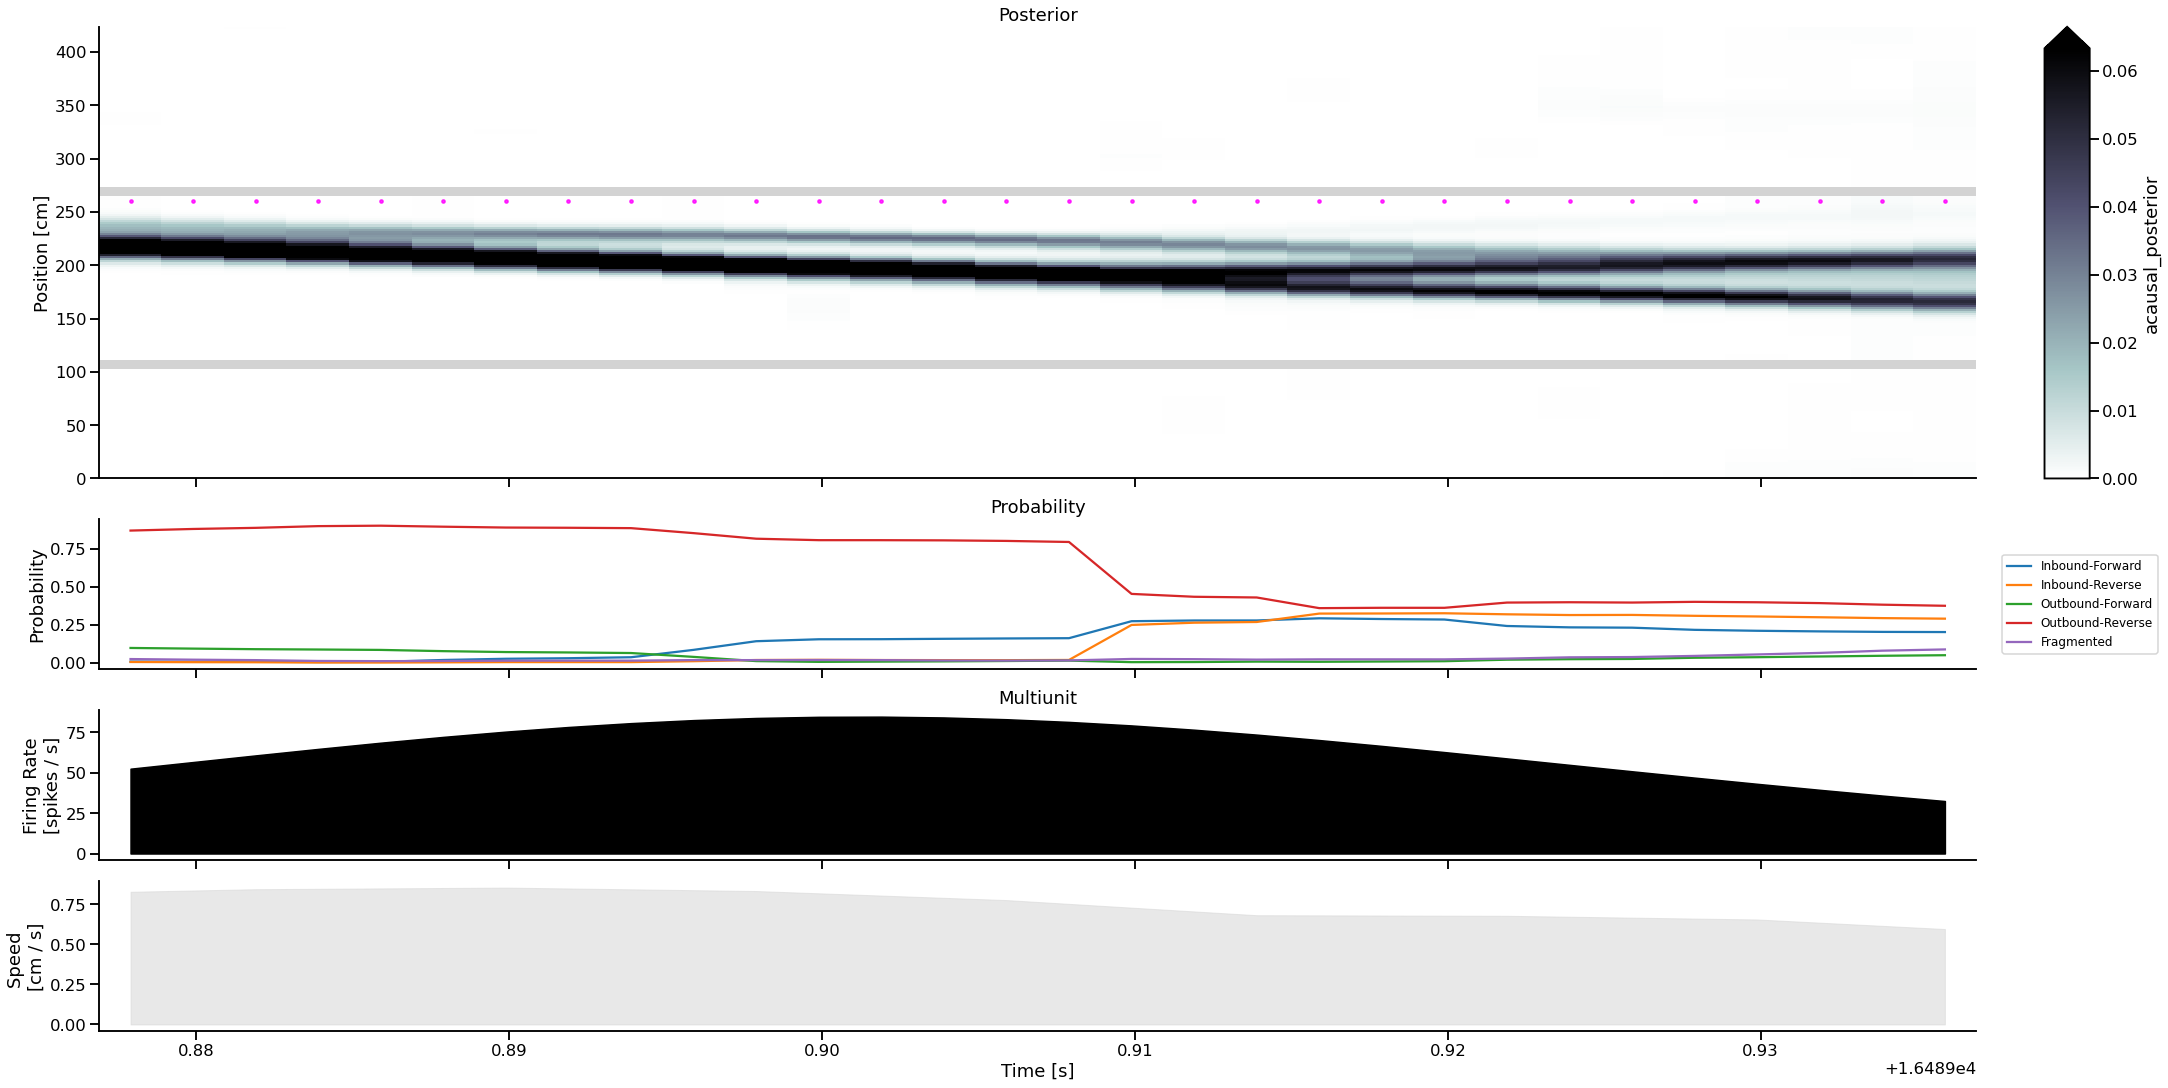

In [147]:
ripple_number = 25

plot_ripple_decode(data, classifier, ripple_number)

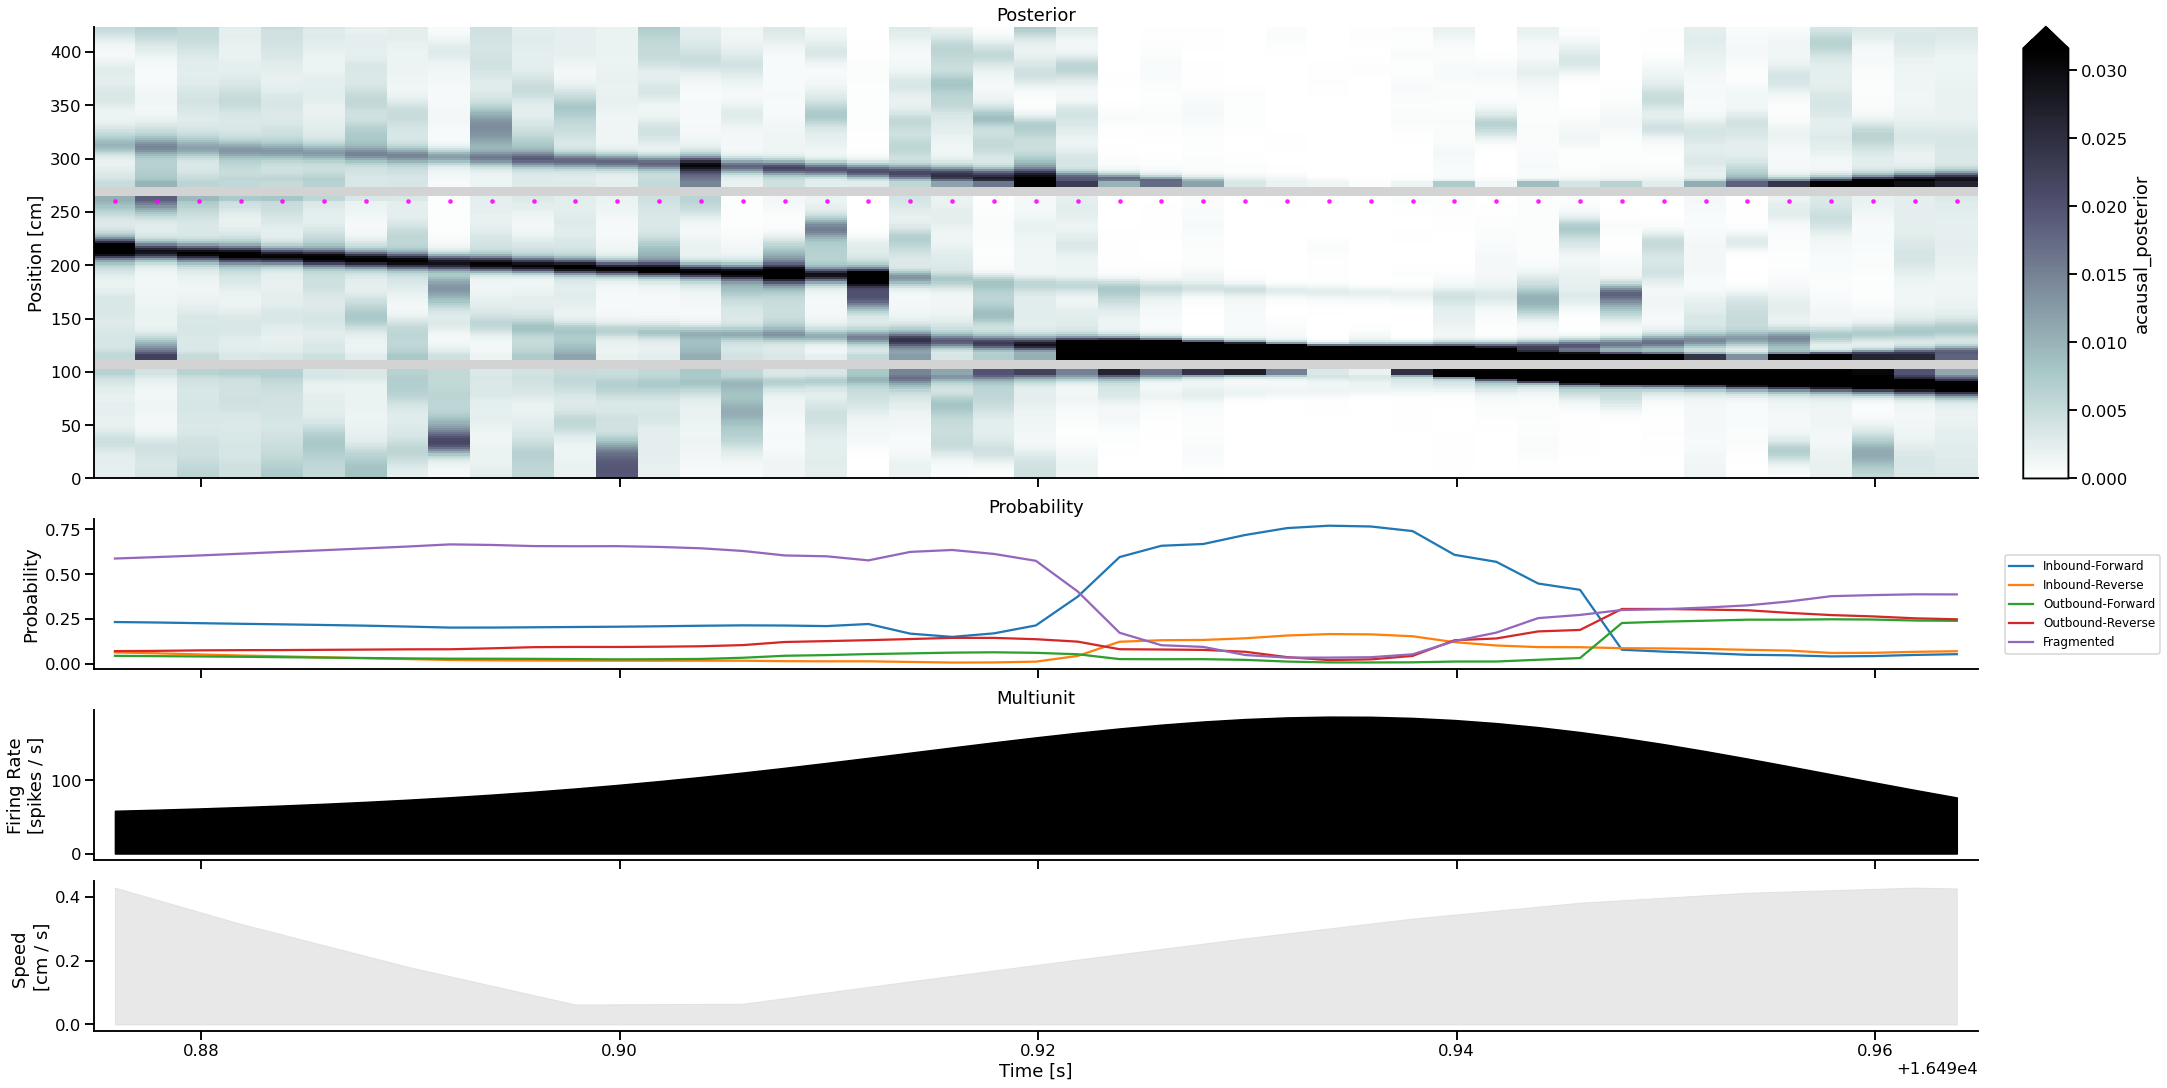

In [148]:
ripple_number = 26

plot_ripple_decode(data, classifier, ripple_number)

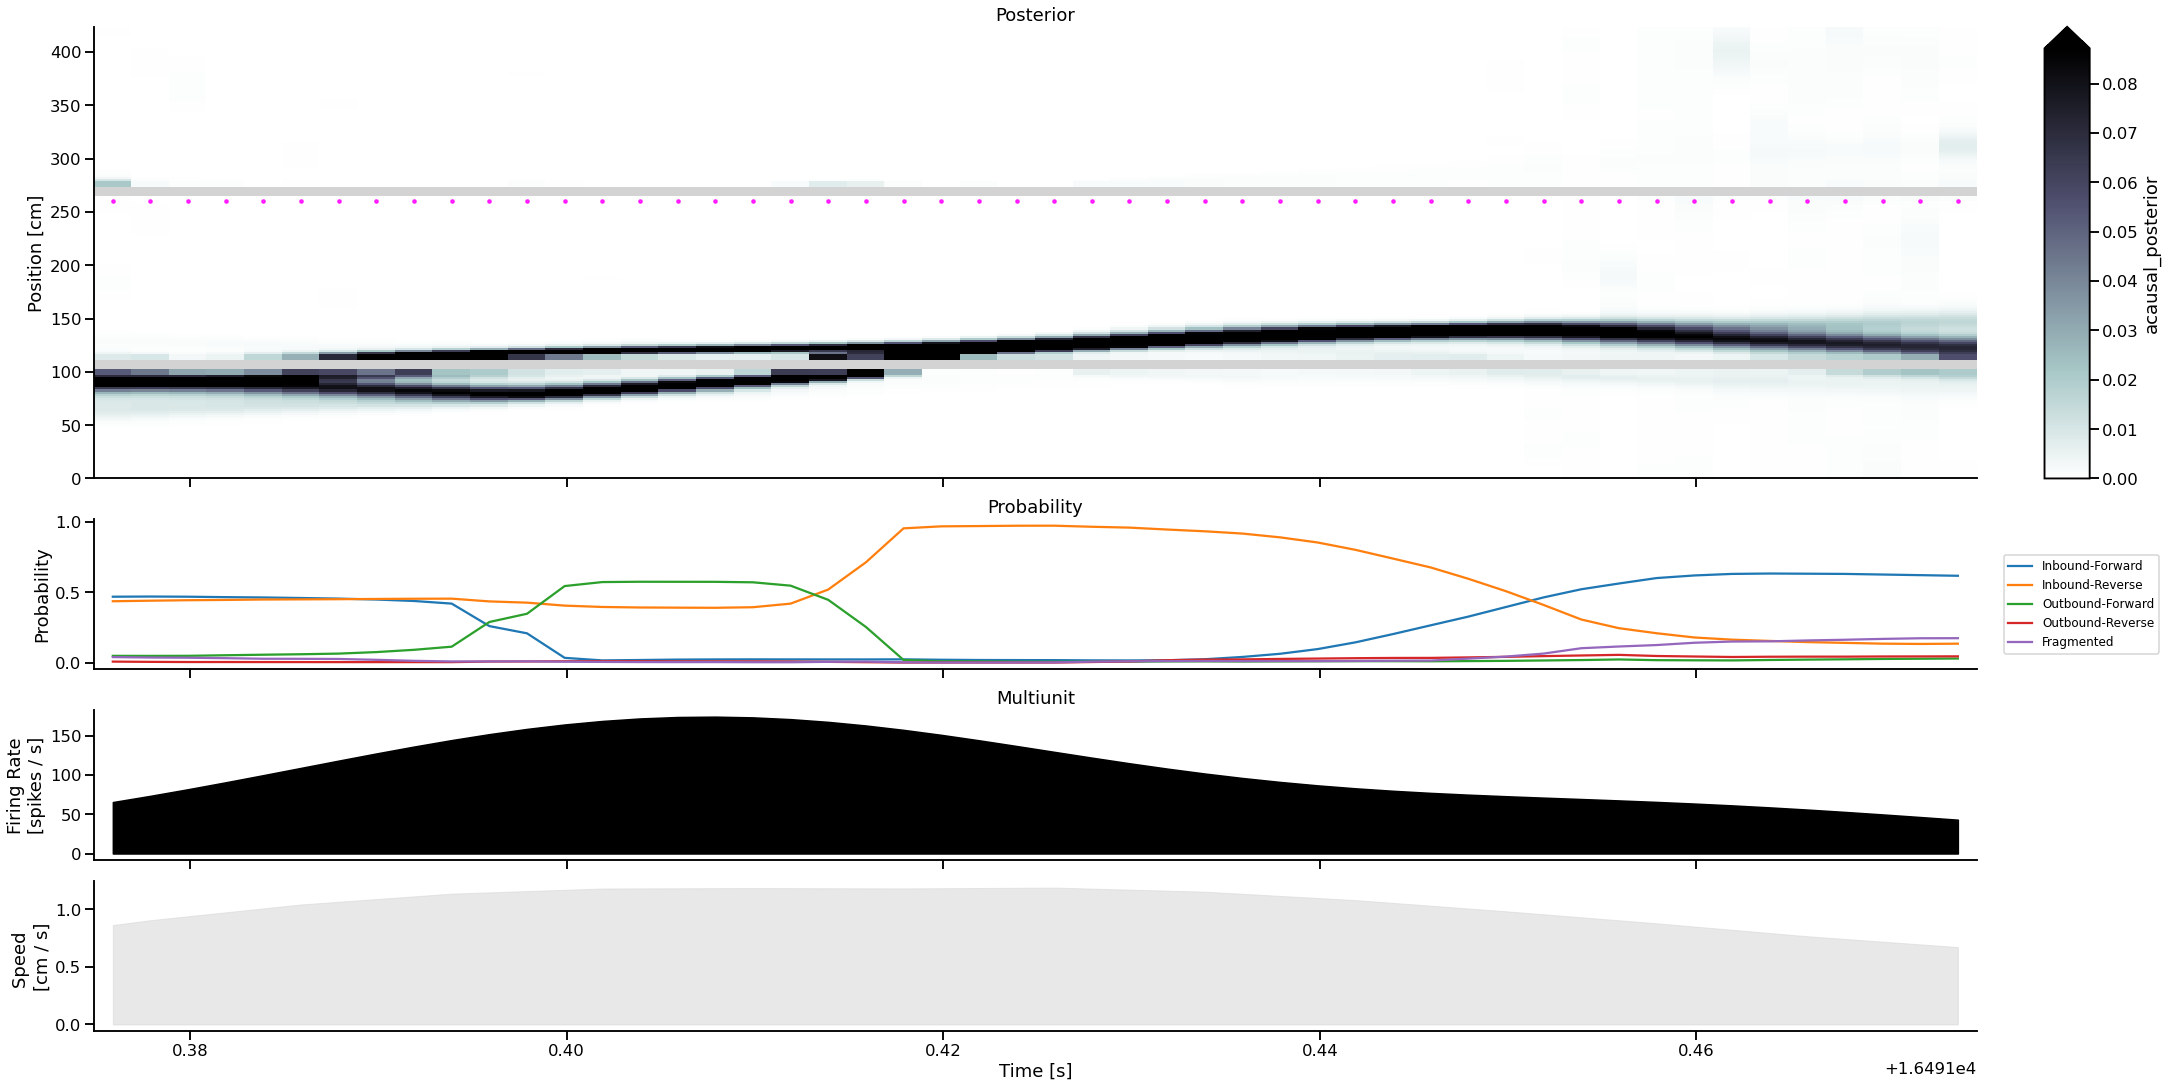

In [149]:
ripple_number = 27

plot_ripple_decode(data, classifier, ripple_number)

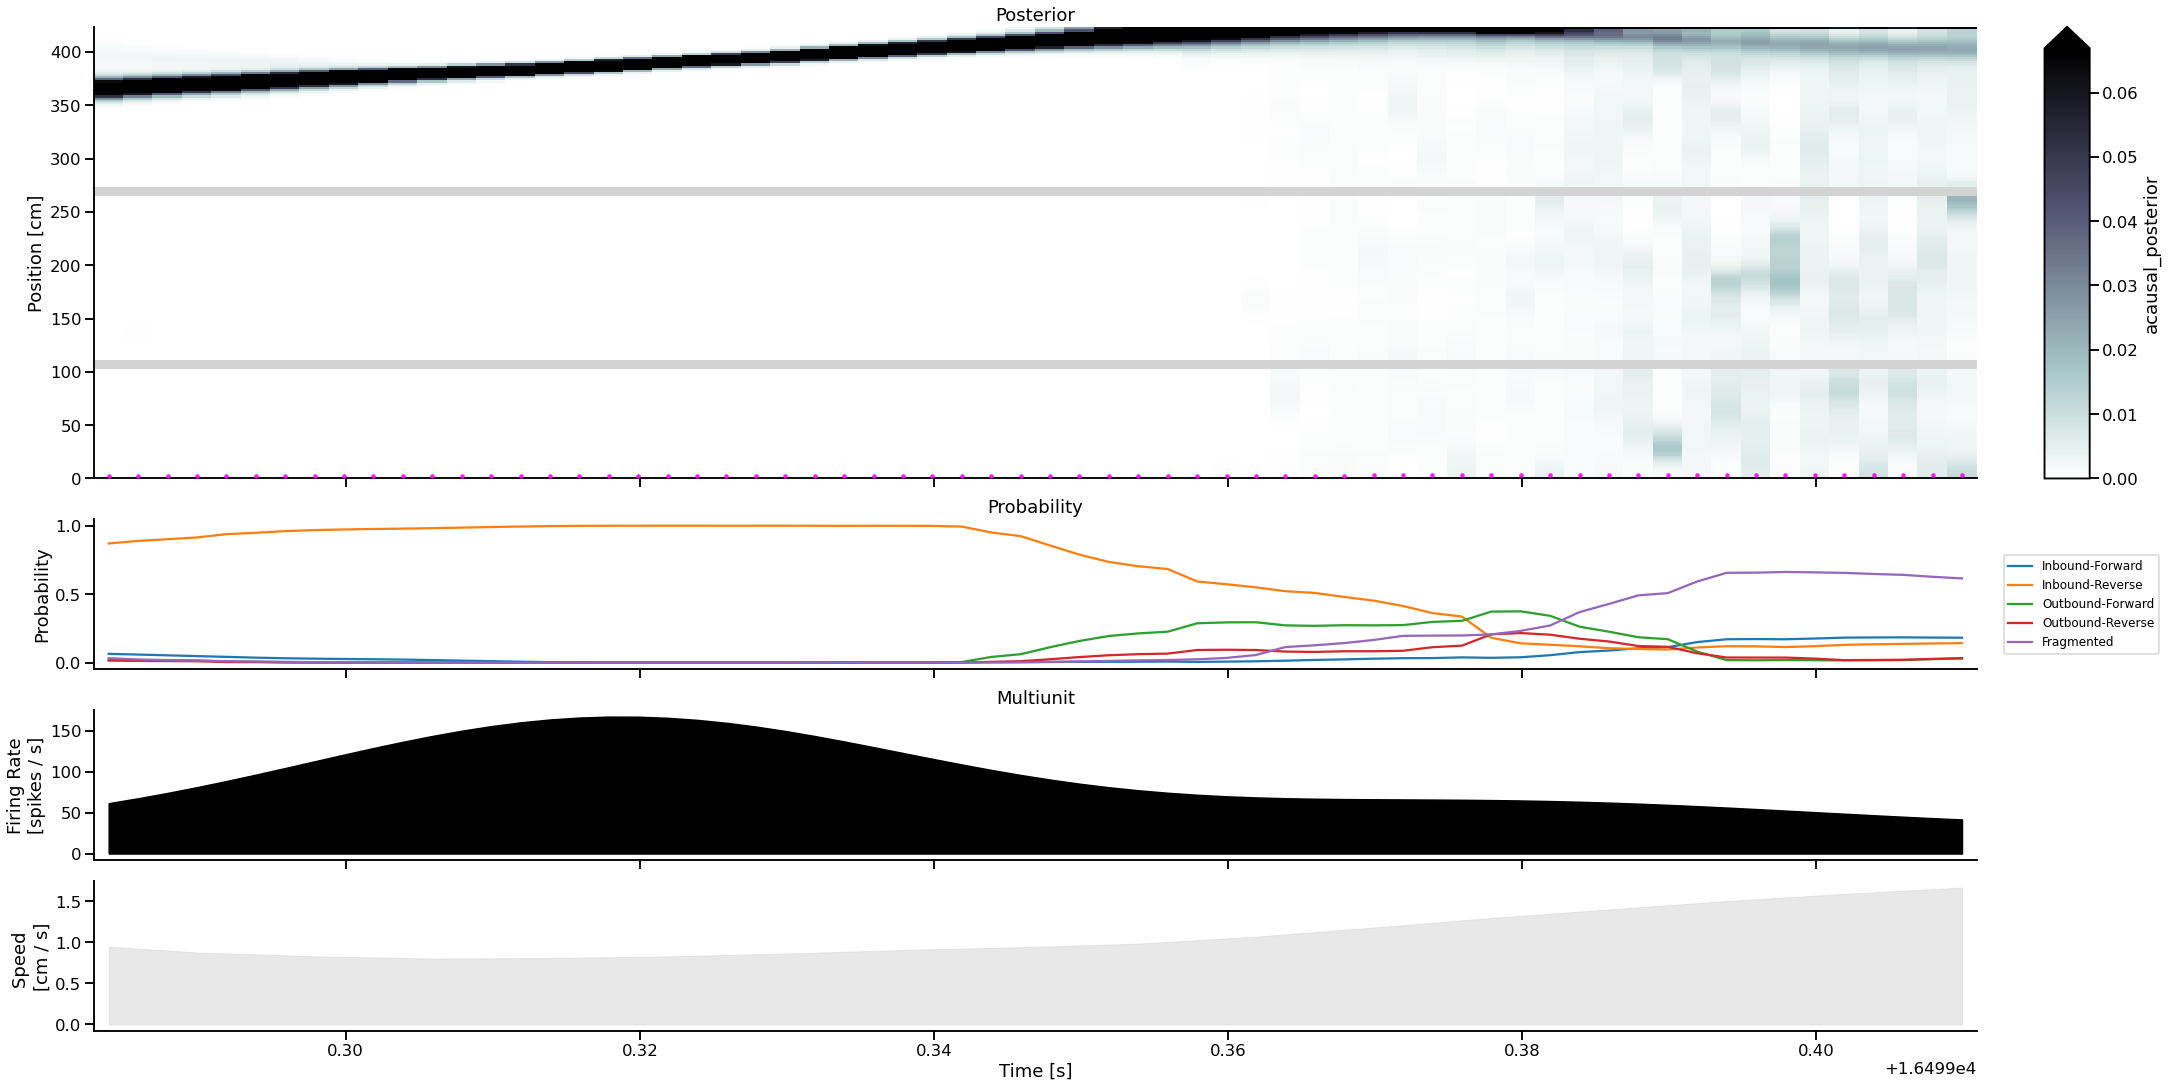

In [150]:
ripple_number = 28

plot_ripple_decode(data, classifier, ripple_number)

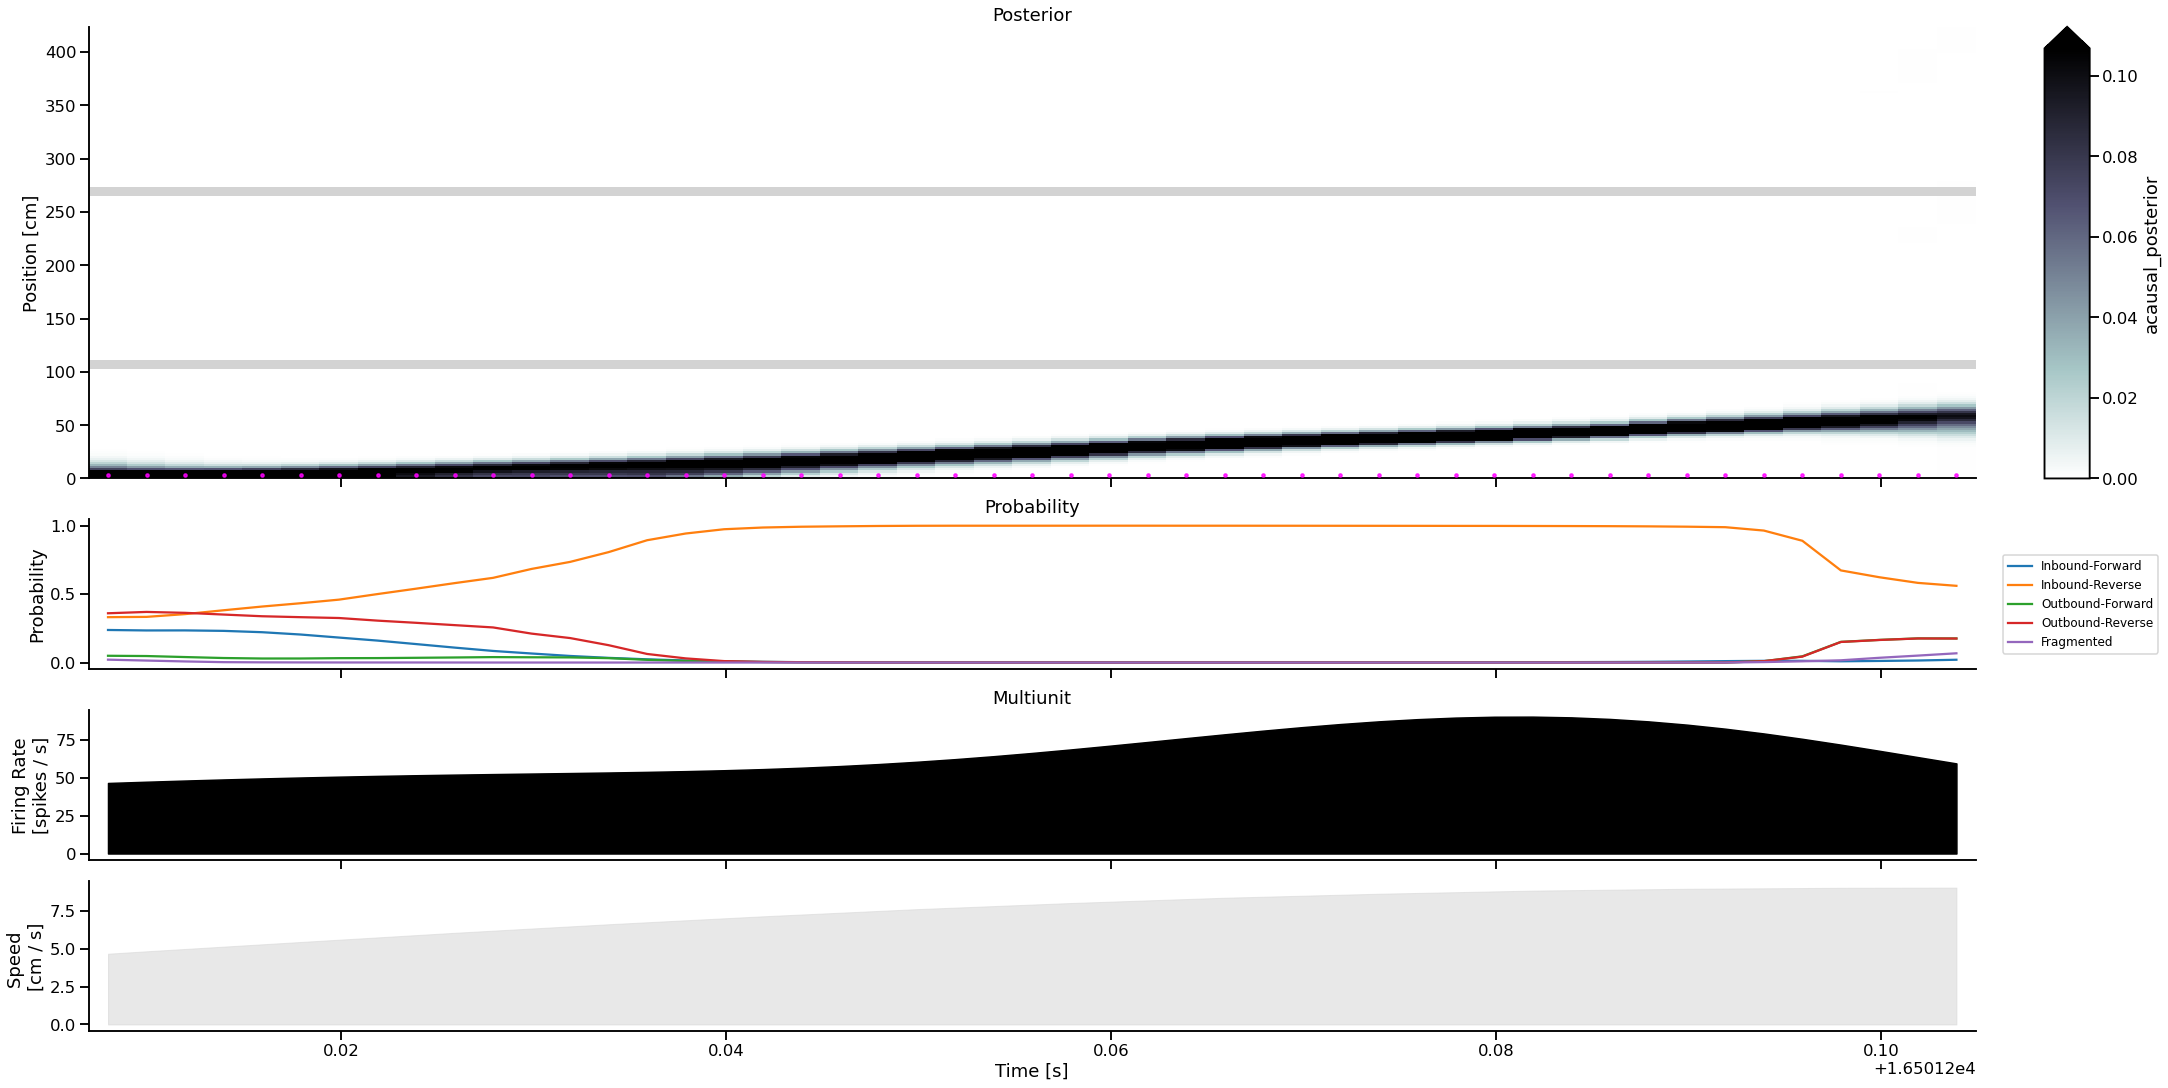

In [151]:
ripple_number = 29

plot_ripple_decode(data, classifier, ripple_number)

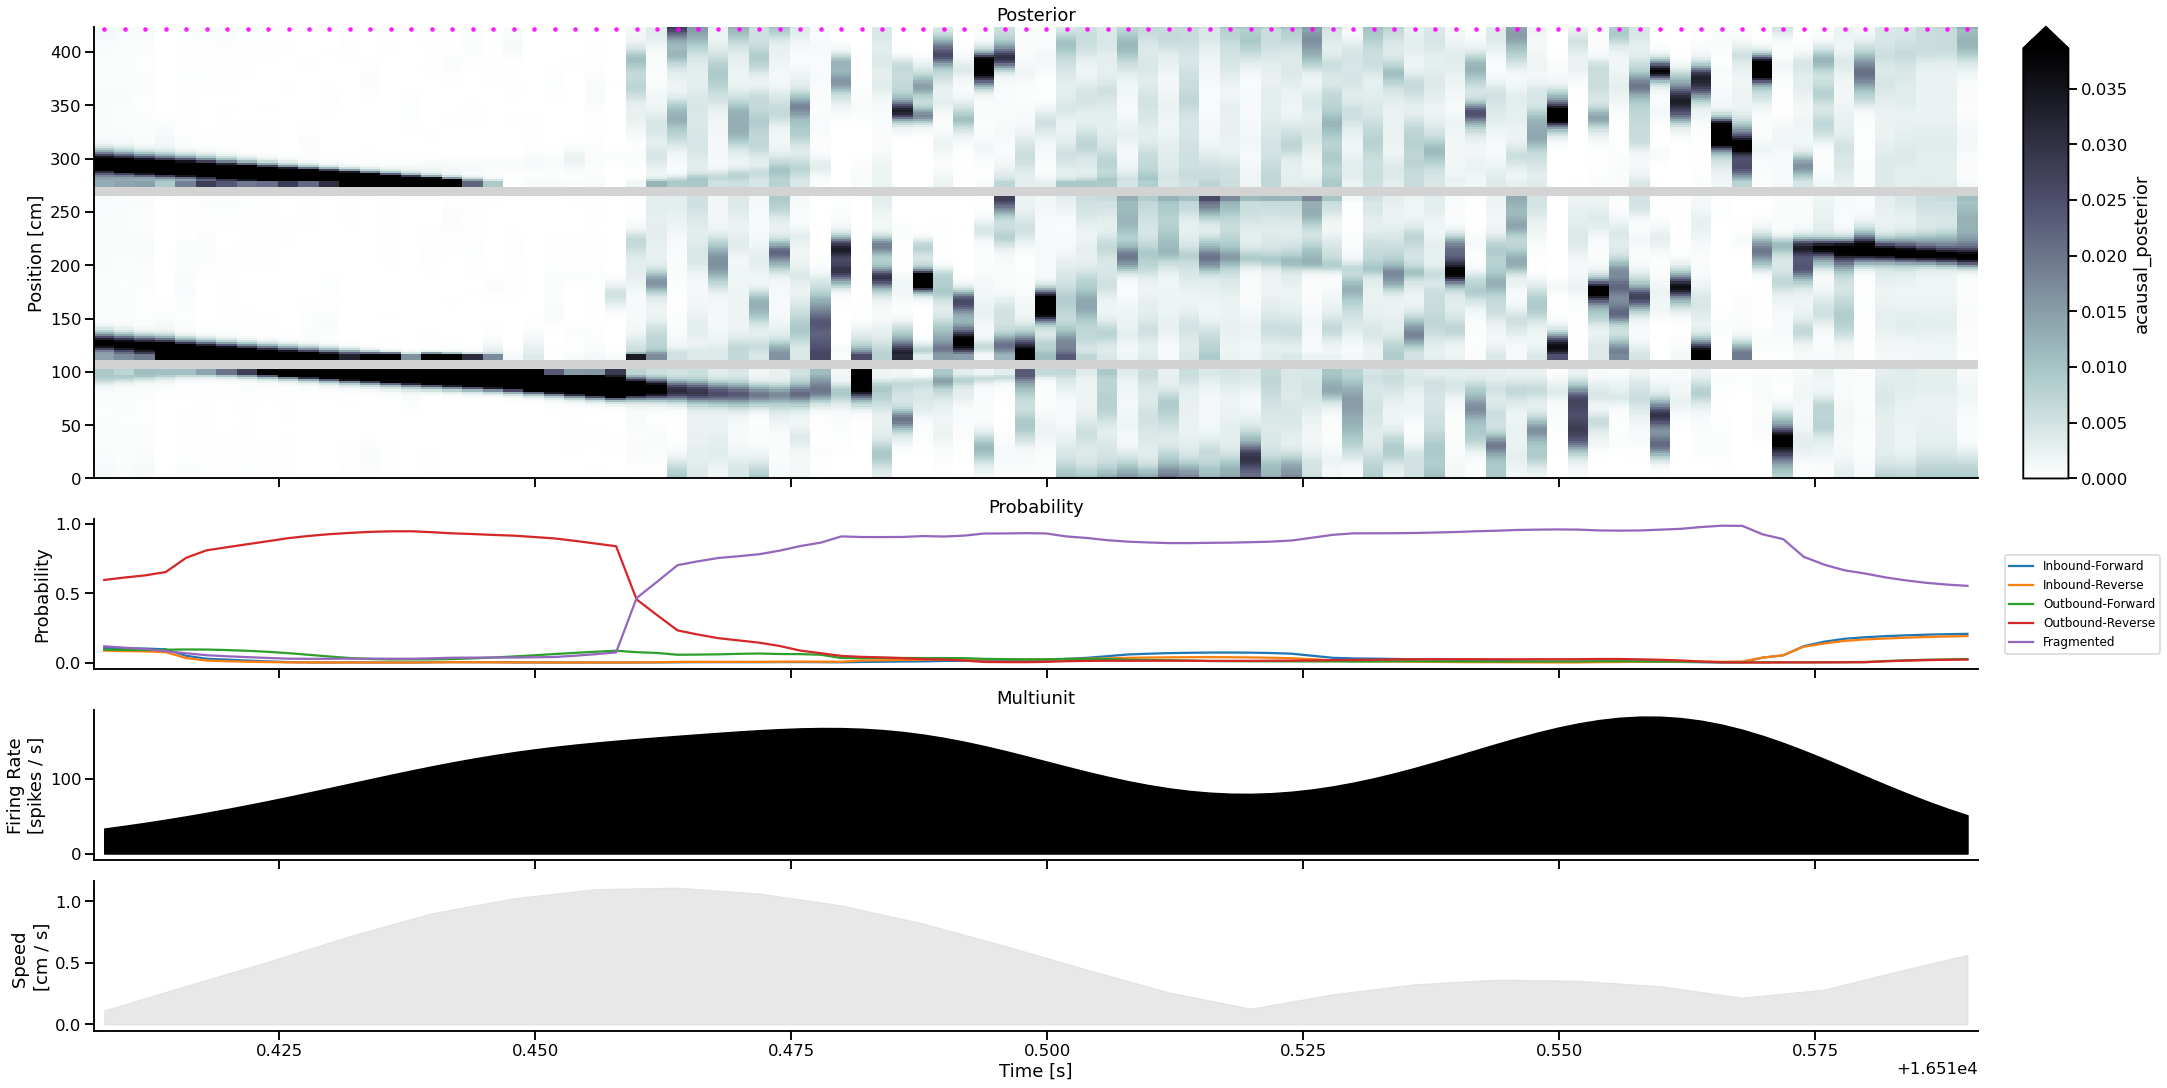

In [152]:
ripple_number = 30

plot_ripple_decode(data, classifier, ripple_number)

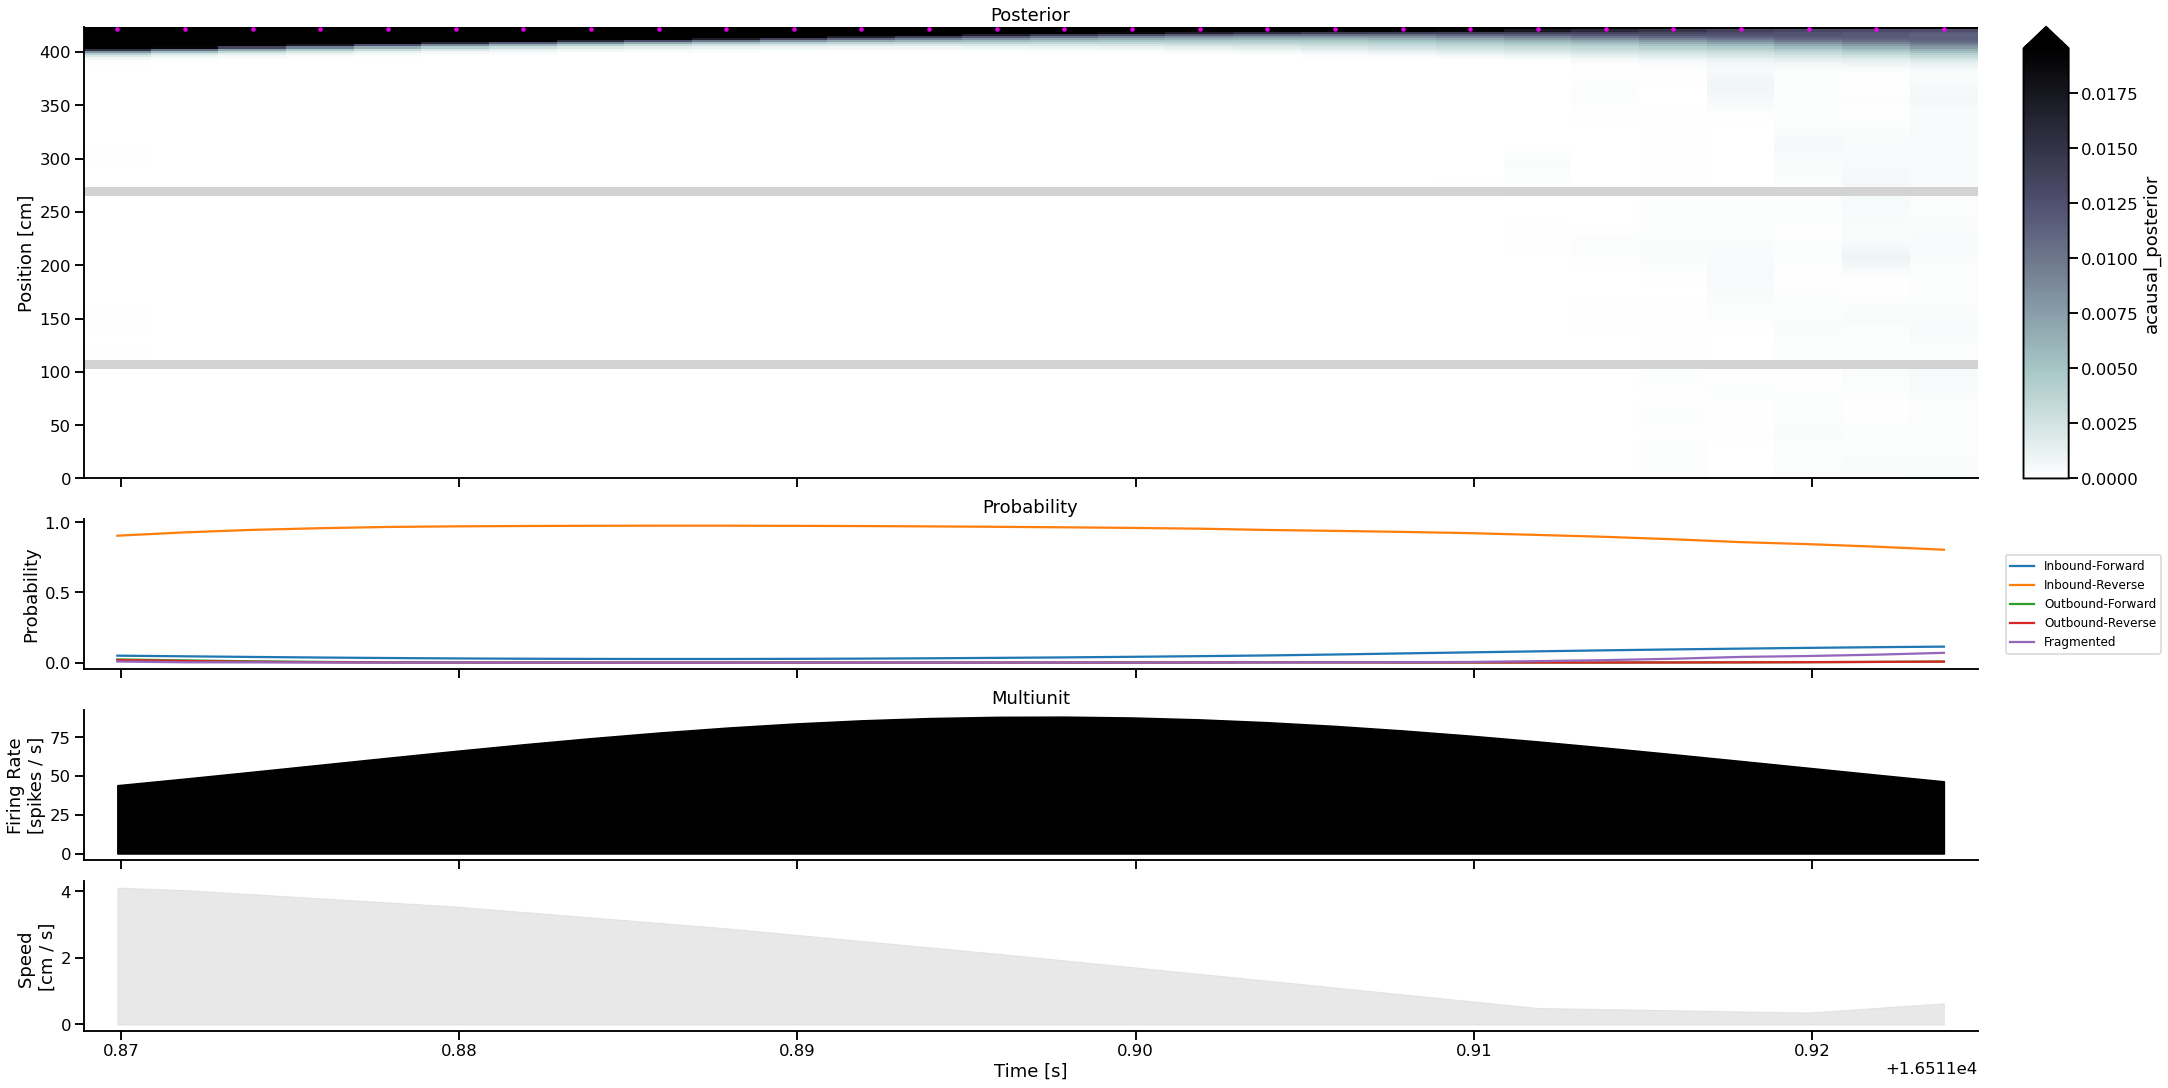

In [153]:
ripple_number = 31

plot_ripple_decode(data, classifier, ripple_number)

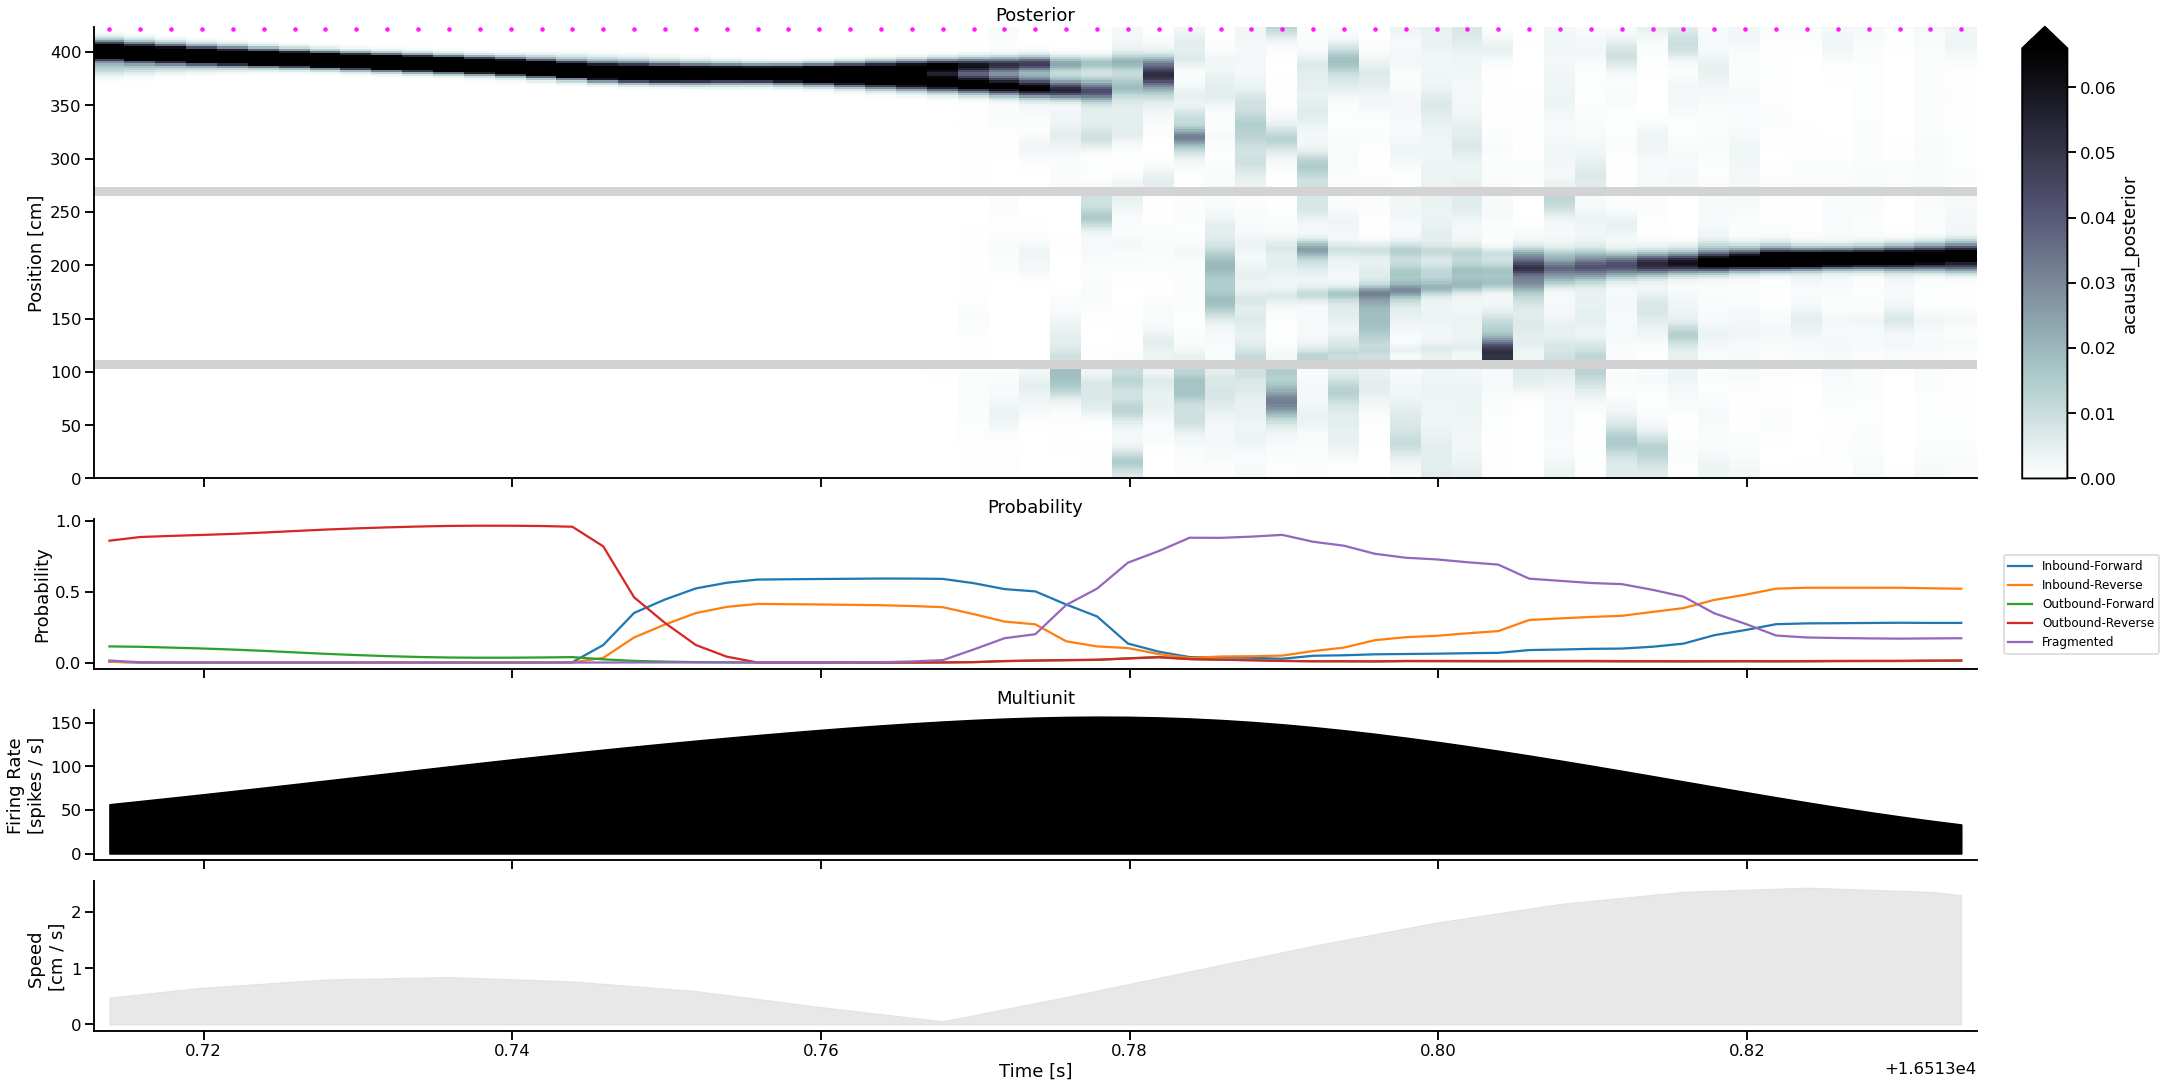

In [154]:
ripple_number = 32

plot_ripple_decode(data, classifier, ripple_number)